# Ex 1: Convolutional Autoencoder

**Imports, dataset loading and other utilities setup**

In [0]:
import random
import numpy as np
import torch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import logging
from timeit import default_timer as timer
from torch.autograd.variable import Variable
seed=7
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [0]:
# Let's define some hyper-parameters
hparams = {
    'batch_size':50,
    'num_epochs':6,
    'learning_rate':1e-3,
    'log_interval':100,
    'bottleneck_size': [2,6,10] 
}

# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

# Loading MNIST train and test sets
mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor()
                                ]))
mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor()
                               ]))

train_dataset, validation_dataset, debug_dataset = torch.utils.data.random_split(mnist_trainset, [int(len(mnist_trainset) * 0.95), int(len(mnist_trainset) * 0.05), int(len(mnist_trainset) * 0)])


train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=hparams['batch_size'], 
                                           shuffle = True)
validation_loader = torch.utils.data.DataLoader(validation_dataset,
                                                batch_size=hparams['batch_size'],
                                                shuffle = True)
test_loader = torch.utils.data.DataLoader(mnist_testset,
                                          batch_size=hparams['batch_size'],
                                          shuffle=False)

**Encoder**

In [0]:
# Implement a convolutional autoencoder

class Encoder(nn.Module):
    def __init__(self, bottleneck_size):
        super().__init__()
        # encoder layers
        self.encoder = nn.Sequential(
                                     nn.Conv2d(1, 64, 3, padding=1),
                                     nn.ReLU(inplace = True),
                                     nn.MaxPool2d(2, 2),
                                     nn.Conv2d(64, 16, 3, padding=1),
                                     nn.ReLU(inplace = True),
                                     nn.MaxPool2d(2, 2),
                                     nn.Flatten(),
                                     nn.Linear(7*7*16, bottleneck_size),
                                     nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

**Decoder**

In [0]:
class Decoder(nn.Module):
    def __init__(self, bottleneck_size):
        super().__init__()
        # decoder layers
        self.conn = nn.Sequential(
                                     nn.Linear(bottleneck_size, 7*7*16),
                                     nn.ReLU(inplace = True)
        )
        self.decoder = nn.Sequential(
                                     nn.UpsamplingBilinear2d(scale_factor = 2),
                                     nn.ConvTranspose2d(16, 64, 1),
                                     nn.ReLU(inplace = True),
                                     nn.UpsamplingBilinear2d(scale_factor = 2),
                                     nn.ConvTranspose2d(64, 1, 1),
                                     nn.ReLU(inplace = True)
        )

    def forward(self, x):
        x = self.conn(x)
        x = x.view(x.shape[0], 16, 7, 7)
        x = self.decoder(x)        
        return x

**AutoEncoder**

In [0]:
class ConvAutoencoder(nn.Module):
   def __init__(self, bottleneck_size):
     super().__init__()
     self.encoder = Encoder(bottleneck_size)
     self.decoder = Decoder(bottleneck_size)
  
   def forward(self, x):
     x = self.encoder(x)
     x = self.decoder(x)
     return x

**Training convolutional autoencoders with different bottleneck sizes.**

In [0]:
def train_epoch(train_loader, model, optimizer, criterion, hparams, epoch, autoenc=True):
  losses = []
  batch_idx = 0
  for data in train_loader:
        images, labels = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the loss
        if autoenc:
          loss = criterion(output, images) * 784 # image level error
        else:
          loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        losses.append(loss.item())
        batch_idx = batch_idx + 1
        # print loss updates every log_interval batches
        if batch_idx % hparams['log_interval'] == 0 or batch_idx >= len(train_loader):
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t'.format(
            epoch, batch_idx * len(data[0]), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
        
  return losses


def eval_epoch(validation_loader, model, criterion, hparams, autoenc=True):
    model.eval()
    eval_loss = []
    with torch.no_grad():
        for data in validation_loader:
            images, labels = data
            output = model(images)
            if autoenc:
              e1_loss = criterion(output, images) * 784
            else:
              e1_loss = criterion(output, labels)
            eval_loss.append(e1_loss.item())

    e_loss = np.mean(eval_loss)
    print('Eval set: Average loss: {:.4f}'.format(
        e_loss, len(validation_loader.dataset)
        ))
    return e_loss

def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def test_model(test_loader, model, criterion, hparams, autoenc=True):
    model.eval()
    test_loss = []
    acc = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            output = model(images)
            if autoenc:
              t1_loss = criterion(output, images) * 784
            else:
              t1_loss = criterion(output, labels)
              acc += correct_predictions(output, labels)
            test_loss.append(t1_loss.item())
            
    test_acc = 100. * acc / len(test_loader.dataset)        
    t_loss = np.mean(test_loss)
    return t_loss, test_acc

In [0]:
def train_net(model, train_loader, optimizer, num_epochs, criterion, validation_loader, autoenc=True):
    tr_losses = []
    te_losses = []

    for epoch in range(1, num_epochs + 1):
      tr_loss = []
      te_loss = []
      tr_loss = train_epoch(train_loader, model, optimizer, criterion, hparams, epoch, autoenc)
      te_loss = eval_epoch(validation_loader, model, criterion, hparams, autoenc)
      tr_losses.append(tr_loss)
      te_losses.append(te_loss)
    
    return tr_losses, te_losses

Bottleneck size is: 2
Train Epoch: 1 [5000/57000 (9%)]	Loss: 82.979126	
Train Epoch: 1 [10000/57000 (18%)]	Loss: 89.559143	
Train Epoch: 1 [15000/57000 (26%)]	Loss: 83.881042	
Train Epoch: 1 [20000/57000 (35%)]	Loss: 86.648529	
Train Epoch: 1 [25000/57000 (44%)]	Loss: 89.292244	
Train Epoch: 1 [30000/57000 (53%)]	Loss: 92.288155	
Train Epoch: 1 [35000/57000 (61%)]	Loss: 85.997658	
Train Epoch: 1 [40000/57000 (70%)]	Loss: 86.447762	
Train Epoch: 1 [45000/57000 (79%)]	Loss: 85.219307	
Train Epoch: 1 [50000/57000 (88%)]	Loss: 91.411110	
Train Epoch: 1 [55000/57000 (96%)]	Loss: 88.589897	
Train Epoch: 1 [57000/57000 (100%)]	Loss: 81.878487	
Eval set: Average loss: 87.9212
Train Epoch: 2 [5000/57000 (9%)]	Loss: 90.143860	
Train Epoch: 2 [10000/57000 (18%)]	Loss: 91.140778	
Train Epoch: 2 [15000/57000 (26%)]	Loss: 87.329712	
Train Epoch: 2 [20000/57000 (35%)]	Loss: 82.018196	
Train Epoch: 2 [25000/57000 (44%)]	Loss: 96.202477	
Train Epoch: 2 [30000/57000 (53%)]	Loss: 87.676208	
Train Epoch: 

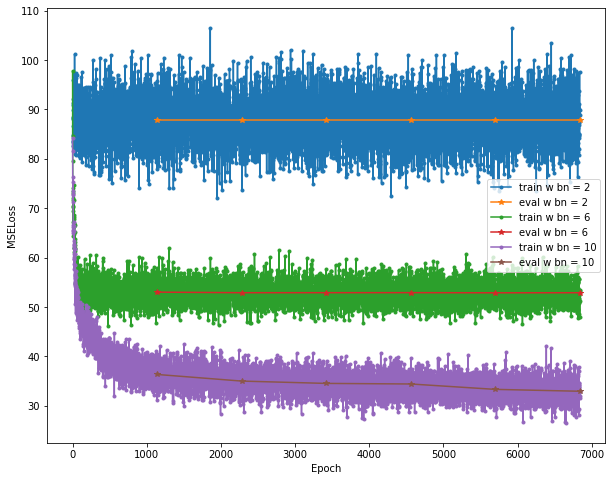

In [0]:
import itertools


tr_losses = []
te_losses = []
model = []

for i in range(len(hparams['bottleneck_size'])):

  print ("Bottleneck size is:", hparams['bottleneck_size'][i])
  
  model.append(ConvAutoencoder((hparams['bottleneck_size'])[i]))
  tr_loss_i = []
  te_loss_i = []
  # specify loss function
  criterion = nn.MSELoss()
  # specify optimizer
  optimizer = torch.optim.Adam(model[i].parameters(), lr=0.001)
 
  tr_loss_i, te_loss_i = train_net(model[i], train_loader, optimizer, hparams['num_epochs'], criterion, validation_loader,(hparams['bottleneck_size'])[i])
  tr_losses.append(np.asarray(list(itertools.chain.from_iterable(tr_loss_i))))
  te_losses.append(te_loss_i)
  
plt.figure(figsize=(10, 8))
plt.xlabel('Epoch')
plt.ylabel('MSELoss')

te_indexes = [ (len(train_dataset) / hparams['batch_size']) * (i+1) for i in range(hparams['num_epochs']) ]

for i in range(len(tr_losses)):
  plt.plot(tr_losses[i], '.-', label='train w bn = {}'.format((hparams['bottleneck_size'])[i]))
  plt.plot(te_indexes, te_losses[i], '*-',label='eval w bn = {}'.format((hparams['bottleneck_size'])[i]))
  plt.legend()


**Average image reconstruction error (MSE) of the trained models on MNIST valset and testset**

In [0]:
test_err = []
val_err = []

print ("Bottleneck Size\t\tNum. Params\t\tValidation error(avg)\t\tTest error(avg)")
print ("-----------------------------------------------------------------------------------------------")
for i in range(len(hparams['bottleneck_size'])):
  v_err, _ = test_model(validation_loader, model[i], criterion, hparams)
  val_err.append(v_err)
  t_err, _ = test_model(test_loader, model[i], criterion, hparams)
  test_err.append(t_err)
  print ("\t%d\t\t%d\t\t\t%f\t\t%f" % ((hparams['bottleneck_size'])[i],sum(p.numel() for p in model[i].parameters()), val_err[i], test_err[i]))

print ("-----------------------------------------------------------------------------------------------")


Bottleneck Size		Num. Params		Validation error(avg)		Test error(avg)
-----------------------------------------------------------------------------------------------
	2		14947			87.921226		89.343155
	6		21223			52.901884		52.986769
	10		27499			32.956433		32.818525
-----------------------------------------------------------------------------------------------


**Selection of the best autoencoder and feeding it 5 random MNIST images**


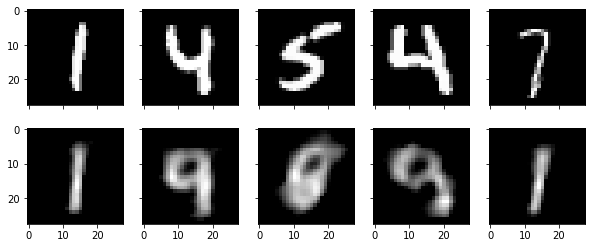

In [0]:
test_subset_indexes = random.sample(range(1, 1000), 5)
test_subset = torch.utils.data.Subset(mnist_testset, test_subset_indexes)

loader = torch.utils.data.DataLoader(test_subset, batch_size=5, shuffle = False)

# Find the index of the best model according to the test error
best_model = test_err.index(min(test_err))
for data in loader:
  img, _ = data
  recon = model[best_model](img)

iterator = iter(loader)
img_orig, _ = iterator.next()
img_orig = img_orig.numpy()

fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(10,4))

for i in range(5):
  axes[0][i].imshow(np.squeeze(img_orig[i]),cmap='gray')
  axes[1][i].imshow(np.squeeze(recon[i].detach().numpy()),cmap='gray')

fig.show()

**Feeding of 5 random images**

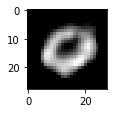

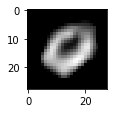

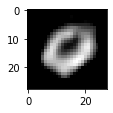

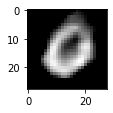

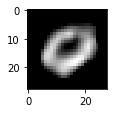

In [0]:
rand_img = torch.rand(5, 1, 28, 28)

loader = torch.utils.data.DataLoader(rand_img, batch_size=5, shuffle = False)

for data in loader:
  rand_recon = model[best_model](data)

for i in range(5):
  fig = plt.figure(figsize = (5,5))
  ax = fig.add_subplot(3,2,i+1)
  ax.imshow(rand_recon[i].detach().numpy()[0][:][:], cmap = 'gray')

# Ex 2: Transfer Learning

In [0]:
# subset of 100 images and their associated labels

train_subset_indexes = random.sample(range(1, len(mnist_testset)), 95)
train_subset = torch.utils.data.Subset(mnist_trainset, train_subset_indexes)

train_loader_100 = torch.utils.data.DataLoader(train_subset,batch_size=1,shuffle = False)

val_subset_indexes = random.sample(range(1, len(mnist_testset)), 5)
val_subset = torch.utils.data.Subset(mnist_trainset, val_subset_indexes)

val_loader_100 = torch.utils.data.DataLoader(val_subset,batch_size=1,shuffle = False)

In [0]:
# select the best of the previously trained autoencoders
pretrained_model = model[best_model]

In [0]:
# digit (0-9) classification model reusing the encoder
classifier_pret = nn.Sequential(
    pretrained_model.encoder,
    nn.Linear( (hparams['bottleneck_size'])[best_model], 10 ),
    nn.LogSoftmax(dim=1)
)

**Training of model 1: pre-trained**

In [0]:
# Let's define some hyper-parameters
hparams_tranf_lear = {
    'num_epochs':10,
    'num_classes':10,
    'log_interval':100
}

# Model 1: pre-trained

# freeze all levels using old weights, except the new ones
for layer in classifier_pret[:-2]:
  for param in layer.parameters():
      param.requires_grad = False

# specify loss function
criterion = nn.NLLLoss()

# specify optimizer
optimizer = torch.optim.Adam(classifier_pret.parameters(), lr=0.001)

# train
loss = train_net(classifier_pret, train_loader_100, optimizer, hparams_tranf_lear['num_epochs'], criterion, val_loader_100, autoenc=False)

Train Epoch: 1 [95/95 (100%)]	Loss: 2.579878	
Eval set: Average loss: 2.3016
Train Epoch: 2 [95/95 (100%)]	Loss: 2.629739	
Eval set: Average loss: 1.9810
Train Epoch: 3 [95/95 (100%)]	Loss: 2.694417	
Eval set: Average loss: 1.7944
Train Epoch: 4 [95/95 (100%)]	Loss: 2.748758	
Eval set: Average loss: 1.6870
Train Epoch: 5 [95/95 (100%)]	Loss: 2.786784	
Eval set: Average loss: 1.6211
Train Epoch: 6 [95/95 (100%)]	Loss: 2.809808	
Eval set: Average loss: 1.5754
Train Epoch: 7 [95/95 (100%)]	Loss: 2.821006	
Eval set: Average loss: 1.5389
Train Epoch: 8 [95/95 (100%)]	Loss: 2.823458	
Eval set: Average loss: 1.5067
Train Epoch: 9 [95/95 (100%)]	Loss: 2.819648	
Eval set: Average loss: 1.4767
Train Epoch: 10 [95/95 (100%)]	Loss: 2.811440	
Eval set: Average loss: 1.4480


**Training of model 2: fine-tuned**

In [0]:
# Model 2: fine-tuned

classifier_fine = nn.Sequential(
    pretrained_model.encoder,
    nn.Linear( (hparams['bottleneck_size'])[best_model], 10 ),
    nn.LogSoftmax(dim=1)
)


In [0]:
# specify loss function with different lr on the two parts of the model
criterion = nn.NLLLoss()

optimizer = torch.optim.Adam([
                              {'params': classifier_fine[1].parameters()} ,
                              { 'params': classifier_fine[0].parameters(), 'lr':1e-5 } 
                              ], lr=1e-3   )

loss = train_net(classifier_fine, train_loader_100, optimizer, hparams_tranf_lear['num_epochs'], criterion, val_loader_100, autoenc=False)


Train Epoch: 1 [95/95 (100%)]	Loss: 1.695159	
Eval set: Average loss: 1.8953
Train Epoch: 2 [95/95 (100%)]	Loss: 1.974813	
Eval set: Average loss: 1.7368
Train Epoch: 3 [95/95 (100%)]	Loss: 2.178235	
Eval set: Average loss: 1.6736
Train Epoch: 4 [95/95 (100%)]	Loss: 2.312530	
Eval set: Average loss: 1.6388
Train Epoch: 5 [95/95 (100%)]	Loss: 2.400768	
Eval set: Average loss: 1.6109
Train Epoch: 6 [95/95 (100%)]	Loss: 2.459771	
Eval set: Average loss: 1.5841
Train Epoch: 7 [95/95 (100%)]	Loss: 2.500073	
Eval set: Average loss: 1.5571
Train Epoch: 8 [95/95 (100%)]	Loss: 2.528115	
Eval set: Average loss: 1.5301
Train Epoch: 9 [95/95 (100%)]	Loss: 2.547770	
Eval set: Average loss: 1.5035
Train Epoch: 10 [95/95 (100%)]	Loss: 2.561298	
Eval set: Average loss: 1.4774


**Training of model 3: from scratch**

In [0]:
# Model 3: model from scratch

untrained_model = ConvAutoencoder((hparams['bottleneck_size'])[best_model])

classifier_scratch = nn.Sequential(
    untrained_model.encoder,
    nn.Linear( (hparams['bottleneck_size'])[best_model], 10 ),
    nn.LogSoftmax(dim=1)
)

# specify loss function
criterion = nn.NLLLoss()

# specify loss function
optimizer = torch.optim.Adam(classifier_scratch.parameters(), lr=0.001)

loss = train_net(classifier_scratch, train_loader_100, optimizer, hparams_tranf_lear['num_epochs'], criterion, val_loader_100, autoenc=False)

Train Epoch: 1 [95/95 (100%)]	Loss: 2.383844	
Eval set: Average loss: 2.2610
Train Epoch: 2 [95/95 (100%)]	Loss: 2.563224	
Eval set: Average loss: 2.1886
Train Epoch: 3 [95/95 (100%)]	Loss: 2.934900	
Eval set: Average loss: 1.9780
Train Epoch: 4 [95/95 (100%)]	Loss: 2.656388	
Eval set: Average loss: 1.5651
Train Epoch: 5 [95/95 (100%)]	Loss: 2.638254	
Eval set: Average loss: 1.4609
Train Epoch: 6 [95/95 (100%)]	Loss: 2.731259	
Eval set: Average loss: 1.3372
Train Epoch: 7 [95/95 (100%)]	Loss: 2.312909	
Eval set: Average loss: 1.0138
Train Epoch: 8 [95/95 (100%)]	Loss: 2.699557	
Eval set: Average loss: 0.9066
Train Epoch: 9 [95/95 (100%)]	Loss: 2.581856	
Eval set: Average loss: 1.0585
Train Epoch: 10 [95/95 (100%)]	Loss: 2.215913	
Eval set: Average loss: 1.2437


**Comparison of accuracy of the three models**

In [0]:
t_acc = []

print ("Model \t\t\t Test accuracy")
print ("---------------------------------------------------------------------------")
_, t_acc = test_model(test_loader, classifier_pret, criterion, hparams, autoenc=False)
print ("%s\t\t\t%f" % ("Pretrained_model", t_acc))
_, t_acc = test_model(test_loader, classifier_fine, criterion, hparams, autoenc=False)
print ("%s\t\t\t%f" % ("Finetuned_model", t_acc))
_ , t_acc = test_model(test_loader, classifier_scratch, criterion, hparams, autoenc=False)
print ("%s\t\t\t%f" % ("Scratch_model", t_acc))
print ("---------------------------------------------------------------------------")

Model 			 Test accuracy
---------------------------------------------------------------------------
Pretrained_model			28.210000
Untrained_model			29.960000
Scratch_model			37.360000
---------------------------------------------------------------------------


# Optional Exercise A: Variational Autoencoder

In [0]:
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from tabulate import tabulate

torch.manual_seed(40)
np.random.seed(40)

**Autoencoder similar to Ex.1, but the deterministic bottleneck is turned into a stochastic bottleneck**

In [0]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # conv layer
        self.encoder = nn.Sequential(
                                     nn.Conv2d(1, 64, 3, padding=1),
                                     nn.ReLU(inplace = True),
                                     nn.MaxPool2d(2, 2),
                                     nn.Conv2d(64, 16, 3, padding=1),
                                     nn.ReLU(inplace = True),
                                     nn.MaxPool2d(2, 2)
        )

        # fc layers to obtain mean and variance vectors
        self.fc1m = nn.Linear(784, 20)
        self.fc1s = nn.Linear(784, 20)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1,784)
        return  self.fc1m(x),self.fc1s(x)
        
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # decoder layers
        self.decoder = nn.Sequential(
                                     nn.UpsamplingBilinear2d(scale_factor = 2),
                                     nn.ConvTranspose2d(16, 64, 1),
                                     nn.ReLU(inplace = True),
                                     nn.UpsamplingBilinear2d(scale_factor = 2),
                                     nn.ConvTranspose2d(64, 1, 1),
                                     nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.shape[0],16,7,7)
        x = self.decoder(x)        
        return x

In [0]:
# define VAE as the combination of encoder, decoder and other layers in beetween

class VAE(nn.Module):
  def __init__(self):
     super().__init__()
     self.fc = nn.Sequential(
         nn.Linear(20, 400),
         nn.ReLU(),
         nn.Linear(400, 784),
         nn.ReLU()
     )
     self.encoder = Encoder()
     self.decoder = Decoder()

  def reparametrize(self, mu, logvar):
    std = logvar.mul(0.5).exp_()
    eps = torch.FloatTensor(std.size()).normal_()
    eps = Variable(eps)
    return Variable(eps.mul(std).add_(mu))


  def forward(self,x):
    mu, logvar = self.encoder(x)
    #The latent variable is obtained by the reparametrization to preserve the backpropagation mechanism
    z = self.reparametrize(mu, logvar)
    z = self.fc(z)
    z = self.decoder(z)
    return z, mu, logvar

**Train the model optimizing the Evidence Lower Bound (ELBO)**

In [0]:
def loss_function(input_image, recon_image, mu, log_var): 
    bce = F.binary_cross_entropy(recon_image, input_image)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= input_image.view(-1, 784).data.shape[0] * 784
    return bce + KLD

In [0]:
# Training

model = VAE()
train_loss = []
losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['learning_rate'], weight_decay=1e-5)
for epoch in range(hparams['num_epochs']):
    for batch_id, data in enumerate(train_loader):
        images, labels = data
        optimizer.zero_grad()
        recon_image,  mu, logvar = model(images)
        loss = loss_function(images, recon_image, mu, logvar)
        loss.backward()
        train_loss.append(loss.item() / len(images))
        optimizer.step()
        if batch_id % hparams['log_interval'] == 0 or batch_id >= len(train_loader):
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t'.format(
            epoch, batch_id * len(data[0]), len(train_loader.dataset),
              100. * batch_id / len(train_loader), loss.item()))

Train Epoch: 0 [0/57000 (0%)]	Loss: 0.903210	
Train Epoch: 0 [5000/57000 (9%)]	Loss: 0.257652	
Train Epoch: 0 [10000/57000 (18%)]	Loss: 0.256013	
Train Epoch: 0 [15000/57000 (26%)]	Loss: 0.274739	
Train Epoch: 0 [20000/57000 (35%)]	Loss: 0.267445	
Train Epoch: 0 [25000/57000 (44%)]	Loss: 0.248830	
Train Epoch: 0 [30000/57000 (53%)]	Loss: 0.270210	
Train Epoch: 0 [35000/57000 (61%)]	Loss: 0.269457	
Train Epoch: 0 [40000/57000 (70%)]	Loss: 0.268545	
Train Epoch: 0 [45000/57000 (79%)]	Loss: 0.265770	
Train Epoch: 0 [50000/57000 (88%)]	Loss: 0.260068	
Train Epoch: 0 [55000/57000 (96%)]	Loss: 0.259173	
Train Epoch: 1 [0/57000 (0%)]	Loss: 0.261992	
Train Epoch: 1 [5000/57000 (9%)]	Loss: 0.266627	
Train Epoch: 1 [10000/57000 (18%)]	Loss: 0.278889	
Train Epoch: 1 [15000/57000 (26%)]	Loss: 0.259183	
Train Epoch: 1 [20000/57000 (35%)]	Loss: 0.248791	
Train Epoch: 1 [25000/57000 (44%)]	Loss: 0.258463	
Train Epoch: 1 [30000/57000 (53%)]	Loss: 0.264514	
Train Epoch: 1 [35000/57000 (61%)]	Loss: 0.27

**Generation of 5 samples with the decoder**

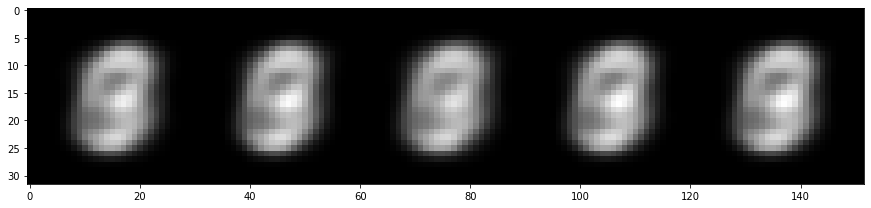

In [0]:
import torchvision

# random vector of mean
sample1 = torch.randn(5, 1, 20)
# random vector of variance
sample2 = torch.randn(5, 1, 20)

loader1 = torch.utils.data.DataLoader(sample1, batch_size=5, shuffle = False)
loader2 = torch.utils.data.DataLoader(sample2, batch_size=5, shuffle = False)

# get the 5 ouputs of the decoder
for mu,logvar in zip(loader1, loader2):
  rand_recon = model.reparametrize(mu,logvar)
  rand_recon = model.fc(rand_recon)
  rand_recon = model.decoder(rand_recon)
 
grid = utils.make_grid(rand_recon.detach().cpu(),nrow=5,normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)

# Optional Exercise B: Conditional GAN


In [0]:
torch.manual_seed(120)

# Architecture params and training hyperparams
gen_in_size = 100
dis_in_size = 28*28
gen_out_size = dis_in_size

hparams_gan = {
    'train_batch_size':32,
    'num_epochs':50,
    'learning_rate':1e-4
}

train_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams_gan['train_batch_size'], 
    shuffle=True)

num_batches = len(train_loader)

**Generator**

In [0]:
# Generator class
class Generator (nn.Module):
    def __init__(self,in_size,out_size):
        super(Generator,self).__init__()

        self.label_transf = nn.Embedding(10,10) # embedding of digit label (kind of one-hot vector)

        self.gen = nn.Sequential(
              nn.Linear(in_size+10, 256),
              nn.LeakyReLU(0.2), 
              nn.Linear(256,512),
              nn.LeakyReLU(0.2),
              nn.Linear(512,1024),
              nn.LeakyReLU(0.2),
              nn.Linear(1024,out_size),
              nn.Tanh()
          )

    def forward(self,x, labels):
        labels_emb = self.label_transf(labels)
        x = torch.cat([x,labels_emb], 1) # Concatenate image and label
        x = self.gen(x)
        return x

**Discriminator**

In [0]:
# Discriminator class
class Discriminator (nn.Module):
    def __init__(self,in_size,out_size):
        super(Discriminator,self).__init__()

        self.label_transf = nn.Embedding(10,10) # embedding of digit label (kind of one-hot vector)

        self.dis = nn.Sequential(
            nn.Linear(in_size+10, 1024),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Dropout(0.3),
            nn.Linear(256, out_size),
            nn.Sigmoid(),
        )

    def forward(self,x, labels):
        labels = self.label_transf(labels)

        x = torch.cat([x,labels], 1) # Concatenate image and label
        x = self.dis(x)
        return x

**Definition of generator, discriminator, optimizers and useful support functions**

In [0]:
# Notebook must run on GPU
assert torch.cuda.is_available(), 'This notebook is only compatible with cuda GPU'
hparams_gan['device'] = 'cuda'

# Declare generator and discriminator
generator = Generator(gen_in_size, gen_out_size)
discriminator = Discriminator(dis_in_size, 1)

# Binary cross entropy loss
loss = nn.BCELoss()

# Optimizers
gen_opt = optim.Adam(generator.parameters(), lr = hparams_gan['learning_rate'])
dis_opt = optim.Adam(discriminator.parameters(), lr = hparams_gan['learning_rate'])

In [0]:
def plot_output_gen(array_img, num = None):
  
  # take only the image, removing batch and channel index
  array_img = array_img.squeeze(0)
  array_img = array_img.squeeze(0)
  
  plt.imshow(array_img.cpu(), cmap = 'gray')
  plt.xticks([])
  plt.yticks([])
  if num:
      plt.xlabel(num,fontsize='x-large')
  plt.show()

def create_noise(size):
    n = Variable(torch.randn(size, 100)).cuda()
    return n

def create_fake_labels(size):
    data = Variable(torch.LongTensor(np.random.randint(0,10,size))).cuda()
    return data

def train_dis(real_inp, labels, fake_inp, fake_labels, dis_opt, num):
    discriminator.train()
    device = hparams_gan['device']

    dis_opt.zero_grad()

    # real images in discriminator
    prediction_real = discriminator.forward(real_inp, labels)
    dis_real_loss = loss(prediction_real, Variable(torch.ones(num, 1)).cuda())
    dis_real_loss.backward()

    # fake images in discriminator
    prediction_fake = discriminator(fake_inp, fake_labels)
    dis_fake_loss = loss(prediction_fake, Variable(torch.zeros(num, 1)).cuda())
    dis_fake_loss.backward()

    dis_opt.step()
    return dis_real_loss + dis_fake_loss , prediction_real, prediction_fake

def train_gen(fake_img, gen_opt, num):
      generator.train()
      device = hparams_gan['device']

      gen_opt.zero_grad()
      
      # fake labels
      fake_labels = create_fake_labels(num)
      # feed fake data in discriminator
      prediction = discriminator(fake_img, fake_labels)

      gen_train_loss = loss(prediction, Variable(torch.ones(num, 1)).cuda())
      gen_train_loss.backward()

      gen_opt.step()
      return gen_train_loss

def train_net(train_loader, gen_opt, dis_opt, num_epochs):
    gen_losses = []
    dis_losses = []
    generator.to(hparams_gan['device']) 
    discriminator.to(hparams_gan['device'])

    # noise used to display on a image during training
    test_noise = create_noise(1)

    # TRAIN
    for epoch in range(1,num_epochs + 1):
        for batch_idx, (real_img, labels) in enumerate(train_loader):
            num_real_images = real_img.size(0)
            
            #real images
            real_img = Variable(real_img.view(real_img.size(0), 28*28)).cuda()
            #real labels
            real_labels = Variable(labels).cuda()
            
            #fake labels
            fake_labels = create_fake_labels(num_real_images)
            #fake images generation
            fake_img = generator(create_noise(num_real_images), fake_labels).detach()

            disc_loss, d_pred_real, d_pred_fake = train_dis(real_img, real_labels, fake_img, fake_labels, dis_opt, num_real_images)

            fake_img = generator(create_noise(num_real_images),fake_labels)

            gen_loss = train_gen(fake_img, gen_opt, num_real_images)

            # print details during training
            if (batch_idx) % 100 == 0:
                print(f'Epoch {epoch}: Batch {batch_idx} Discrim loss {disc_loss}, Generator loss {gen_loss}')
                gen_losses.append(gen_loss)
                dis_losses.append(disc_loss)
                losses = {'gen_losses':gen_losses, 'dis_losses':dis_losses}
                
                label_to_display = Variable(torch.LongTensor([3])).cuda()
                test_images = generator(test_noise,label_to_display)
                test_images = test_images.view(test_images.size(0), 1, 28, 28)
                plot_output_gen(test_images.detach(), 3)

    # graph of loss per epoch
    plt.figure(figsize=(10, 8))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(gen_losses, label='generator')
    plt.plot(dis_losses, label='discriminator')
    plt.legend()

**Training and plot of results**

Epoch 1: Batch 0 Discrim loss 1.3934128284454346, Generator loss 0.7275660037994385


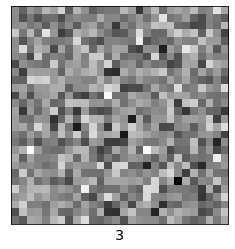

Epoch 1: Batch 100 Discrim loss 1.0024932622909546, Generator loss 0.7402184009552002


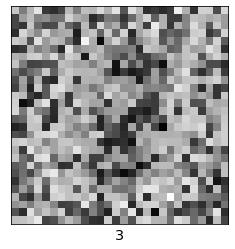

Epoch 1: Batch 200 Discrim loss 0.5067940950393677, Generator loss 1.5867087841033936


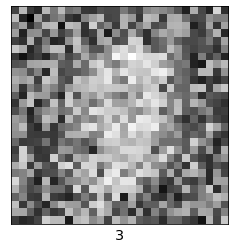

Epoch 1: Batch 300 Discrim loss 1.490651249885559, Generator loss 0.9661271572113037


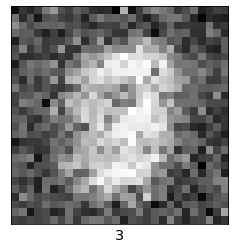

Epoch 1: Batch 400 Discrim loss 1.338498830795288, Generator loss 0.5758993625640869


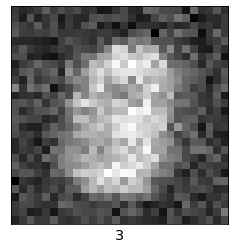

Epoch 1: Batch 500 Discrim loss 1.4060533046722412, Generator loss 0.5652436017990112


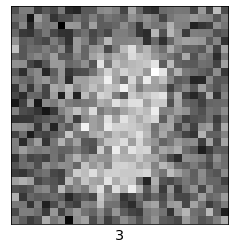

Epoch 1: Batch 600 Discrim loss 1.368598222732544, Generator loss 0.8165416717529297


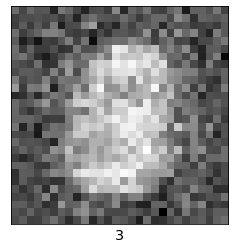

Epoch 1: Batch 700 Discrim loss 0.9577413201332092, Generator loss 1.5046590566635132


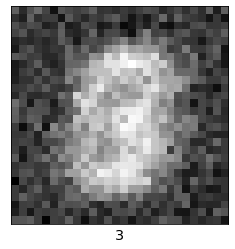

Epoch 1: Batch 800 Discrim loss 0.693248450756073, Generator loss 1.1968982219696045


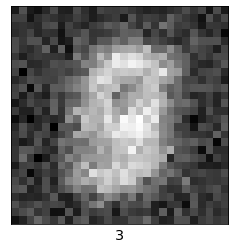

Epoch 1: Batch 900 Discrim loss 3.510700225830078, Generator loss 1.2308826446533203


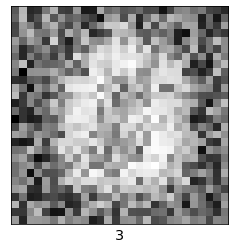

Epoch 1: Batch 1000 Discrim loss 0.8942863345146179, Generator loss 2.1668763160705566


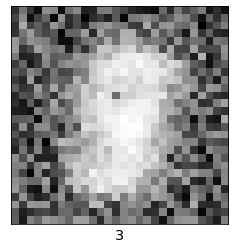

Epoch 1: Batch 1100 Discrim loss 1.0007777214050293, Generator loss 0.9979385137557983


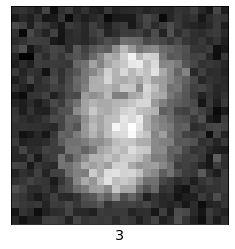

Epoch 1: Batch 1200 Discrim loss 0.9248248934745789, Generator loss 2.326368570327759


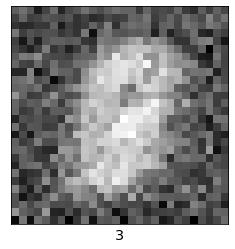

Epoch 1: Batch 1300 Discrim loss 0.7651752233505249, Generator loss 3.0434045791625977


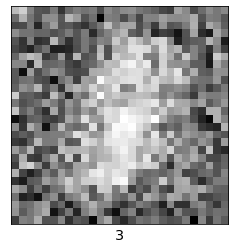

Epoch 1: Batch 1400 Discrim loss 0.9098663330078125, Generator loss 1.3557205200195312


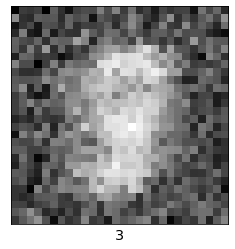

Epoch 1: Batch 1500 Discrim loss 0.41739606857299805, Generator loss 2.1885154247283936


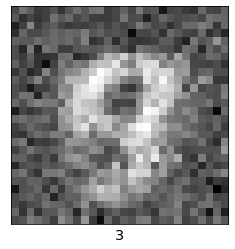

Epoch 1: Batch 1600 Discrim loss 2.270801067352295, Generator loss 1.7635325193405151


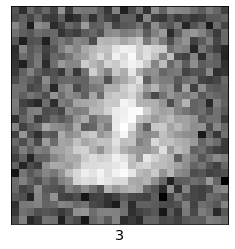

Epoch 1: Batch 1700 Discrim loss 0.5799079537391663, Generator loss 2.9311819076538086


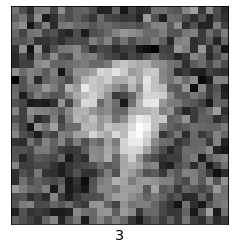

Epoch 1: Batch 1800 Discrim loss 0.4765651524066925, Generator loss 3.346248149871826


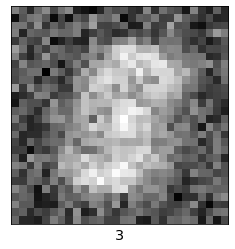

Epoch 2: Batch 0 Discrim loss 0.44877028465270996, Generator loss 2.030928611755371


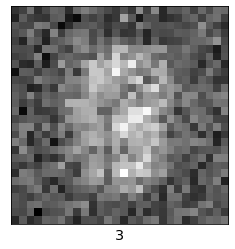

Epoch 2: Batch 100 Discrim loss 0.9791426658630371, Generator loss 3.55305552482605


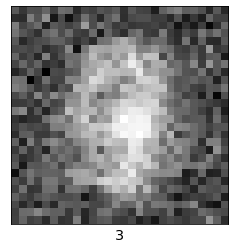

Epoch 2: Batch 200 Discrim loss 0.9936633706092834, Generator loss 2.4558117389678955


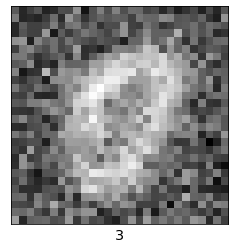

Epoch 2: Batch 300 Discrim loss 0.28463178873062134, Generator loss 2.1791324615478516


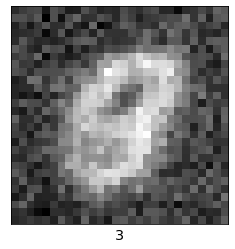

Epoch 2: Batch 400 Discrim loss 0.45829343795776367, Generator loss 2.7864160537719727


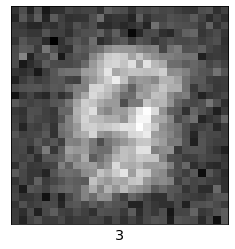

Epoch 2: Batch 500 Discrim loss 0.8804606199264526, Generator loss 1.857904076576233


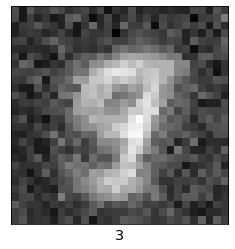

Epoch 2: Batch 600 Discrim loss 0.7834397554397583, Generator loss 2.778876304626465


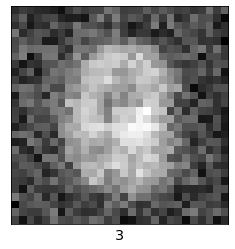

Epoch 2: Batch 700 Discrim loss 0.3573058247566223, Generator loss 3.4311611652374268


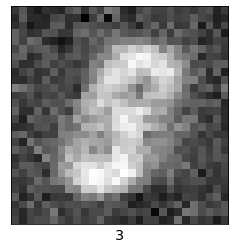

Epoch 2: Batch 800 Discrim loss 0.5534170269966125, Generator loss 2.8113622665405273


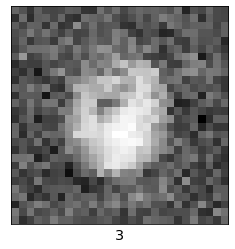

Epoch 2: Batch 900 Discrim loss 0.33969271183013916, Generator loss 2.3227710723876953


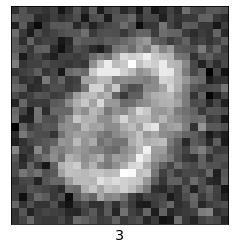

Epoch 2: Batch 1000 Discrim loss 0.32173770666122437, Generator loss 2.7168869972229004


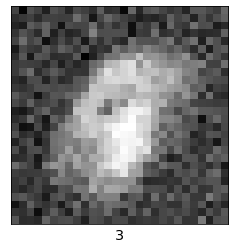

Epoch 2: Batch 1100 Discrim loss 0.2608710825443268, Generator loss 2.5533509254455566


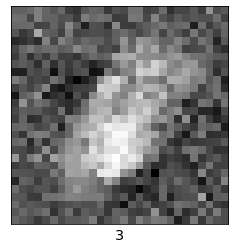

Epoch 2: Batch 1200 Discrim loss 0.33817827701568604, Generator loss 3.5184578895568848


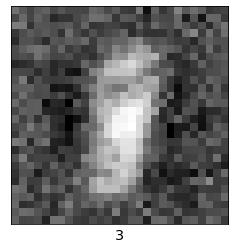

Epoch 2: Batch 1300 Discrim loss 0.7266845703125, Generator loss 3.9147281646728516


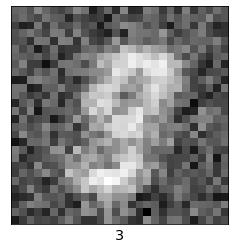

Epoch 2: Batch 1400 Discrim loss 0.535751461982727, Generator loss 3.819694995880127


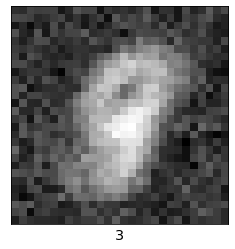

Epoch 2: Batch 1500 Discrim loss 0.350780189037323, Generator loss 2.358633041381836


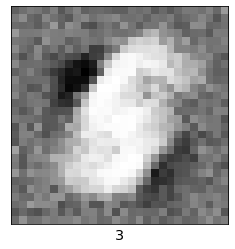

Epoch 2: Batch 1600 Discrim loss 0.3636894226074219, Generator loss 2.268594264984131


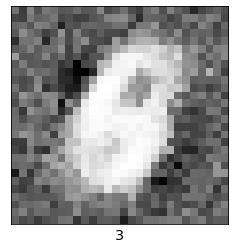

Epoch 2: Batch 1700 Discrim loss 0.6477270126342773, Generator loss 2.8941426277160645


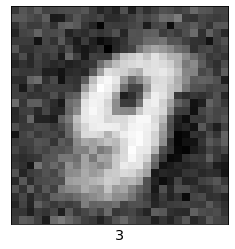

Epoch 2: Batch 1800 Discrim loss 0.38443198800086975, Generator loss 2.9791746139526367


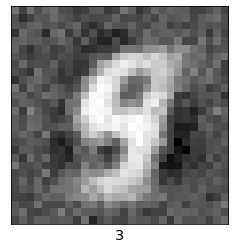

Epoch 3: Batch 0 Discrim loss 0.6393156051635742, Generator loss 3.3543834686279297


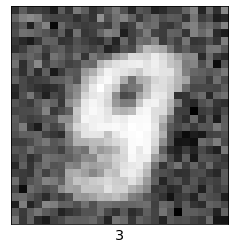

Epoch 3: Batch 100 Discrim loss 0.26015132665634155, Generator loss 2.8882343769073486


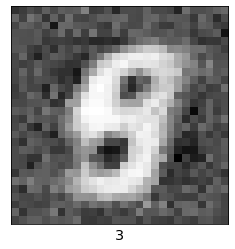

Epoch 3: Batch 200 Discrim loss 0.4672882854938507, Generator loss 2.3913917541503906


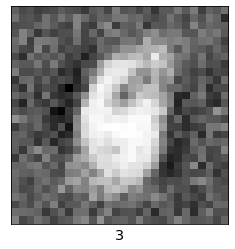

Epoch 3: Batch 300 Discrim loss 0.3638758659362793, Generator loss 2.4922969341278076


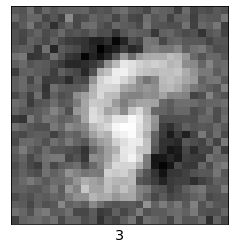

Epoch 3: Batch 400 Discrim loss 0.32735949754714966, Generator loss 3.542001247406006


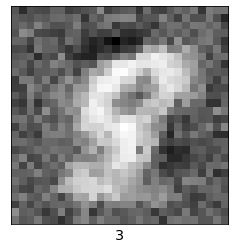

Epoch 3: Batch 500 Discrim loss 0.4660528898239136, Generator loss 2.3675832748413086


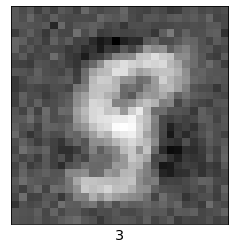

Epoch 3: Batch 600 Discrim loss 0.24097615480422974, Generator loss 2.5850167274475098


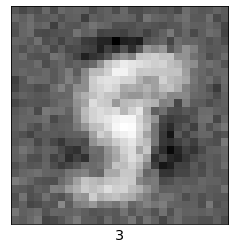

Epoch 3: Batch 700 Discrim loss 0.3770466446876526, Generator loss 3.4220402240753174


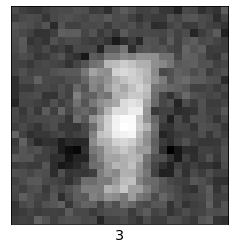

Epoch 3: Batch 800 Discrim loss 0.33777013421058655, Generator loss 3.461164951324463


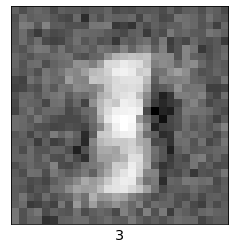

Epoch 3: Batch 900 Discrim loss 0.5024428963661194, Generator loss 2.616621494293213


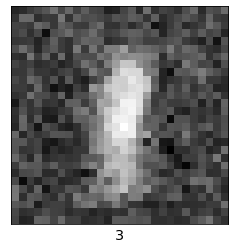

Epoch 3: Batch 1000 Discrim loss 0.12073228508234024, Generator loss 3.322605609893799


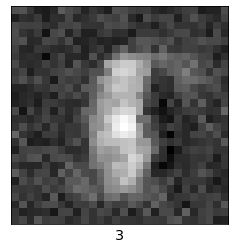

Epoch 3: Batch 1100 Discrim loss 0.13187193870544434, Generator loss 3.283348321914673


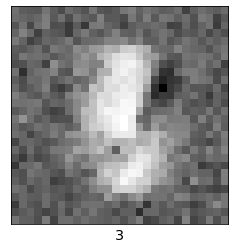

Epoch 3: Batch 1200 Discrim loss 0.2776077389717102, Generator loss 2.488502025604248


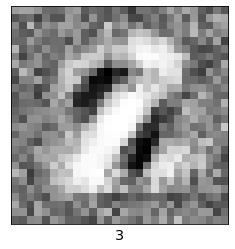

Epoch 3: Batch 1300 Discrim loss 0.2919190227985382, Generator loss 3.078603744506836


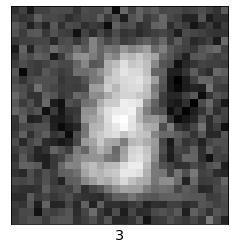

Epoch 3: Batch 1400 Discrim loss 0.23818030953407288, Generator loss 3.651965618133545


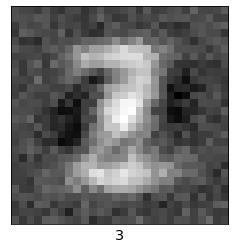

Epoch 3: Batch 1500 Discrim loss 0.3904866576194763, Generator loss 2.8374199867248535


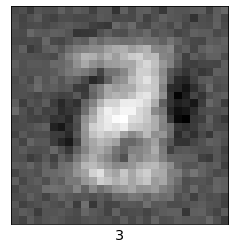

Epoch 3: Batch 1600 Discrim loss 0.6910034418106079, Generator loss 2.9812052249908447


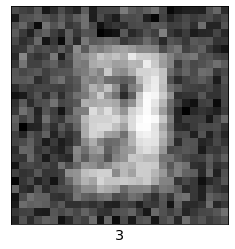

Epoch 3: Batch 1700 Discrim loss 0.5540963411331177, Generator loss 2.8305716514587402


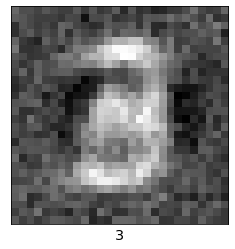

Epoch 3: Batch 1800 Discrim loss 0.24597075581550598, Generator loss 3.703981637954712


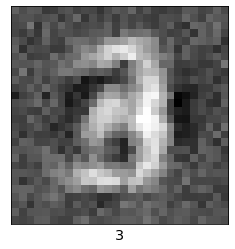

Epoch 4: Batch 0 Discrim loss 0.3578830361366272, Generator loss 3.662508010864258


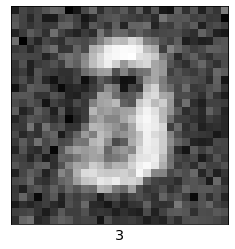

Epoch 4: Batch 100 Discrim loss 0.44842180609703064, Generator loss 4.488412857055664


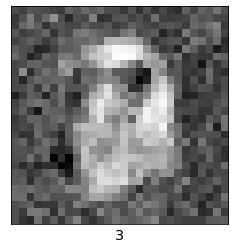

Epoch 4: Batch 200 Discrim loss 0.4667021930217743, Generator loss 4.149867057800293


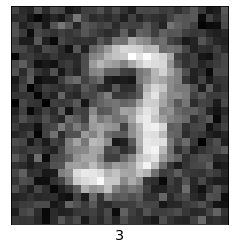

Epoch 4: Batch 300 Discrim loss 0.35758838057518005, Generator loss 3.759638786315918


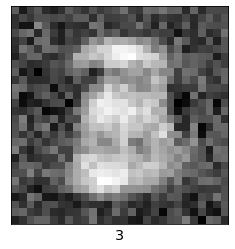

Epoch 4: Batch 400 Discrim loss 0.4132317900657654, Generator loss 2.47550630569458


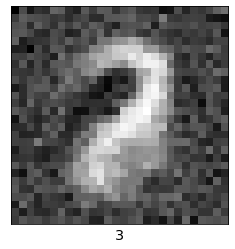

Epoch 4: Batch 500 Discrim loss 0.17537933588027954, Generator loss 3.433656692504883


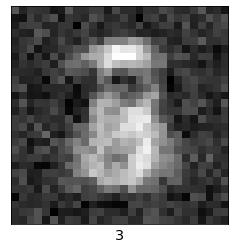

Epoch 4: Batch 600 Discrim loss 0.21945695579051971, Generator loss 3.9178857803344727


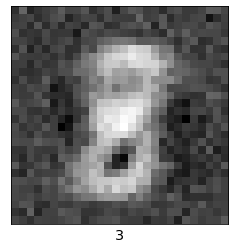

Epoch 4: Batch 700 Discrim loss 0.13937261700630188, Generator loss 3.1726725101470947


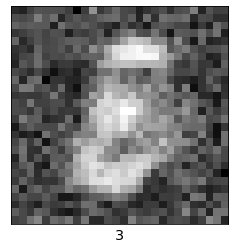

Epoch 4: Batch 800 Discrim loss 0.35475069284439087, Generator loss 3.2296736240386963


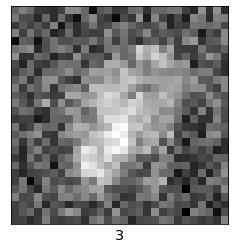

Epoch 4: Batch 900 Discrim loss 0.2788305878639221, Generator loss 3.762995719909668


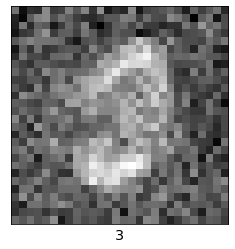

Epoch 4: Batch 1000 Discrim loss 0.21538174152374268, Generator loss 4.524264335632324


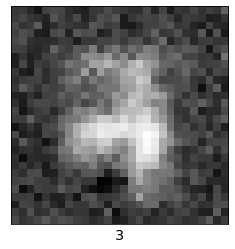

Epoch 4: Batch 1100 Discrim loss 0.24641770124435425, Generator loss 2.354814291000366


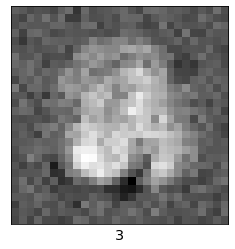

Epoch 4: Batch 1200 Discrim loss 0.49714890122413635, Generator loss 3.6642637252807617


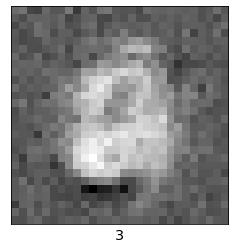

Epoch 4: Batch 1300 Discrim loss 0.22476351261138916, Generator loss 3.4538393020629883


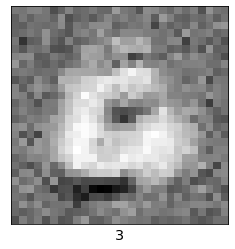

Epoch 4: Batch 1400 Discrim loss 0.2049994170665741, Generator loss 2.863673210144043


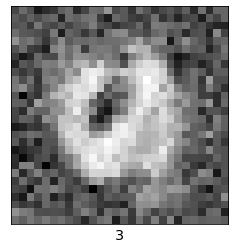

Epoch 4: Batch 1500 Discrim loss 0.2135545164346695, Generator loss 4.247179985046387


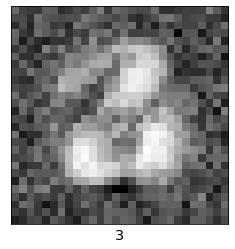

Epoch 4: Batch 1600 Discrim loss 0.3458365201950073, Generator loss 2.8246941566467285


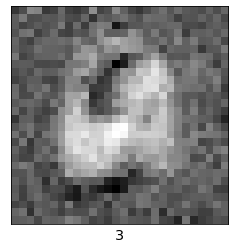

Epoch 4: Batch 1700 Discrim loss 0.2434636652469635, Generator loss 3.4280083179473877


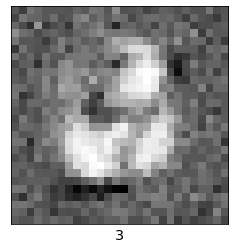

Epoch 4: Batch 1800 Discrim loss 0.2639874219894409, Generator loss 2.7958168983459473


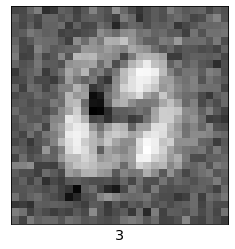

Epoch 5: Batch 0 Discrim loss 0.39104247093200684, Generator loss 3.0188279151916504


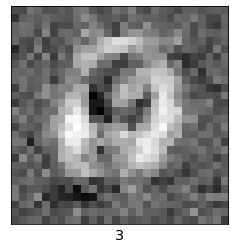

Epoch 5: Batch 100 Discrim loss 0.1525212526321411, Generator loss 3.5982909202575684


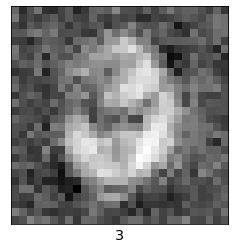

Epoch 5: Batch 200 Discrim loss 0.2562275230884552, Generator loss 3.587958812713623


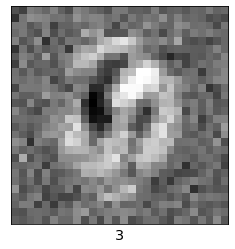

Epoch 5: Batch 300 Discrim loss 0.28020718693733215, Generator loss 3.592005729675293


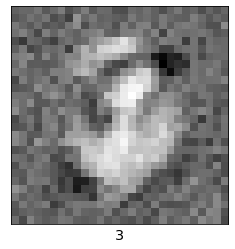

Epoch 5: Batch 400 Discrim loss 0.14406609535217285, Generator loss 3.787292957305908


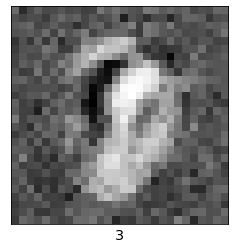

Epoch 5: Batch 500 Discrim loss 0.24588602781295776, Generator loss 3.719202995300293


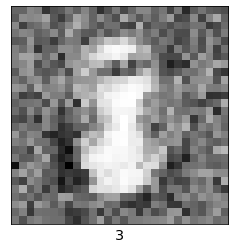

Epoch 5: Batch 600 Discrim loss 0.22810891270637512, Generator loss 3.650395154953003


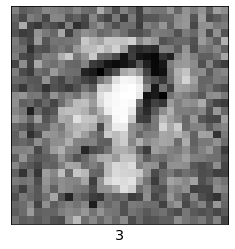

Epoch 5: Batch 700 Discrim loss 0.1789354383945465, Generator loss 4.305307865142822


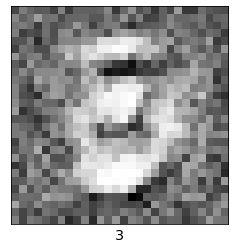

Epoch 5: Batch 800 Discrim loss 0.27574393153190613, Generator loss 3.951470375061035


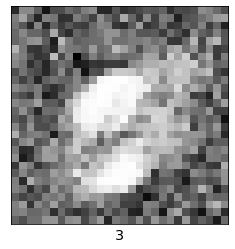

Epoch 5: Batch 900 Discrim loss 0.11272245645523071, Generator loss 3.132429361343384


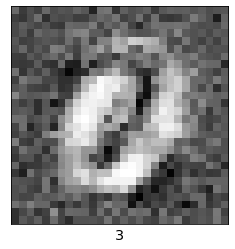

Epoch 5: Batch 1000 Discrim loss 0.14082175493240356, Generator loss 3.9875247478485107


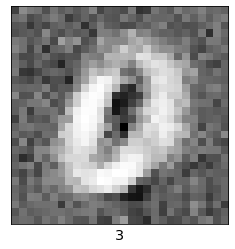

Epoch 5: Batch 1100 Discrim loss 0.2502431869506836, Generator loss 2.862053871154785


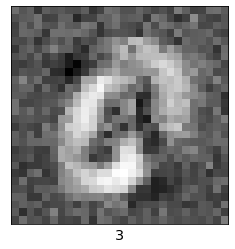

Epoch 5: Batch 1200 Discrim loss 0.3433331847190857, Generator loss 3.13630747795105


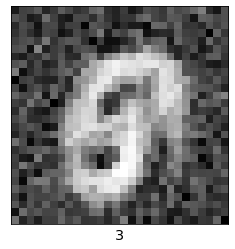

Epoch 5: Batch 1300 Discrim loss 0.2987288236618042, Generator loss 3.458883762359619


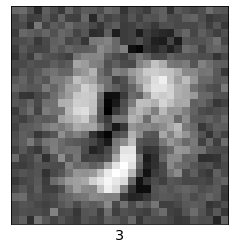

Epoch 5: Batch 1400 Discrim loss 0.2040698230266571, Generator loss 4.405388832092285


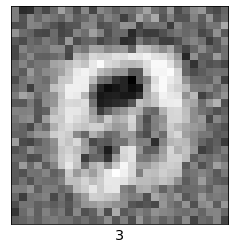

Epoch 5: Batch 1500 Discrim loss 0.11619875580072403, Generator loss 3.5457444190979004


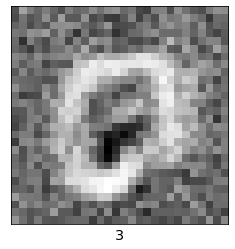

Epoch 5: Batch 1600 Discrim loss 0.530068576335907, Generator loss 4.070319652557373


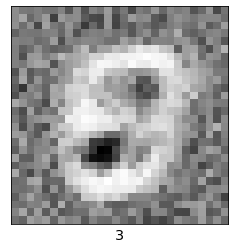

Epoch 5: Batch 1700 Discrim loss 0.13431045413017273, Generator loss 3.085433006286621


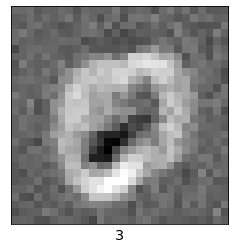

Epoch 5: Batch 1800 Discrim loss 0.10461992025375366, Generator loss 3.3038461208343506


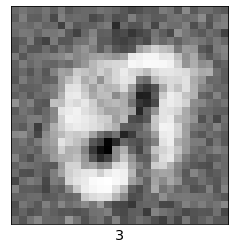

Epoch 6: Batch 0 Discrim loss 0.10358661413192749, Generator loss 3.5766947269439697


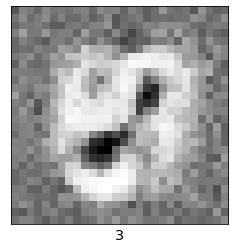

Epoch 6: Batch 100 Discrim loss 0.3109573721885681, Generator loss 3.75105619430542


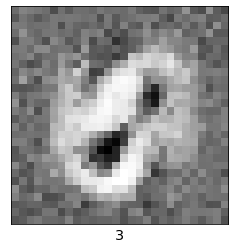

Epoch 6: Batch 200 Discrim loss 0.31631141901016235, Generator loss 4.210862159729004


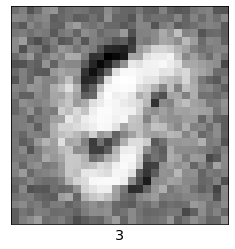

Epoch 6: Batch 300 Discrim loss 0.08543648570775986, Generator loss 3.630612373352051


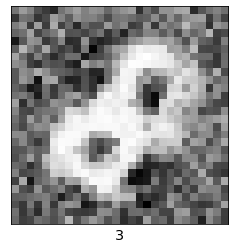

Epoch 6: Batch 400 Discrim loss 0.33181092143058777, Generator loss 3.462428569793701


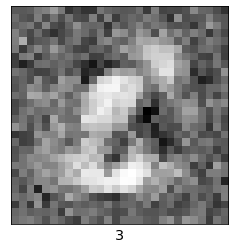

Epoch 6: Batch 500 Discrim loss 0.4549388289451599, Generator loss 2.786574125289917


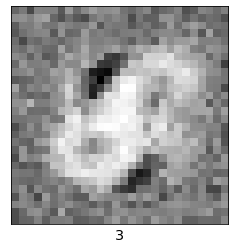

Epoch 6: Batch 600 Discrim loss 0.1694704294204712, Generator loss 3.9291484355926514


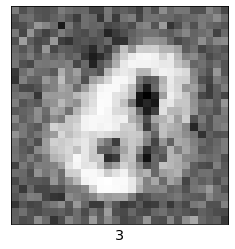

Epoch 6: Batch 700 Discrim loss 0.44115492701530457, Generator loss 2.8789010047912598


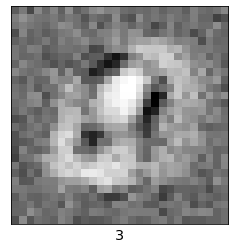

Epoch 6: Batch 800 Discrim loss 0.20610953867435455, Generator loss 3.646700620651245


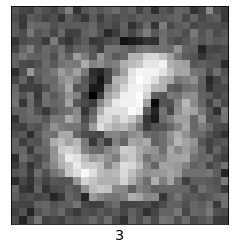

Epoch 6: Batch 900 Discrim loss 0.05643848329782486, Generator loss 2.3161604404449463


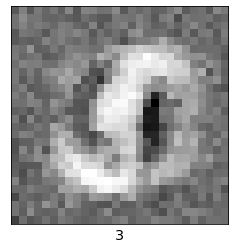

Epoch 6: Batch 1000 Discrim loss 0.3013118505477905, Generator loss 3.965015172958374


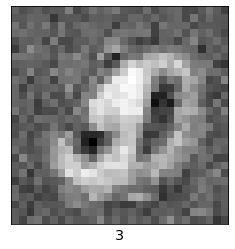

Epoch 6: Batch 1100 Discrim loss 0.17354272305965424, Generator loss 3.6488099098205566


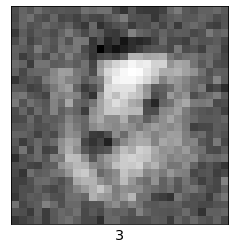

Epoch 6: Batch 1200 Discrim loss 0.17116960883140564, Generator loss 3.3394250869750977


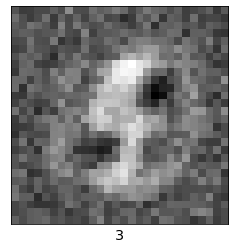

Epoch 6: Batch 1300 Discrim loss 0.12036474049091339, Generator loss 4.509755611419678


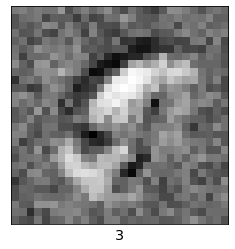

Epoch 6: Batch 1400 Discrim loss 0.36792466044425964, Generator loss 3.848482847213745


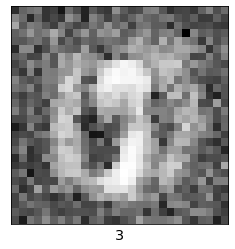

Epoch 6: Batch 1500 Discrim loss 0.24056631326675415, Generator loss 3.2692365646362305


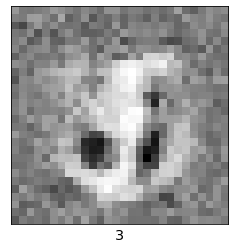

Epoch 6: Batch 1600 Discrim loss 0.5154565572738647, Generator loss 4.200464725494385


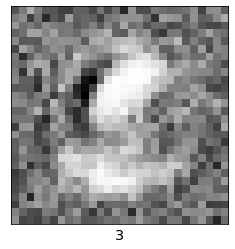

Epoch 6: Batch 1700 Discrim loss 0.12198470532894135, Generator loss 4.448705196380615


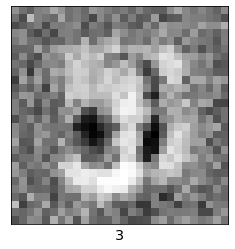

Epoch 6: Batch 1800 Discrim loss 0.22329670190811157, Generator loss 3.7220096588134766


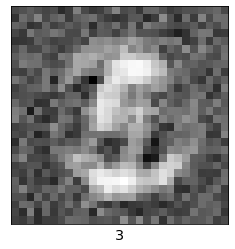

Epoch 7: Batch 0 Discrim loss 0.10557155311107635, Generator loss 4.084782600402832


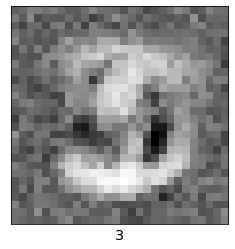

Epoch 7: Batch 100 Discrim loss 0.4591025114059448, Generator loss 3.575658082962036


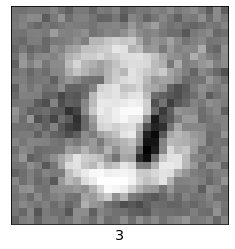

Epoch 7: Batch 200 Discrim loss 0.1069357693195343, Generator loss 4.196706771850586


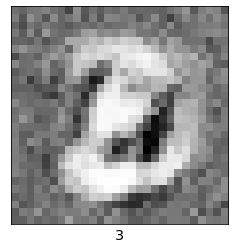

Epoch 7: Batch 300 Discrim loss 0.22603529691696167, Generator loss 3.489872932434082


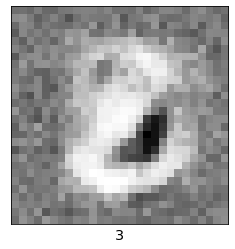

Epoch 7: Batch 400 Discrim loss 0.33649781346321106, Generator loss 3.6158416271209717


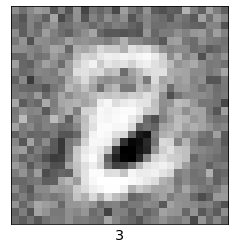

Epoch 7: Batch 500 Discrim loss 0.558853030204773, Generator loss 3.1289076805114746


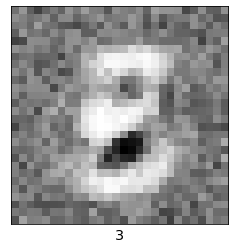

Epoch 7: Batch 600 Discrim loss 0.34329313039779663, Generator loss 2.8653860092163086


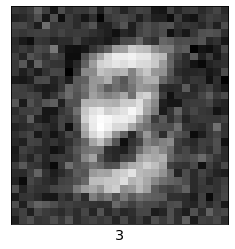

Epoch 7: Batch 700 Discrim loss 0.12406148761510849, Generator loss 3.357832431793213


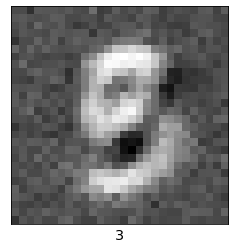

Epoch 7: Batch 800 Discrim loss 0.4119499623775482, Generator loss 4.132690906524658


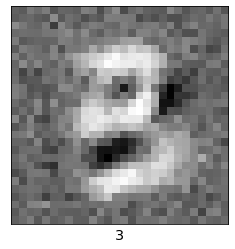

Epoch 7: Batch 900 Discrim loss 0.1930713653564453, Generator loss 4.307356834411621


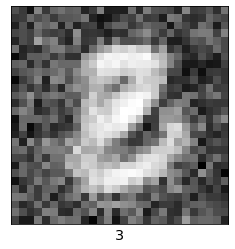

Epoch 7: Batch 1000 Discrim loss 0.4868685305118561, Generator loss 3.061713457107544


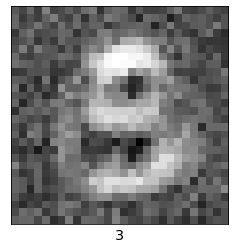

Epoch 7: Batch 1100 Discrim loss 0.17150437831878662, Generator loss 3.866331100463867


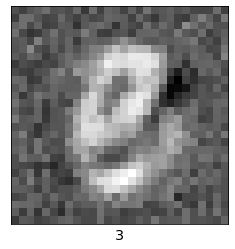

Epoch 7: Batch 1200 Discrim loss 0.24069622159004211, Generator loss 4.832071304321289


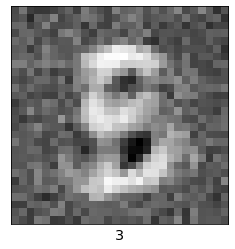

Epoch 7: Batch 1300 Discrim loss 0.18143805861473083, Generator loss 2.711393117904663


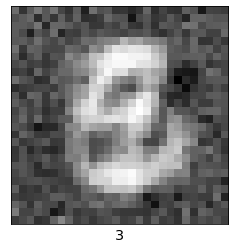

Epoch 7: Batch 1400 Discrim loss 0.08209855854511261, Generator loss 3.3563733100891113


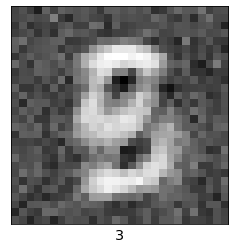

Epoch 7: Batch 1500 Discrim loss 0.15860489010810852, Generator loss 3.6450185775756836


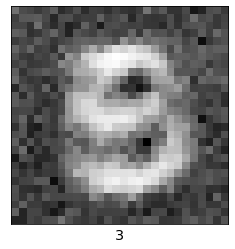

Epoch 7: Batch 1600 Discrim loss 0.23404164612293243, Generator loss 4.534963607788086


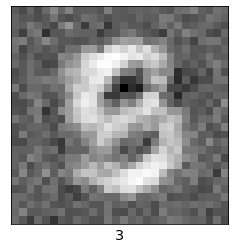

Epoch 7: Batch 1700 Discrim loss 0.1939263492822647, Generator loss 3.2674105167388916


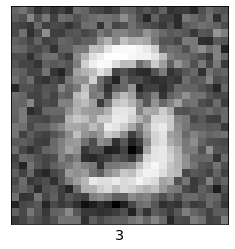

Epoch 7: Batch 1800 Discrim loss 0.31122326850891113, Generator loss 4.2200775146484375


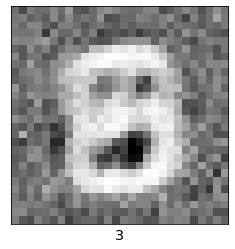

Epoch 8: Batch 0 Discrim loss 0.27195030450820923, Generator loss 2.494537115097046


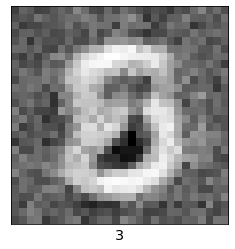

Epoch 8: Batch 100 Discrim loss 0.18743036687374115, Generator loss 2.9328105449676514


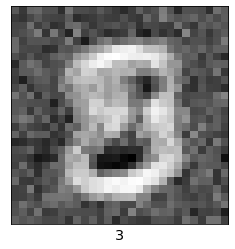

Epoch 8: Batch 200 Discrim loss 0.11724214255809784, Generator loss 3.7266387939453125


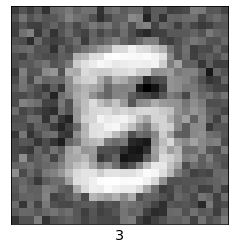

Epoch 8: Batch 300 Discrim loss 0.13775044679641724, Generator loss 2.2014622688293457


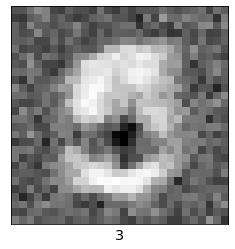

Epoch 8: Batch 400 Discrim loss 0.11977702379226685, Generator loss 3.715592384338379


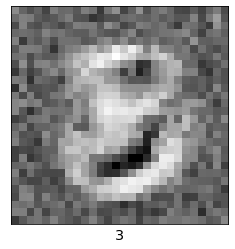

Epoch 8: Batch 500 Discrim loss 0.11220908164978027, Generator loss 3.2122626304626465


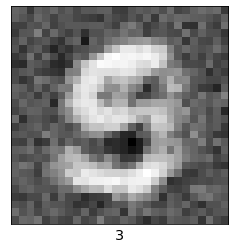

Epoch 8: Batch 600 Discrim loss 0.15479451417922974, Generator loss 4.115372657775879


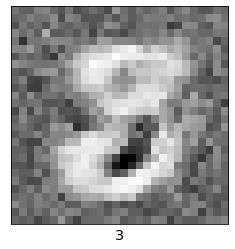

Epoch 8: Batch 700 Discrim loss 0.09335818886756897, Generator loss 2.5006508827209473


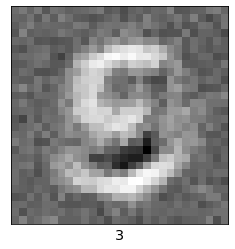

Epoch 8: Batch 800 Discrim loss 0.3604157269001007, Generator loss 3.59645414352417


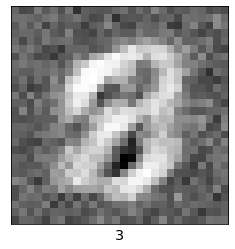

Epoch 8: Batch 900 Discrim loss 0.2440081238746643, Generator loss 2.962984561920166


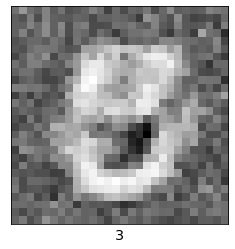

Epoch 8: Batch 1000 Discrim loss 0.08454502373933792, Generator loss 3.010669231414795


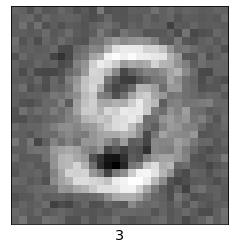

Epoch 8: Batch 1100 Discrim loss 0.2666153907775879, Generator loss 4.117667198181152


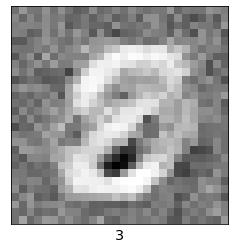

Epoch 8: Batch 1200 Discrim loss 0.08567683398723602, Generator loss 3.8125877380371094


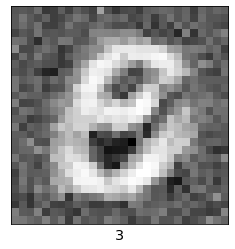

Epoch 8: Batch 1300 Discrim loss 0.3155924081802368, Generator loss 2.749946117401123


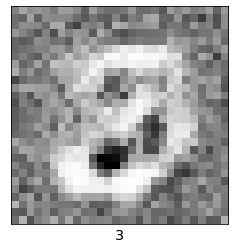

Epoch 8: Batch 1400 Discrim loss 0.2781003415584564, Generator loss 3.6573526859283447


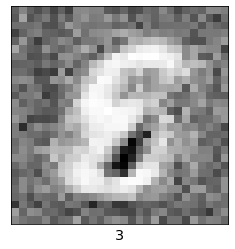

Epoch 8: Batch 1500 Discrim loss 0.2570040225982666, Generator loss 3.392456531524658


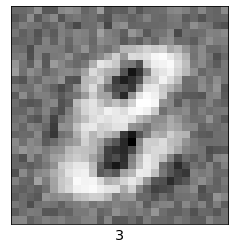

Epoch 8: Batch 1600 Discrim loss 0.08053507655858994, Generator loss 3.076716899871826


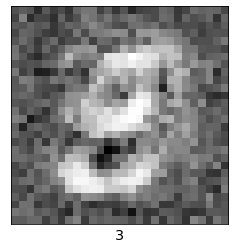

Epoch 8: Batch 1700 Discrim loss 0.14728319644927979, Generator loss 3.205247163772583


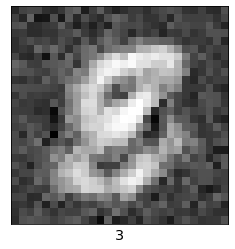

Epoch 8: Batch 1800 Discrim loss 0.07277226448059082, Generator loss 2.309319019317627


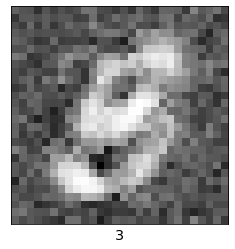

Epoch 9: Batch 0 Discrim loss 0.3016107976436615, Generator loss 2.7427220344543457


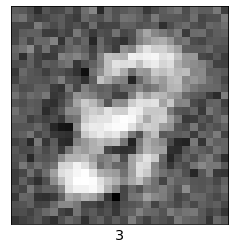

Epoch 9: Batch 100 Discrim loss 0.13052503764629364, Generator loss 2.739448308944702


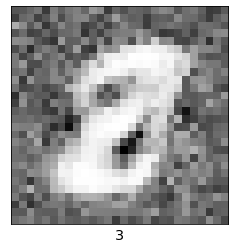

Epoch 9: Batch 200 Discrim loss 0.09811292588710785, Generator loss 3.105152130126953


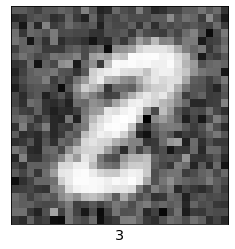

Epoch 9: Batch 300 Discrim loss 0.09407641738653183, Generator loss 3.220219135284424


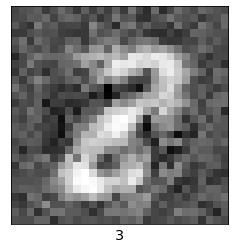

Epoch 9: Batch 400 Discrim loss 0.4226890504360199, Generator loss 3.222688913345337


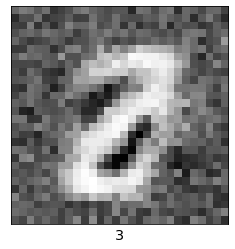

Epoch 9: Batch 500 Discrim loss 0.1432265192270279, Generator loss 2.8085250854492188


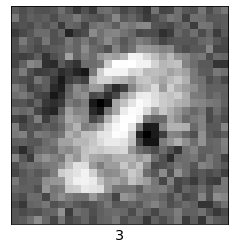

Epoch 9: Batch 600 Discrim loss 0.22471629083156586, Generator loss 1.8623327016830444


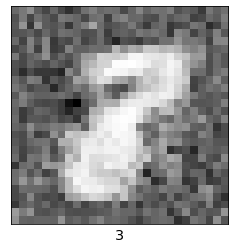

Epoch 9: Batch 700 Discrim loss 0.07379809767007828, Generator loss 2.975797653198242


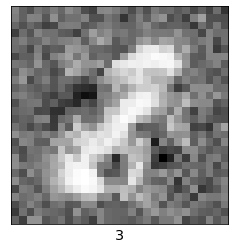

Epoch 9: Batch 800 Discrim loss 0.3249353766441345, Generator loss 4.311225891113281


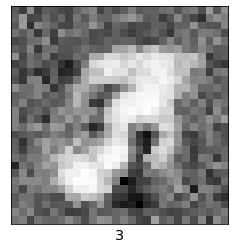

Epoch 9: Batch 900 Discrim loss 0.1805172860622406, Generator loss 2.411198616027832


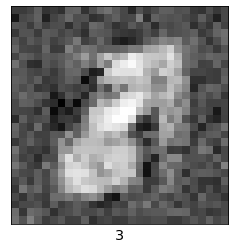

Epoch 9: Batch 1000 Discrim loss 0.09038393199443817, Generator loss 2.738354206085205


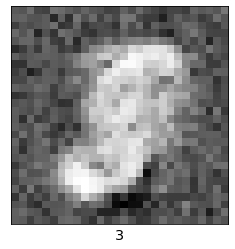

Epoch 9: Batch 1100 Discrim loss 0.027766093611717224, Generator loss 2.1149487495422363


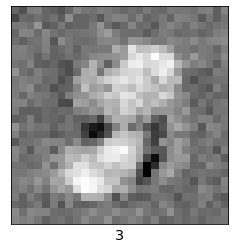

Epoch 9: Batch 1200 Discrim loss 0.18096330761909485, Generator loss 2.656567335128784


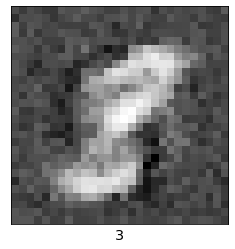

Epoch 9: Batch 1300 Discrim loss 0.2771456837654114, Generator loss 3.5520684719085693


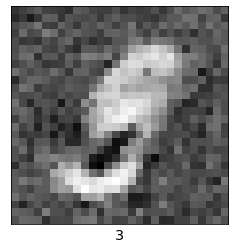

Epoch 9: Batch 1400 Discrim loss 0.3358173966407776, Generator loss 4.088705539703369


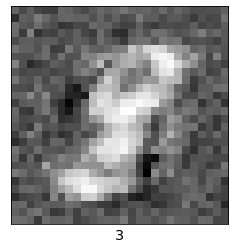

Epoch 9: Batch 1500 Discrim loss 0.19997158646583557, Generator loss 2.5332119464874268


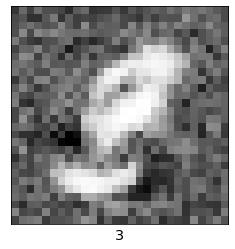

Epoch 9: Batch 1600 Discrim loss 0.17971163988113403, Generator loss 2.6671524047851562


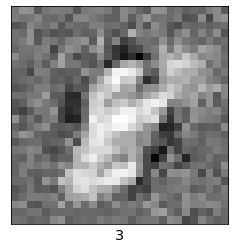

Epoch 9: Batch 1700 Discrim loss 0.21937188506126404, Generator loss 1.9804027080535889


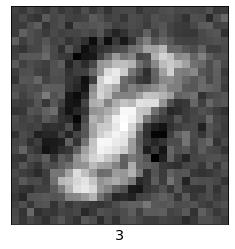

Epoch 9: Batch 1800 Discrim loss 0.11848796904087067, Generator loss 1.6403146982192993


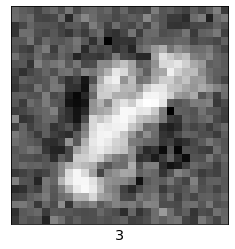

Epoch 10: Batch 0 Discrim loss 0.15838664770126343, Generator loss 2.4969496726989746


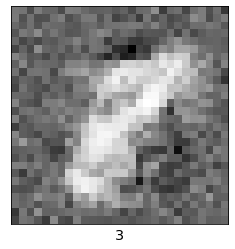

Epoch 10: Batch 100 Discrim loss 0.05675831809639931, Generator loss 2.9136791229248047


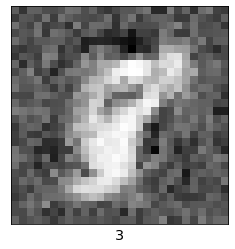

Epoch 10: Batch 200 Discrim loss 0.04158027097582817, Generator loss 3.197148561477661


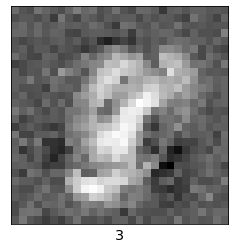

Epoch 10: Batch 300 Discrim loss 0.12167558073997498, Generator loss 4.019294738769531


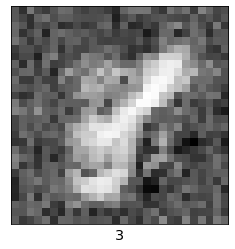

Epoch 10: Batch 400 Discrim loss 0.03760109469294548, Generator loss 1.7542672157287598


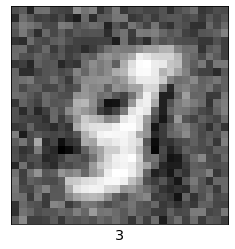

Epoch 10: Batch 500 Discrim loss 0.05597507581114769, Generator loss 2.5292258262634277


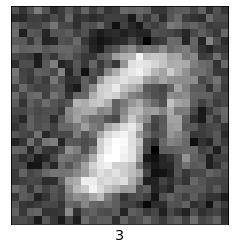

Epoch 10: Batch 600 Discrim loss 0.06644715368747711, Generator loss 2.3798727989196777


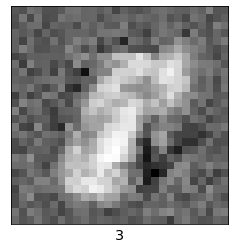

Epoch 10: Batch 700 Discrim loss 0.2393038272857666, Generator loss 2.0876290798187256


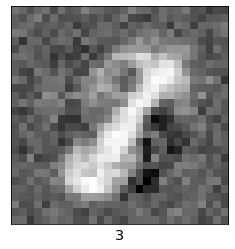

Epoch 10: Batch 800 Discrim loss 0.1422947347164154, Generator loss 2.188687562942505


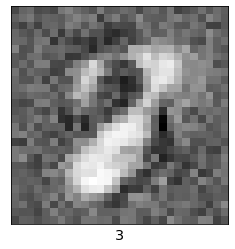

Epoch 10: Batch 900 Discrim loss 0.009446075186133385, Generator loss 2.6734366416931152


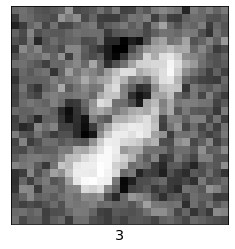

Epoch 10: Batch 1000 Discrim loss 0.08825685828924179, Generator loss 1.7998095750808716


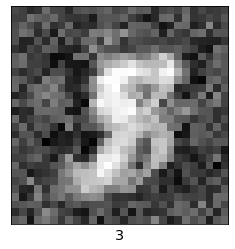

Epoch 10: Batch 1100 Discrim loss 0.12454764544963837, Generator loss 2.9264891147613525


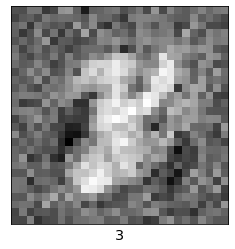

Epoch 10: Batch 1200 Discrim loss 0.10643071681261063, Generator loss 2.6989059448242188


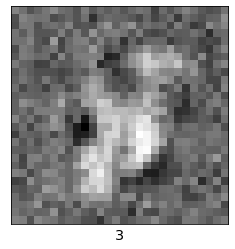

Epoch 10: Batch 1300 Discrim loss 0.16549353301525116, Generator loss 3.4573898315429688


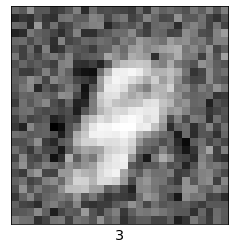

Epoch 10: Batch 1400 Discrim loss 0.034201815724372864, Generator loss 2.47816801071167


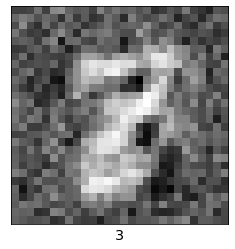

Epoch 10: Batch 1500 Discrim loss 0.09255461394786835, Generator loss 1.529132604598999


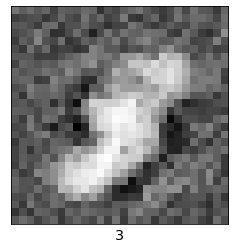

Epoch 10: Batch 1600 Discrim loss 0.17475059628486633, Generator loss 2.9963722229003906


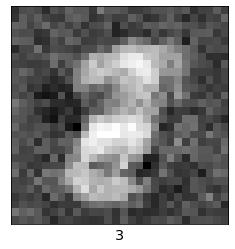

Epoch 10: Batch 1700 Discrim loss 0.07899564504623413, Generator loss 1.7385685443878174


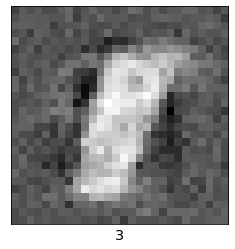

Epoch 10: Batch 1800 Discrim loss 0.2702654302120209, Generator loss 1.9904719591140747


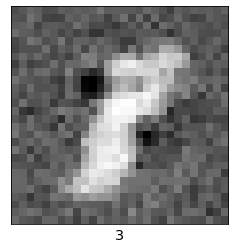

Epoch 11: Batch 0 Discrim loss 0.012382465414702892, Generator loss 2.0184342861175537


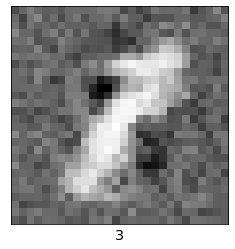

Epoch 11: Batch 100 Discrim loss 0.018738210201263428, Generator loss 3.659747838973999


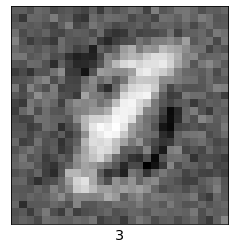

Epoch 11: Batch 200 Discrim loss 0.3570704460144043, Generator loss 2.645509719848633


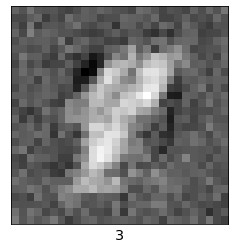

Epoch 11: Batch 300 Discrim loss 0.17109793424606323, Generator loss 2.645993232727051


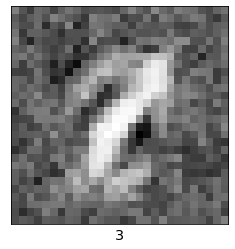

Epoch 11: Batch 400 Discrim loss 0.1341765969991684, Generator loss 1.005990982055664


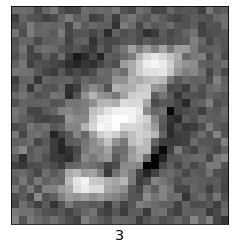

Epoch 11: Batch 500 Discrim loss 0.13968580961227417, Generator loss 0.9326955080032349


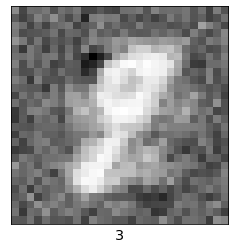

Epoch 11: Batch 600 Discrim loss 0.045020490884780884, Generator loss 2.414151191711426


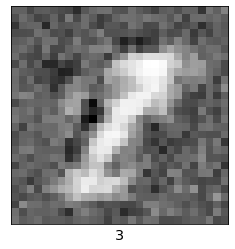

Epoch 11: Batch 700 Discrim loss 0.16560283303260803, Generator loss 2.1692678928375244


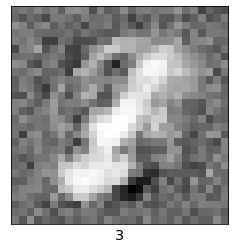

Epoch 11: Batch 800 Discrim loss 0.09754621982574463, Generator loss 2.2645435333251953


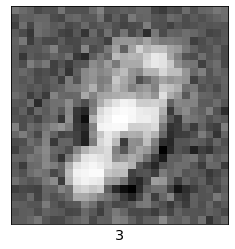

Epoch 11: Batch 900 Discrim loss 0.03315560519695282, Generator loss 1.4453797340393066


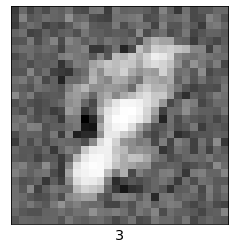

Epoch 11: Batch 1000 Discrim loss 0.12122055143117905, Generator loss 0.9512909650802612


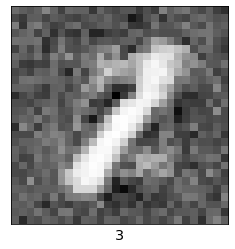

Epoch 11: Batch 1100 Discrim loss 0.04053550213575363, Generator loss 1.9376808404922485


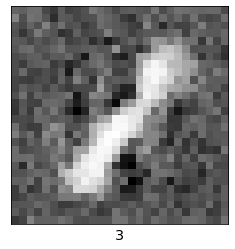

Epoch 11: Batch 1200 Discrim loss 0.10212810337543488, Generator loss 1.8305838108062744


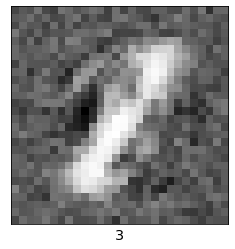

Epoch 11: Batch 1300 Discrim loss 0.02871841751039028, Generator loss 1.4952356815338135


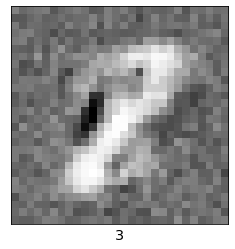

Epoch 11: Batch 1400 Discrim loss 0.04000493139028549, Generator loss 1.6326773166656494


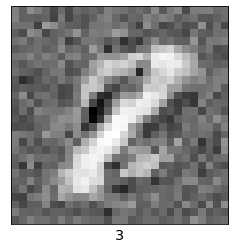

Epoch 11: Batch 1500 Discrim loss 0.017160773277282715, Generator loss 1.8615005016326904


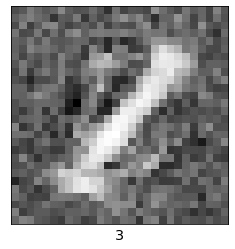

Epoch 11: Batch 1600 Discrim loss 0.07841946929693222, Generator loss 1.2446253299713135


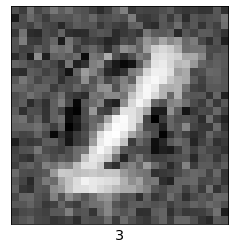

Epoch 11: Batch 1700 Discrim loss 0.02978711761534214, Generator loss 1.6081743240356445


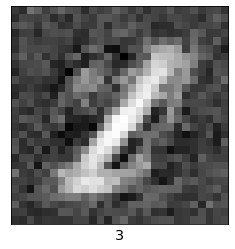

Epoch 11: Batch 1800 Discrim loss 0.08020637184381485, Generator loss 2.0765810012817383


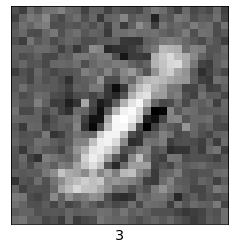

Epoch 12: Batch 0 Discrim loss 0.008588459342718124, Generator loss 3.506378412246704


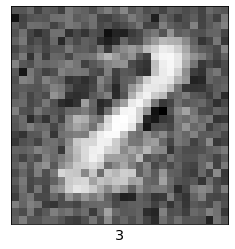

Epoch 12: Batch 100 Discrim loss 0.08878020942211151, Generator loss 1.622255802154541


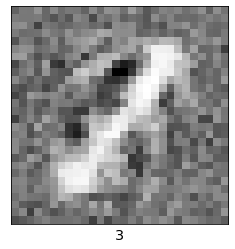

Epoch 12: Batch 200 Discrim loss 0.011929027736186981, Generator loss 1.6188498735427856


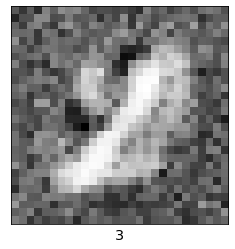

Epoch 12: Batch 300 Discrim loss 0.12160497903823853, Generator loss 3.3113722801208496


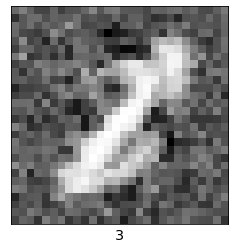

Epoch 12: Batch 400 Discrim loss 0.14005079865455627, Generator loss 1.519758939743042


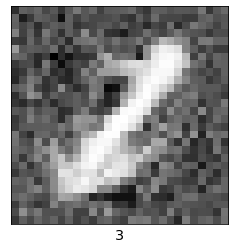

Epoch 12: Batch 500 Discrim loss 0.007735400460660458, Generator loss 3.2865896224975586


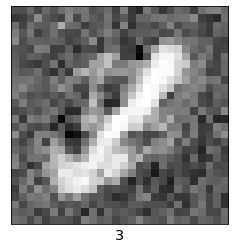

Epoch 12: Batch 600 Discrim loss 0.13906243443489075, Generator loss 1.7906901836395264


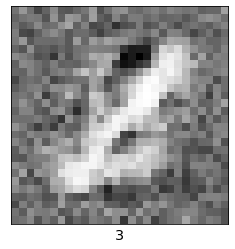

Epoch 12: Batch 700 Discrim loss 0.07233819365501404, Generator loss 1.5535786151885986


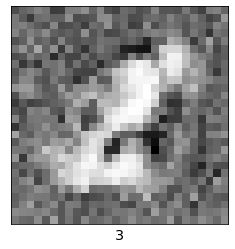

Epoch 12: Batch 800 Discrim loss 0.014485574327409267, Generator loss 2.7700209617614746


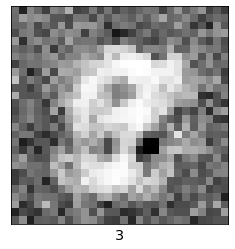

Epoch 12: Batch 900 Discrim loss 0.1115759015083313, Generator loss 1.9496235847473145


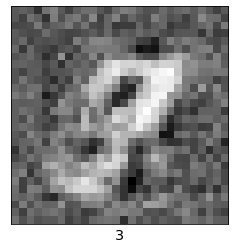

Epoch 12: Batch 1000 Discrim loss 0.011984361335635185, Generator loss 2.0304508209228516


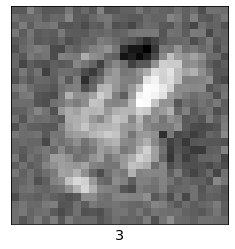

Epoch 12: Batch 1100 Discrim loss 0.0445849634706974, Generator loss 2.261181354522705


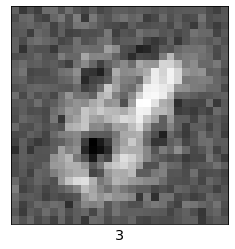

Epoch 12: Batch 1200 Discrim loss 0.053404390811920166, Generator loss 2.053719997406006


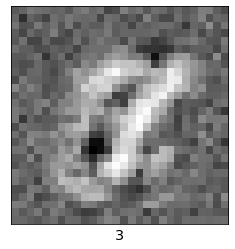

Epoch 12: Batch 1300 Discrim loss 0.021519940346479416, Generator loss 1.6083896160125732


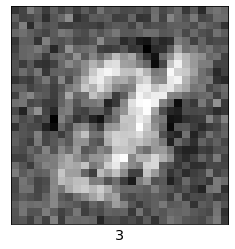

Epoch 12: Batch 1400 Discrim loss 0.0054817297495901585, Generator loss 2.515289068222046


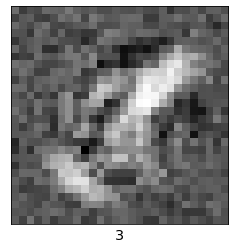

Epoch 12: Batch 1500 Discrim loss 0.12300922721624374, Generator loss 0.9783058166503906


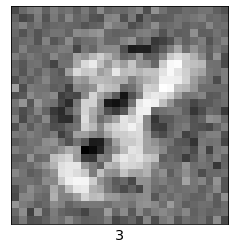

Epoch 12: Batch 1600 Discrim loss 0.03114326484501362, Generator loss 1.8715956211090088


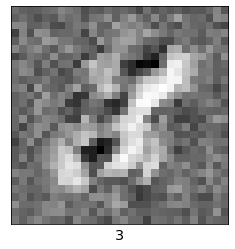

Epoch 12: Batch 1700 Discrim loss 0.04208177328109741, Generator loss 1.964797854423523


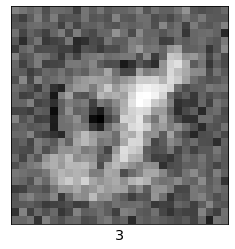

Epoch 12: Batch 1800 Discrim loss 0.18302467465400696, Generator loss 0.6734189987182617


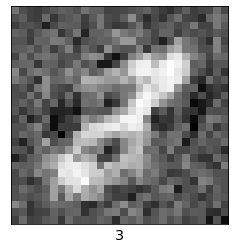

Epoch 13: Batch 0 Discrim loss 0.02294115163385868, Generator loss 1.9120454788208008


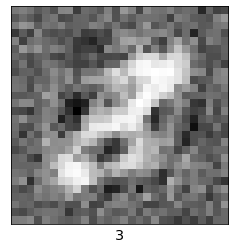

Epoch 13: Batch 100 Discrim loss 0.09514518082141876, Generator loss 2.5385828018188477


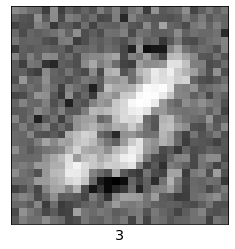

Epoch 13: Batch 200 Discrim loss 0.0745551586151123, Generator loss 1.4480421543121338


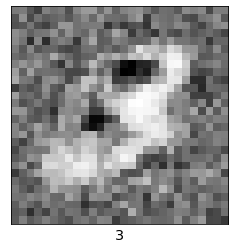

Epoch 13: Batch 300 Discrim loss 0.13297423720359802, Generator loss 1.558113694190979


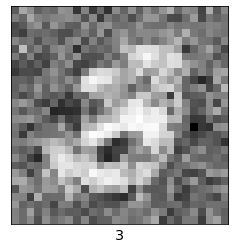

Epoch 13: Batch 400 Discrim loss 0.1334494948387146, Generator loss 1.9832289218902588


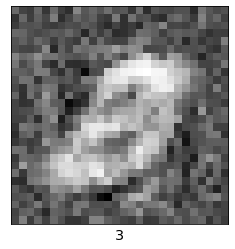

Epoch 13: Batch 500 Discrim loss 0.02803131751716137, Generator loss 1.9906036853790283


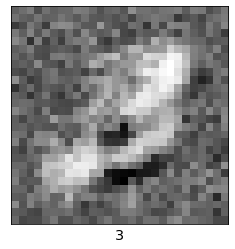

Epoch 13: Batch 600 Discrim loss 0.3730223774909973, Generator loss 1.1673827171325684


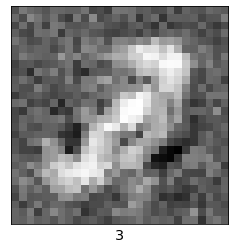

Epoch 13: Batch 700 Discrim loss 0.005742957815527916, Generator loss 1.8559489250183105


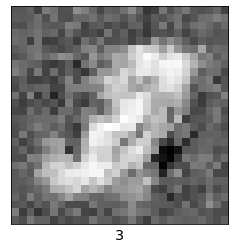

Epoch 13: Batch 800 Discrim loss 0.006348473019897938, Generator loss 0.7171580195426941


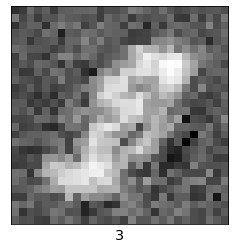

Epoch 13: Batch 900 Discrim loss 0.05949750170111656, Generator loss 1.4769065380096436


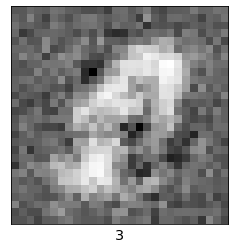

Epoch 13: Batch 1000 Discrim loss 0.03985808044672012, Generator loss 2.687669277191162


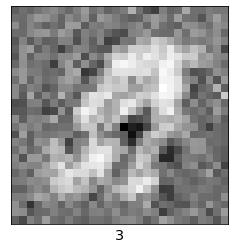

Epoch 13: Batch 1100 Discrim loss 0.05627962946891785, Generator loss 1.9735901355743408


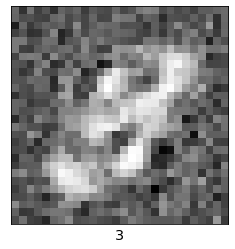

Epoch 13: Batch 1200 Discrim loss 0.04118078202009201, Generator loss 0.9707147479057312


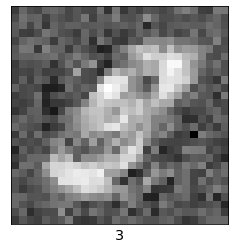

Epoch 13: Batch 1300 Discrim loss 0.024462705478072166, Generator loss 1.6281638145446777


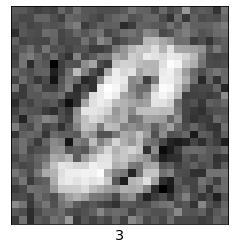

Epoch 13: Batch 1400 Discrim loss 0.23597902059555054, Generator loss 1.3369122743606567


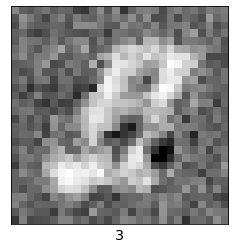

Epoch 13: Batch 1500 Discrim loss 0.06842942535877228, Generator loss 1.1225173473358154


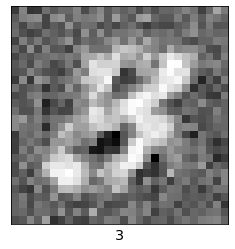

Epoch 13: Batch 1600 Discrim loss 0.03481219708919525, Generator loss 0.9853248596191406


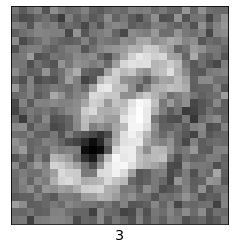

Epoch 13: Batch 1700 Discrim loss 0.08946415781974792, Generator loss 1.3740105628967285


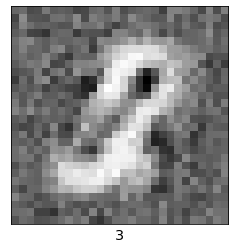

Epoch 13: Batch 1800 Discrim loss 0.005616926588118076, Generator loss 1.0053308010101318


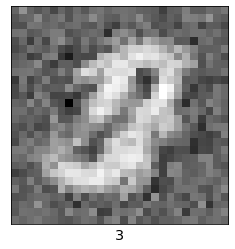

Epoch 14: Batch 0 Discrim loss 0.28668272495269775, Generator loss 0.7213968634605408


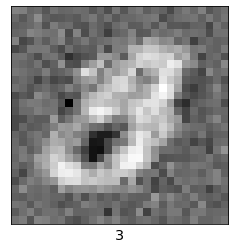

Epoch 14: Batch 100 Discrim loss 0.02072305977344513, Generator loss 1.100464105606079


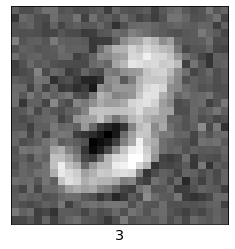

Epoch 14: Batch 200 Discrim loss 0.015591186471283436, Generator loss 0.820080041885376


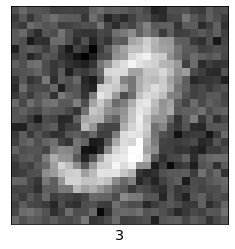

Epoch 14: Batch 300 Discrim loss 0.00679393345490098, Generator loss 1.4023675918579102


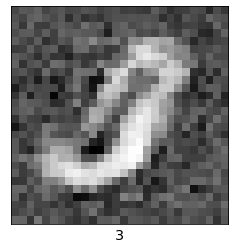

Epoch 14: Batch 400 Discrim loss 0.28481560945510864, Generator loss 0.8917262554168701


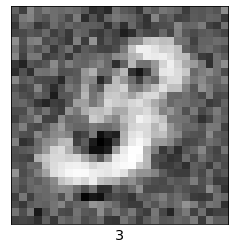

Epoch 14: Batch 500 Discrim loss 0.01205095648765564, Generator loss 1.6691691875457764


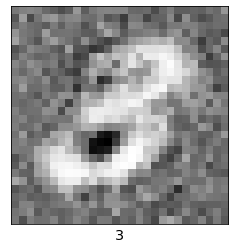

Epoch 14: Batch 600 Discrim loss 0.220118910074234, Generator loss 2.442636013031006


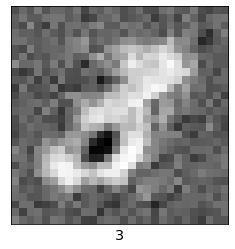

Epoch 14: Batch 700 Discrim loss 0.008240321651101112, Generator loss 1.608090877532959


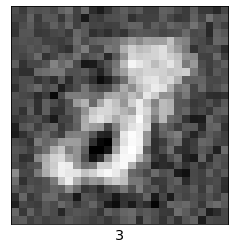

Epoch 14: Batch 800 Discrim loss 0.008206410333514214, Generator loss 1.446817398071289


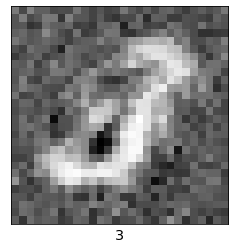

Epoch 14: Batch 900 Discrim loss 0.018628548830747604, Generator loss 2.0178558826446533


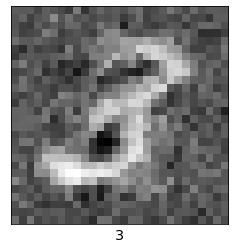

Epoch 14: Batch 1000 Discrim loss 0.004944940097630024, Generator loss 2.3634517192840576


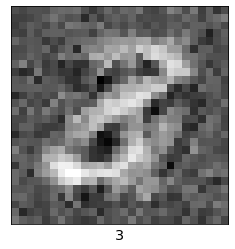

Epoch 14: Batch 1100 Discrim loss 0.011333758011460304, Generator loss 0.5710888504981995


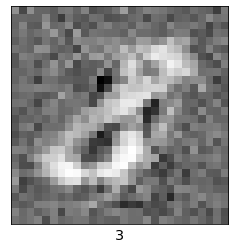

Epoch 14: Batch 1200 Discrim loss 0.020030435174703598, Generator loss 1.2191267013549805


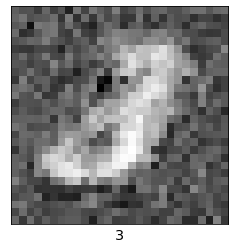

Epoch 14: Batch 1300 Discrim loss 0.033354196697473526, Generator loss 1.0727810859680176


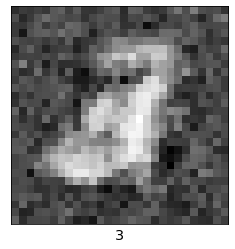

Epoch 14: Batch 1400 Discrim loss 0.010254353284835815, Generator loss 1.9093660116195679


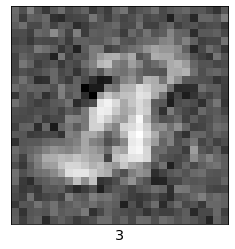

Epoch 14: Batch 1500 Discrim loss 0.013482353650033474, Generator loss 1.3214683532714844


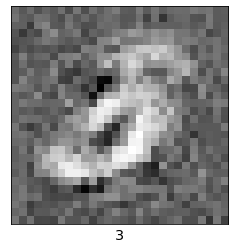

Epoch 14: Batch 1600 Discrim loss 0.00425679562613368, Generator loss 1.7914525270462036


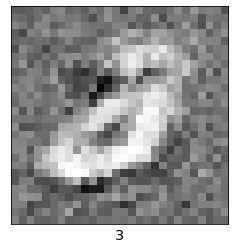

Epoch 14: Batch 1700 Discrim loss 0.058495454490184784, Generator loss 1.36549973487854


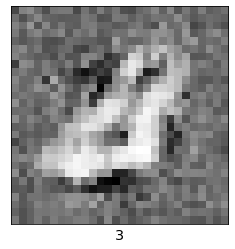

Epoch 14: Batch 1800 Discrim loss 0.004921231418848038, Generator loss 1.4660872220993042


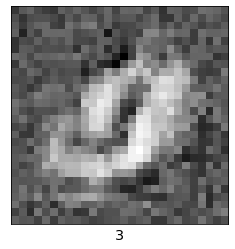

Epoch 15: Batch 0 Discrim loss 0.0061876242980360985, Generator loss 1.7281550168991089


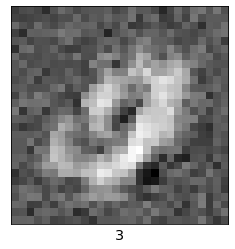

Epoch 15: Batch 100 Discrim loss 0.203979954123497, Generator loss 1.6050970554351807


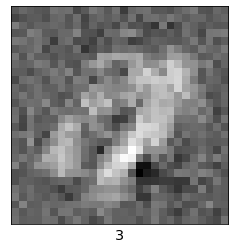

Epoch 15: Batch 200 Discrim loss 0.019862163811922073, Generator loss 1.6371713876724243


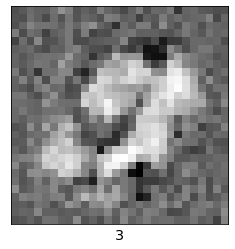

Epoch 15: Batch 300 Discrim loss 0.02318456955254078, Generator loss 0.7759379744529724


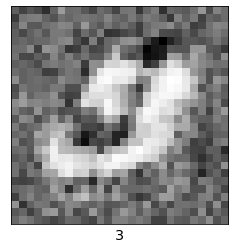

Epoch 15: Batch 400 Discrim loss 0.00609363941475749, Generator loss 1.750718355178833


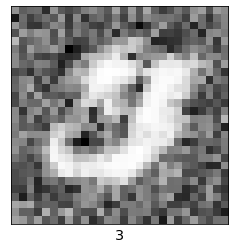

Epoch 15: Batch 500 Discrim loss 0.0658266469836235, Generator loss 1.5534942150115967


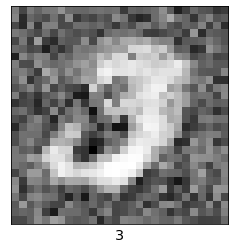

Epoch 15: Batch 600 Discrim loss 0.0314667783677578, Generator loss 1.4929605722427368


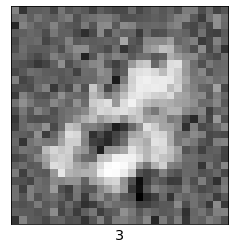

Epoch 15: Batch 700 Discrim loss 0.027032796293497086, Generator loss 1.9980599880218506


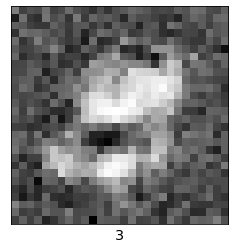

Epoch 15: Batch 800 Discrim loss 0.06354823708534241, Generator loss 1.094255805015564


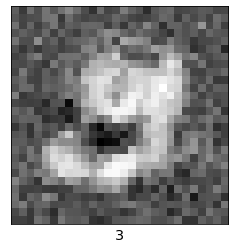

Epoch 15: Batch 900 Discrim loss 0.010081211104989052, Generator loss 0.6135251522064209


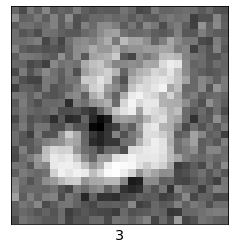

Epoch 15: Batch 1000 Discrim loss 0.060637641698122025, Generator loss 0.7531948089599609


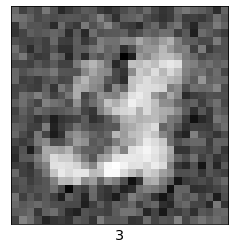

Epoch 15: Batch 1100 Discrim loss 0.015147717669606209, Generator loss 1.5289111137390137


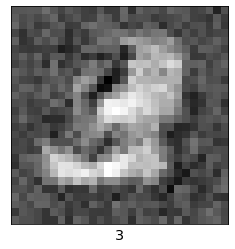

Epoch 15: Batch 1200 Discrim loss 0.004613883793354034, Generator loss 0.9611937403678894


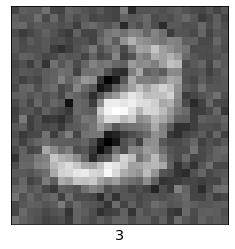

Epoch 15: Batch 1300 Discrim loss 0.015731679275631905, Generator loss 0.6475030779838562


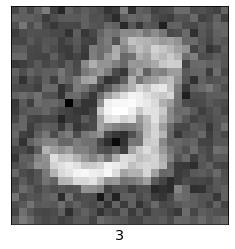

Epoch 15: Batch 1400 Discrim loss 0.024135667830705643, Generator loss 0.3316492438316345


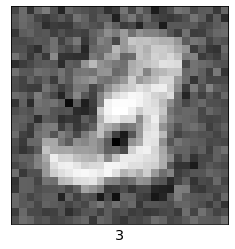

Epoch 15: Batch 1500 Discrim loss 0.028757918626070023, Generator loss 1.1502093076705933


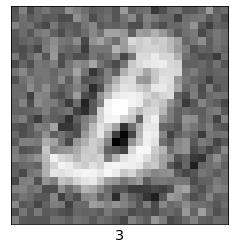

Epoch 15: Batch 1600 Discrim loss 0.009380312636494637, Generator loss 0.6391037702560425


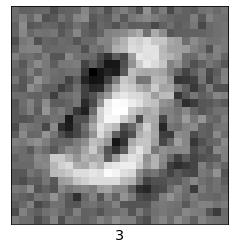

Epoch 15: Batch 1700 Discrim loss 0.01372932456433773, Generator loss 0.8152061104774475


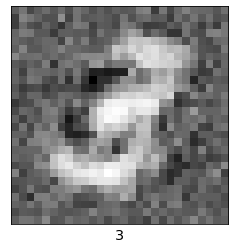

Epoch 15: Batch 1800 Discrim loss 0.01642773300409317, Generator loss 1.2140201330184937


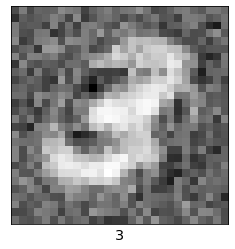

Epoch 16: Batch 0 Discrim loss 0.02827163226902485, Generator loss 1.458242416381836


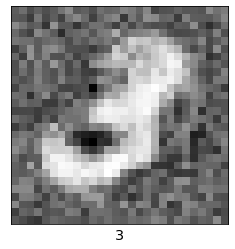

Epoch 16: Batch 100 Discrim loss 0.107533298432827, Generator loss 0.41765648126602173


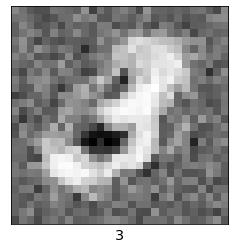

Epoch 16: Batch 200 Discrim loss 0.11950162053108215, Generator loss 1.270304799079895


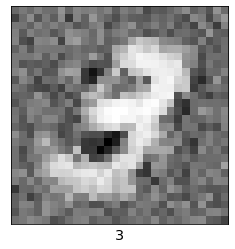

Epoch 16: Batch 300 Discrim loss 0.22649797797203064, Generator loss 1.2693126201629639


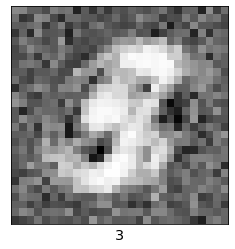

Epoch 16: Batch 400 Discrim loss 0.10768384486436844, Generator loss 0.7197644710540771


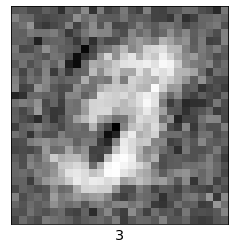

Epoch 16: Batch 500 Discrim loss 0.1994853913784027, Generator loss 1.0236485004425049


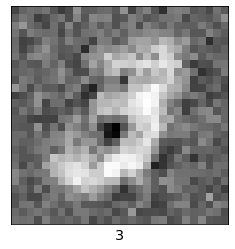

Epoch 16: Batch 600 Discrim loss 0.02318517304956913, Generator loss 1.457757592201233


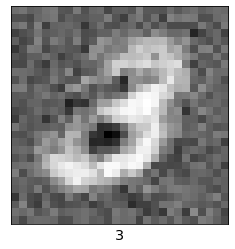

Epoch 16: Batch 700 Discrim loss 0.19606199860572815, Generator loss 2.364520788192749


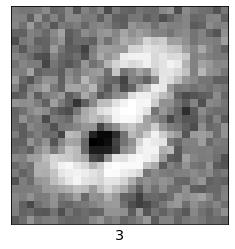

Epoch 16: Batch 800 Discrim loss 0.02963285706937313, Generator loss 1.5038163661956787


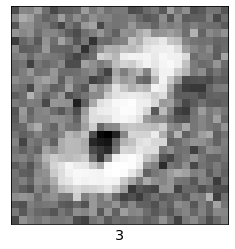

Epoch 16: Batch 900 Discrim loss 0.008285969495773315, Generator loss 1.3193449974060059


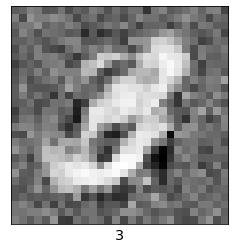

Epoch 16: Batch 1000 Discrim loss 0.01648654229938984, Generator loss 1.7172167301177979


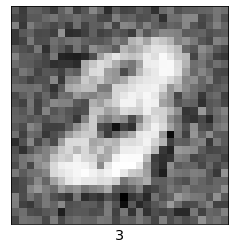

Epoch 16: Batch 1100 Discrim loss 0.2299199253320694, Generator loss 2.222266435623169


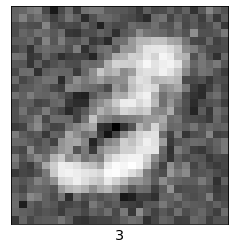

Epoch 16: Batch 1200 Discrim loss 0.01839340664446354, Generator loss 2.1419272422790527


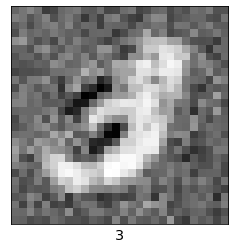

Epoch 16: Batch 1300 Discrim loss 0.02506813034415245, Generator loss 1.3682618141174316


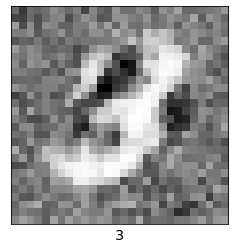

Epoch 16: Batch 1400 Discrim loss 0.02386222593486309, Generator loss 1.6967418193817139


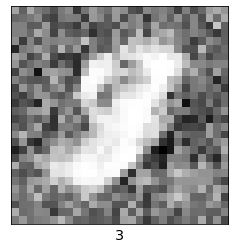

Epoch 16: Batch 1500 Discrim loss 0.00527998385950923, Generator loss 1.7435084581375122


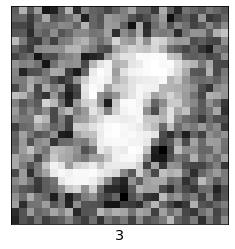

Epoch 16: Batch 1600 Discrim loss 0.17687353491783142, Generator loss 2.892165184020996


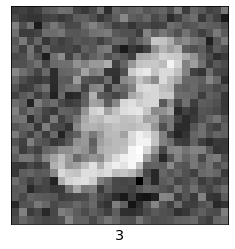

Epoch 16: Batch 1700 Discrim loss 0.020513780415058136, Generator loss 1.491995096206665


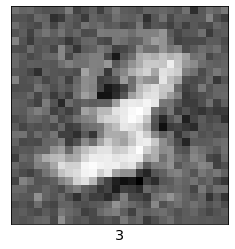

Epoch 16: Batch 1800 Discrim loss 0.18923716247081757, Generator loss 0.17034636437892914


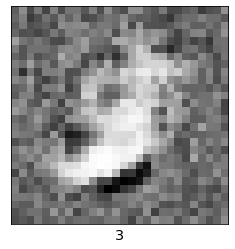

Epoch 17: Batch 0 Discrim loss 0.010409902781248093, Generator loss 1.57685387134552


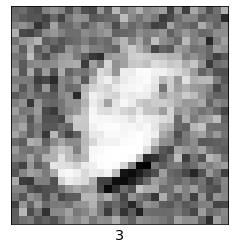

Epoch 17: Batch 100 Discrim loss 0.02897600643336773, Generator loss 2.6296825408935547


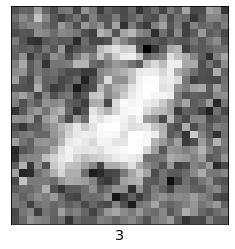

Epoch 17: Batch 200 Discrim loss 0.02174646221101284, Generator loss 1.7397425174713135


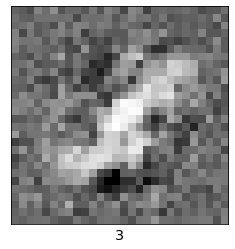

Epoch 17: Batch 300 Discrim loss 0.026313770562410355, Generator loss 0.7876015901565552


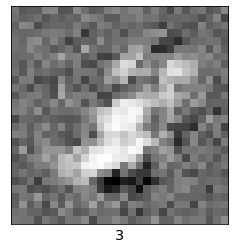

Epoch 17: Batch 400 Discrim loss 0.042486920952796936, Generator loss 0.6297894716262817


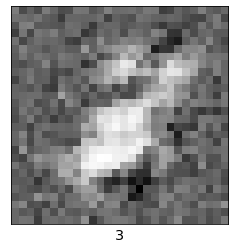

Epoch 17: Batch 500 Discrim loss 0.05649179220199585, Generator loss 3.535287857055664


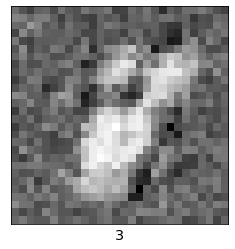

Epoch 17: Batch 600 Discrim loss 0.0065548778511583805, Generator loss 1.3058626651763916


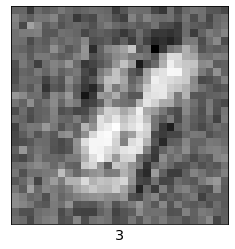

Epoch 17: Batch 700 Discrim loss 0.030202798545360565, Generator loss 1.471862554550171


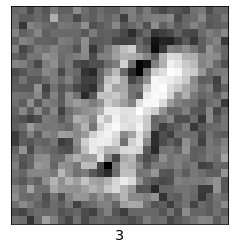

Epoch 17: Batch 800 Discrim loss 0.009572145529091358, Generator loss 1.7527596950531006


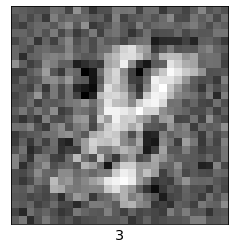

Epoch 17: Batch 900 Discrim loss 0.018809635192155838, Generator loss 0.41226083040237427


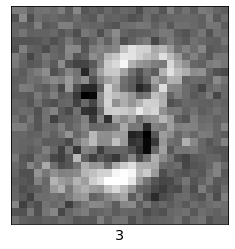

Epoch 17: Batch 1000 Discrim loss 0.026934616267681122, Generator loss 0.9002561569213867


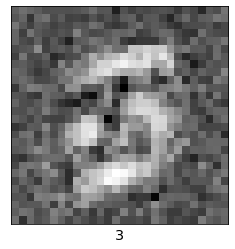

Epoch 17: Batch 1100 Discrim loss 0.007968107238411903, Generator loss 1.4167449474334717


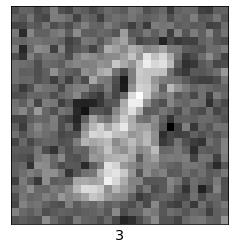

Epoch 17: Batch 1200 Discrim loss 0.014336399734020233, Generator loss 1.5044366121292114


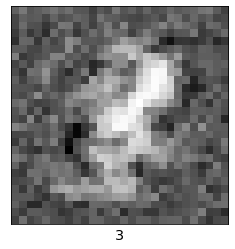

Epoch 17: Batch 1300 Discrim loss 0.0017222134629264474, Generator loss 0.8311533331871033


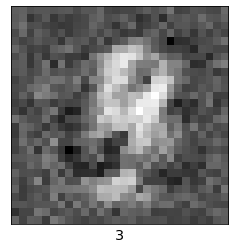

Epoch 17: Batch 1400 Discrim loss 0.138082355260849, Generator loss 2.5813488960266113


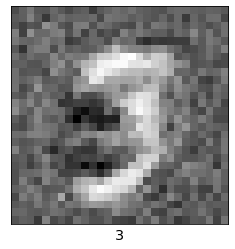

Epoch 17: Batch 1500 Discrim loss 0.1193537712097168, Generator loss 1.927457571029663


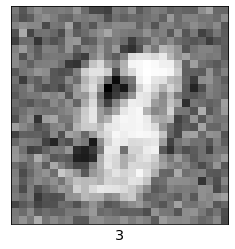

Epoch 17: Batch 1600 Discrim loss 0.07598303258419037, Generator loss 0.9350835084915161


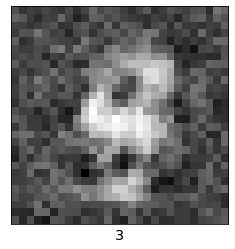

Epoch 17: Batch 1700 Discrim loss 0.03423616662621498, Generator loss 1.781398057937622


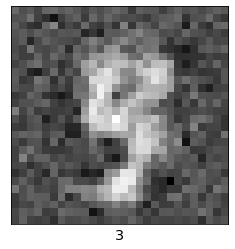

Epoch 17: Batch 1800 Discrim loss 0.04826315492391586, Generator loss 3.08089017868042


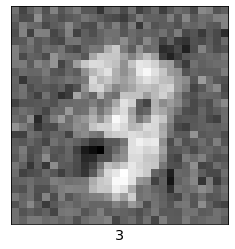

Epoch 18: Batch 0 Discrim loss 0.01718088611960411, Generator loss 2.6412525177001953


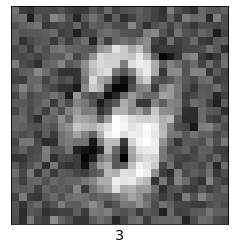

Epoch 18: Batch 100 Discrim loss 0.011832371354103088, Generator loss 1.149597406387329


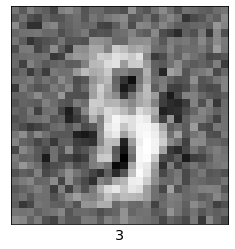

Epoch 18: Batch 200 Discrim loss 0.006509543862193823, Generator loss 0.762203574180603


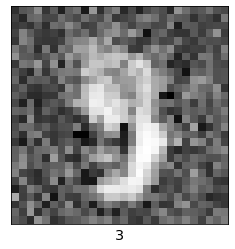

Epoch 18: Batch 300 Discrim loss 0.06379242241382599, Generator loss 1.539670467376709


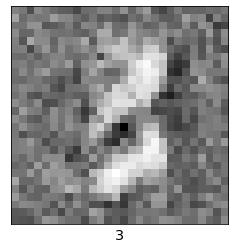

Epoch 18: Batch 400 Discrim loss 0.11545807123184204, Generator loss 2.6463513374328613


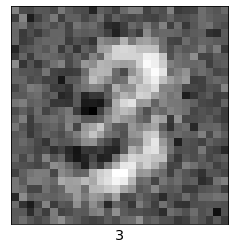

Epoch 18: Batch 500 Discrim loss 0.16644392907619476, Generator loss 1.5264410972595215


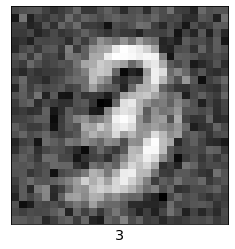

Epoch 18: Batch 600 Discrim loss 0.017454275861382484, Generator loss 0.5623345375061035


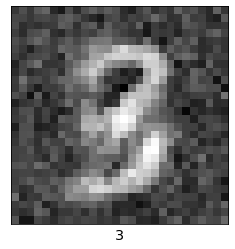

Epoch 18: Batch 700 Discrim loss 0.001240164740011096, Generator loss 1.4501419067382812


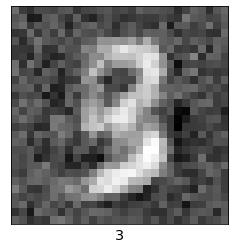

Epoch 18: Batch 800 Discrim loss 0.047538526356220245, Generator loss 0.9343733787536621


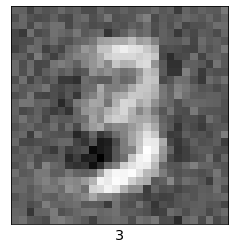

Epoch 18: Batch 900 Discrim loss 0.017410647124052048, Generator loss 0.8930006623268127


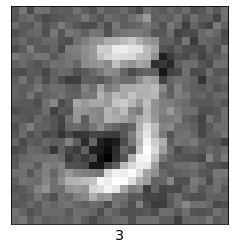

Epoch 18: Batch 1000 Discrim loss 0.006416878197342157, Generator loss 1.983139157295227


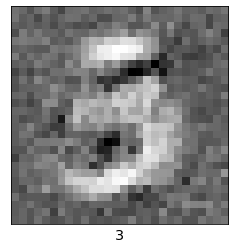

Epoch 18: Batch 1100 Discrim loss 0.08709906041622162, Generator loss 0.5934839844703674


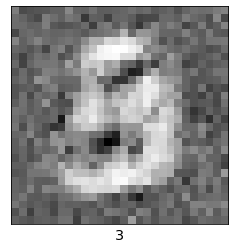

Epoch 18: Batch 1200 Discrim loss 0.021284153684973717, Generator loss 1.5332186222076416


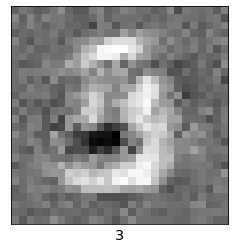

Epoch 18: Batch 1300 Discrim loss 0.04591171070933342, Generator loss 0.9410256147384644


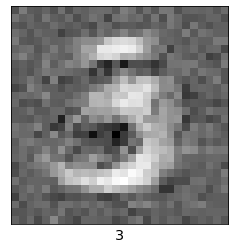

Epoch 18: Batch 1400 Discrim loss 0.07099803537130356, Generator loss 0.39063721895217896


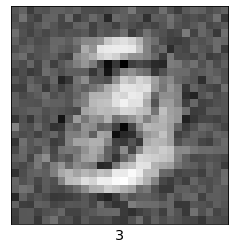

Epoch 18: Batch 1500 Discrim loss 0.04100711643695831, Generator loss 1.2913031578063965


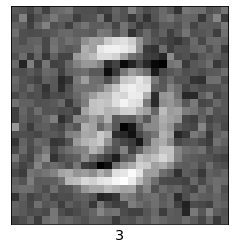

Epoch 18: Batch 1600 Discrim loss 0.1344139575958252, Generator loss 1.0047311782836914


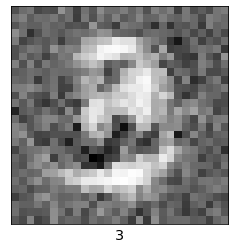

Epoch 18: Batch 1700 Discrim loss 0.004628905560821295, Generator loss 0.6742525100708008


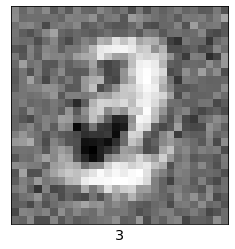

Epoch 18: Batch 1800 Discrim loss 0.17853903770446777, Generator loss 1.705161452293396


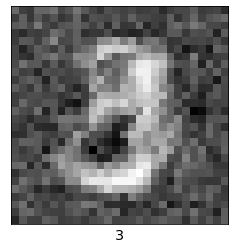

Epoch 19: Batch 0 Discrim loss 0.014262918382883072, Generator loss 1.7123092412948608


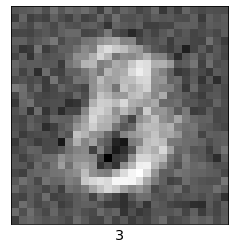

Epoch 19: Batch 100 Discrim loss 0.04760757088661194, Generator loss 0.8839879035949707


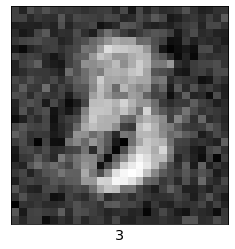

Epoch 19: Batch 200 Discrim loss 0.036475345492362976, Generator loss 0.708619236946106


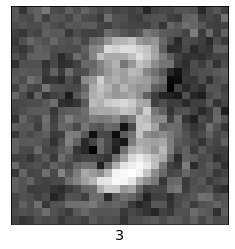

Epoch 19: Batch 300 Discrim loss 0.174188494682312, Generator loss 1.0194895267486572


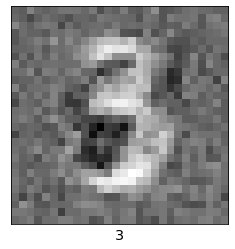

Epoch 19: Batch 400 Discrim loss 0.19064967334270477, Generator loss 0.9930909872055054


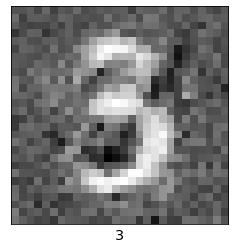

Epoch 19: Batch 500 Discrim loss 0.022328922525048256, Generator loss 1.4067178964614868


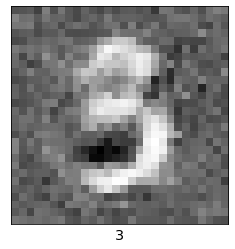

Epoch 19: Batch 600 Discrim loss 0.012118472717702389, Generator loss 0.40282395482063293


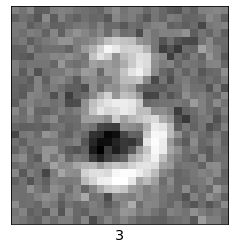

Epoch 19: Batch 700 Discrim loss 0.1414595991373062, Generator loss 1.3805925846099854


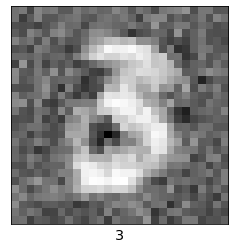

Epoch 19: Batch 800 Discrim loss 0.1711224466562271, Generator loss 1.8401626348495483


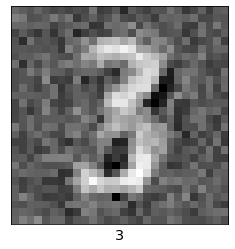

Epoch 19: Batch 900 Discrim loss 0.026202119886875153, Generator loss 0.6558169722557068


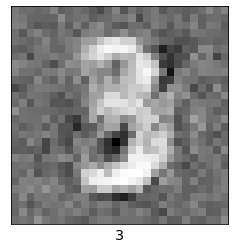

Epoch 19: Batch 1000 Discrim loss 0.024151721969246864, Generator loss 0.8399667143821716


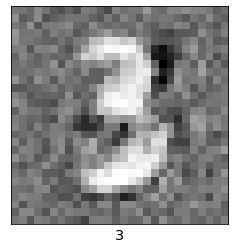

Epoch 19: Batch 1100 Discrim loss 0.026505548506975174, Generator loss 1.560545563697815


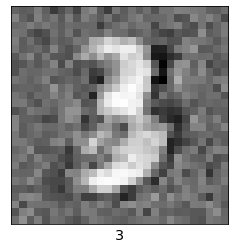

Epoch 19: Batch 1200 Discrim loss 0.015456901863217354, Generator loss 0.5249930024147034


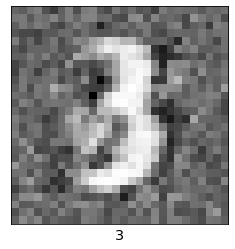

Epoch 19: Batch 1300 Discrim loss 0.0859888345003128, Generator loss 0.9160851836204529


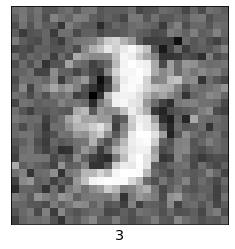

Epoch 19: Batch 1400 Discrim loss 0.016170883551239967, Generator loss 1.0254058837890625


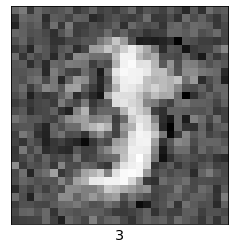

Epoch 19: Batch 1500 Discrim loss 0.02380083128809929, Generator loss 2.110696792602539


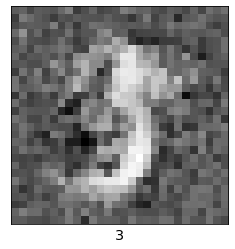

Epoch 19: Batch 1600 Discrim loss 0.041696108877658844, Generator loss 0.6352674961090088


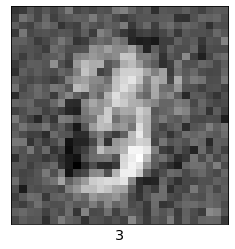

Epoch 19: Batch 1700 Discrim loss 0.006013198290020227, Generator loss 1.899999976158142


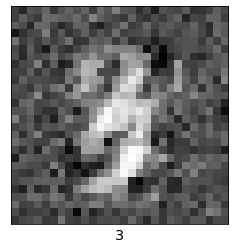

Epoch 19: Batch 1800 Discrim loss 0.11382923275232315, Generator loss 2.1416754722595215


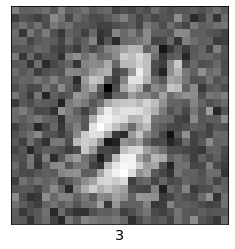

Epoch 20: Batch 0 Discrim loss 0.005230315960943699, Generator loss 2.0445556640625


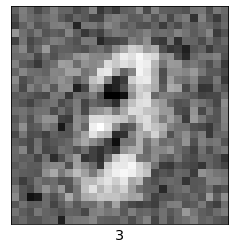

Epoch 20: Batch 100 Discrim loss 0.0047453283332288265, Generator loss 1.2629297971725464


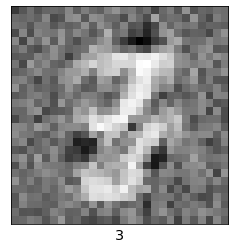

Epoch 20: Batch 200 Discrim loss 0.02914782240986824, Generator loss 1.9730117321014404


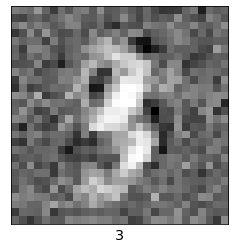

Epoch 20: Batch 300 Discrim loss 0.0649605467915535, Generator loss 1.6188561916351318


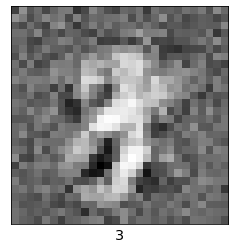

Epoch 20: Batch 400 Discrim loss 0.017270218580961227, Generator loss 2.0768213272094727


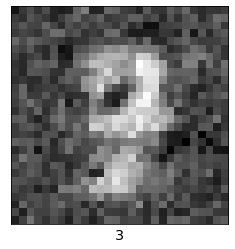

Epoch 20: Batch 500 Discrim loss 0.02429826557636261, Generator loss 1.1009740829467773


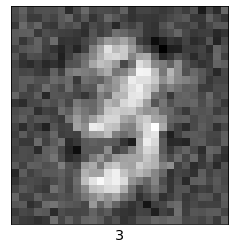

Epoch 20: Batch 600 Discrim loss 0.19147157669067383, Generator loss 0.6049361228942871


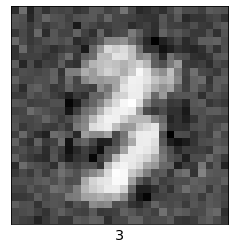

Epoch 20: Batch 700 Discrim loss 0.0018860469572246075, Generator loss 1.642573356628418


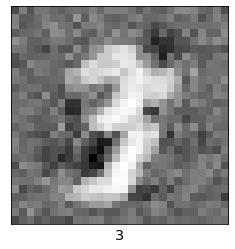

Epoch 20: Batch 800 Discrim loss 0.03900526463985443, Generator loss 2.2386465072631836


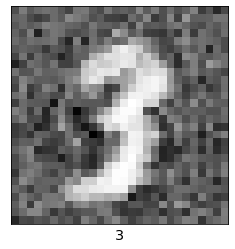

Epoch 20: Batch 900 Discrim loss 0.06361287087202072, Generator loss 2.063223361968994


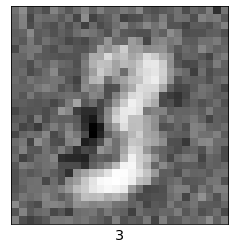

Epoch 20: Batch 1000 Discrim loss 0.15316477417945862, Generator loss 1.5688409805297852


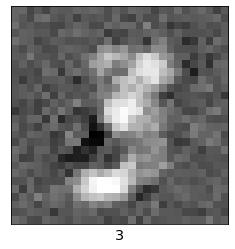

Epoch 20: Batch 1100 Discrim loss 0.05228196829557419, Generator loss 1.358853816986084


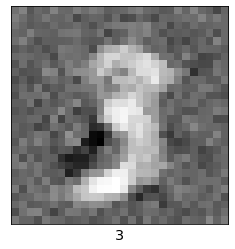

Epoch 20: Batch 1200 Discrim loss 0.015462754294276237, Generator loss 1.4814717769622803


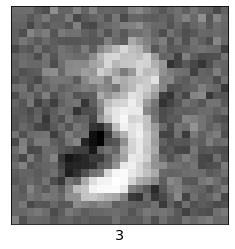

Epoch 20: Batch 1300 Discrim loss 0.005975102074444294, Generator loss 2.3165316581726074


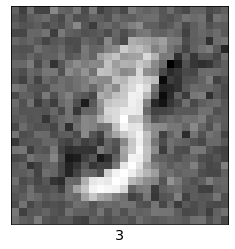

Epoch 20: Batch 1400 Discrim loss 0.0418127216398716, Generator loss 0.4513777196407318


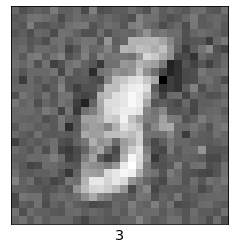

Epoch 20: Batch 1500 Discrim loss 0.021586231887340546, Generator loss 1.1639103889465332


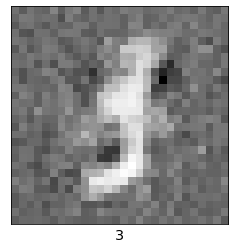

Epoch 20: Batch 1600 Discrim loss 0.16024242341518402, Generator loss 1.3845943212509155


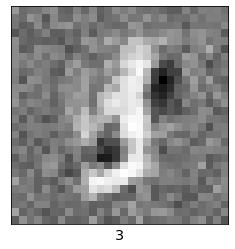

Epoch 20: Batch 1700 Discrim loss 0.06929196417331696, Generator loss 0.7546356916427612


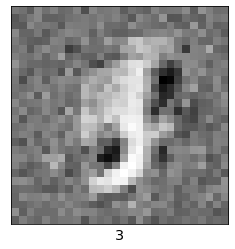

Epoch 20: Batch 1800 Discrim loss 0.09722252190113068, Generator loss 0.9425515532493591


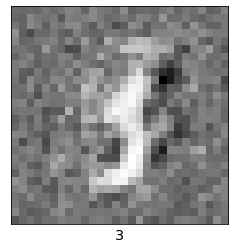

Epoch 21: Batch 0 Discrim loss 0.015353717841207981, Generator loss 0.8898694515228271


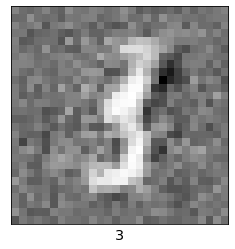

Epoch 21: Batch 100 Discrim loss 0.11230967938899994, Generator loss 1.2106415033340454


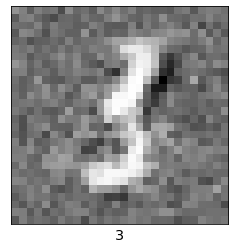

Epoch 21: Batch 200 Discrim loss 0.03782065212726593, Generator loss 1.5436019897460938


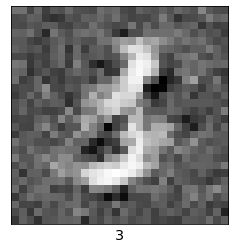

Epoch 21: Batch 300 Discrim loss 0.189088374376297, Generator loss 0.4422650635242462


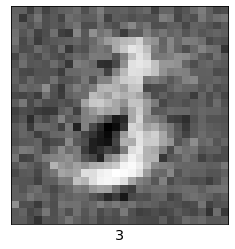

Epoch 21: Batch 400 Discrim loss 0.07032045722007751, Generator loss 1.3915815353393555


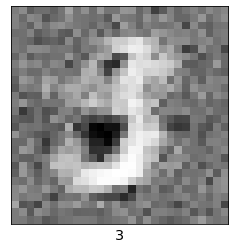

Epoch 21: Batch 500 Discrim loss 0.18293695151805878, Generator loss 2.0076420307159424


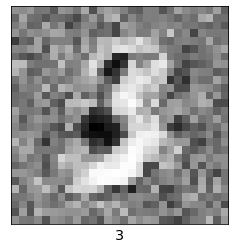

Epoch 21: Batch 600 Discrim loss 0.019928492605686188, Generator loss 1.1811093091964722


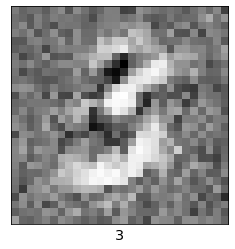

Epoch 21: Batch 700 Discrim loss 0.01826705038547516, Generator loss 1.3946415185928345


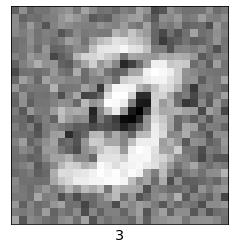

Epoch 21: Batch 800 Discrim loss 0.12015204131603241, Generator loss 0.5188941359519958


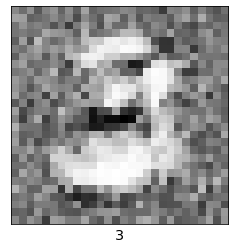

Epoch 21: Batch 900 Discrim loss 0.01771669089794159, Generator loss 1.4663670063018799


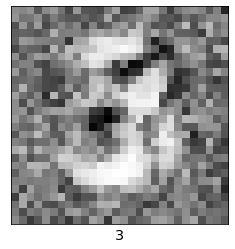

Epoch 21: Batch 1000 Discrim loss 0.007493914104998112, Generator loss 0.704832911491394


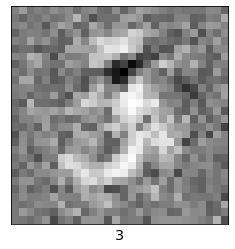

Epoch 21: Batch 1100 Discrim loss 0.023283623158931732, Generator loss 0.611230731010437


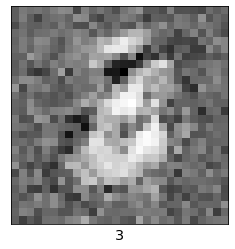

Epoch 21: Batch 1200 Discrim loss 0.029503969475626945, Generator loss 1.914015769958496


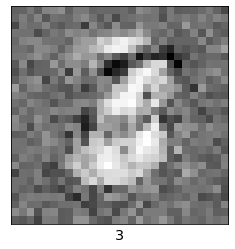

Epoch 21: Batch 1300 Discrim loss 0.015111744403839111, Generator loss 0.6854970455169678


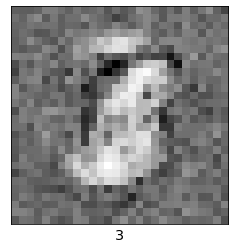

Epoch 21: Batch 1400 Discrim loss 0.004059277009218931, Generator loss 1.0665045976638794


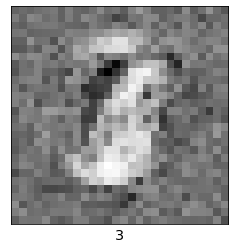

Epoch 21: Batch 1500 Discrim loss 0.05158255249261856, Generator loss 0.9660846590995789


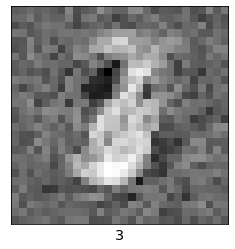

Epoch 21: Batch 1600 Discrim loss 0.044496893882751465, Generator loss 0.8278286457061768


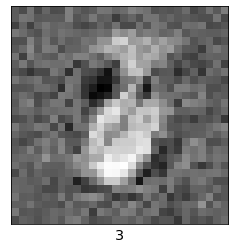

Epoch 21: Batch 1700 Discrim loss 0.008382046595215797, Generator loss 0.49650806188583374


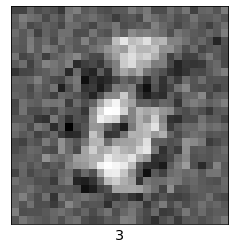

Epoch 21: Batch 1800 Discrim loss 0.009362646378576756, Generator loss 0.9304003715515137


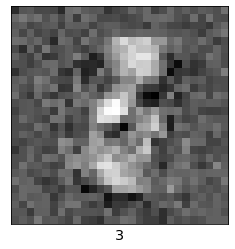

Epoch 22: Batch 0 Discrim loss 0.05530755966901779, Generator loss 0.8853691816329956


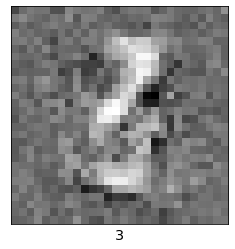

Epoch 22: Batch 100 Discrim loss 0.0326220728456974, Generator loss 0.8947123289108276


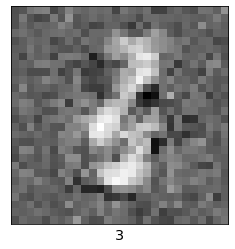

Epoch 22: Batch 200 Discrim loss 0.04603036493062973, Generator loss 1.5714294910430908


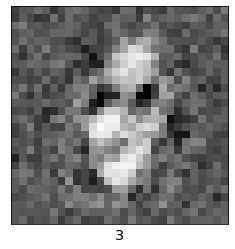

Epoch 22: Batch 300 Discrim loss 0.04257209599018097, Generator loss 0.9323261976242065


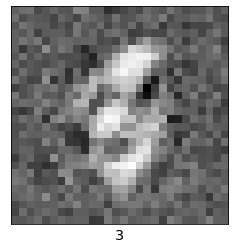

Epoch 22: Batch 400 Discrim loss 0.017859473824501038, Generator loss 1.6748993396759033


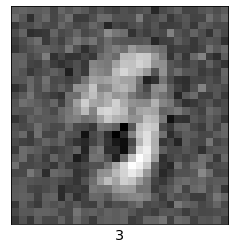

Epoch 22: Batch 500 Discrim loss 0.04985647648572922, Generator loss 0.7328921556472778


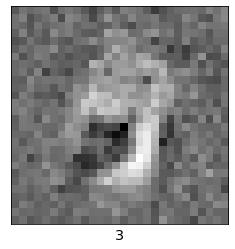

Epoch 22: Batch 600 Discrim loss 0.010191150940954685, Generator loss 1.7788729667663574


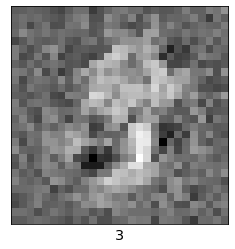

Epoch 22: Batch 700 Discrim loss 0.037804506719112396, Generator loss 1.6220484972000122


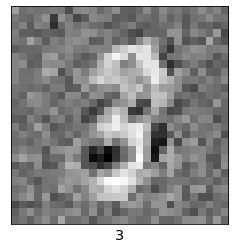

Epoch 22: Batch 800 Discrim loss 0.05522165820002556, Generator loss 2.260812282562256


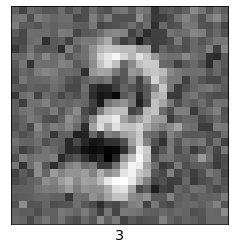

Epoch 22: Batch 900 Discrim loss 0.0094181839376688, Generator loss 1.4393376111984253


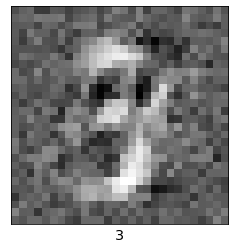

Epoch 22: Batch 1000 Discrim loss 0.04751500114798546, Generator loss 0.9162286520004272


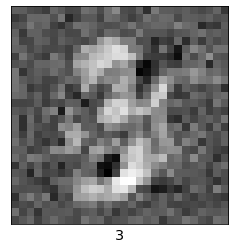

Epoch 22: Batch 1100 Discrim loss 0.027739647775888443, Generator loss 0.5175589919090271


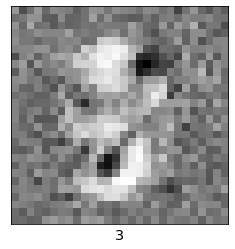

Epoch 22: Batch 1200 Discrim loss 0.00575080793350935, Generator loss 2.443382740020752


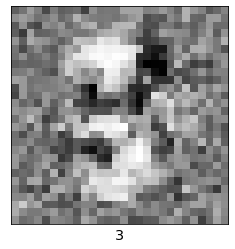

Epoch 22: Batch 1300 Discrim loss 0.019361354410648346, Generator loss 0.4840332269668579


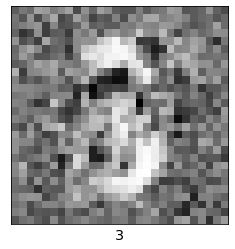

Epoch 22: Batch 1400 Discrim loss 0.012448969297111034, Generator loss 1.0666537284851074


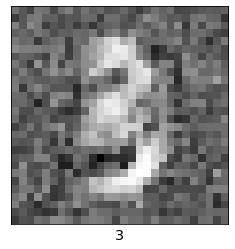

Epoch 22: Batch 1500 Discrim loss 0.07288364320993423, Generator loss 1.2458089590072632


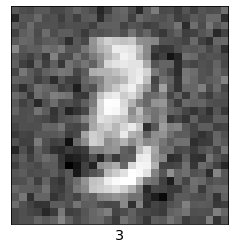

Epoch 22: Batch 1600 Discrim loss 0.1232435405254364, Generator loss 1.1609015464782715


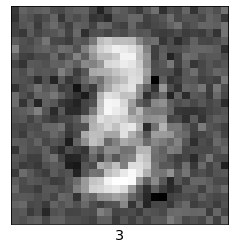

Epoch 22: Batch 1700 Discrim loss 0.05072968453168869, Generator loss 0.8191255927085876


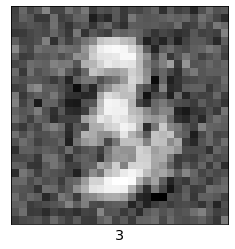

Epoch 22: Batch 1800 Discrim loss 0.011400874704122543, Generator loss 1.1326947212219238


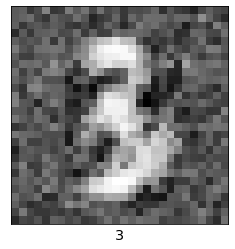

Epoch 23: Batch 0 Discrim loss 0.013376370072364807, Generator loss 2.30930757522583


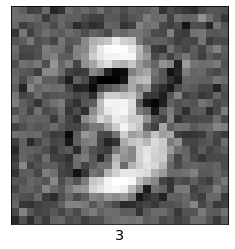

Epoch 23: Batch 100 Discrim loss 0.019270310178399086, Generator loss 0.8218838572502136


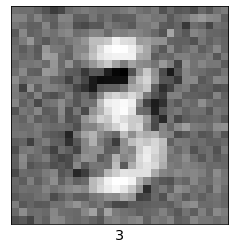

Epoch 23: Batch 200 Discrim loss 0.01119281630963087, Generator loss 2.8545992374420166


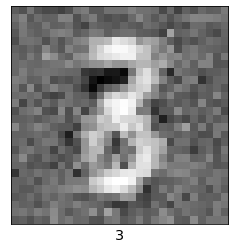

Epoch 23: Batch 300 Discrim loss 0.09864810854196548, Generator loss 0.9064249396324158


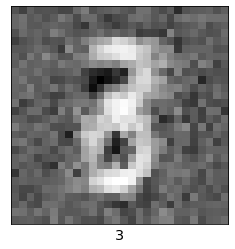

Epoch 23: Batch 400 Discrim loss 0.013117226772010326, Generator loss 1.1247782707214355


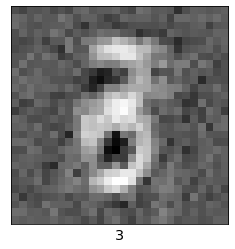

Epoch 23: Batch 500 Discrim loss 0.0040717520751059055, Generator loss 2.7923455238342285


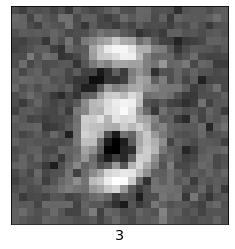

Epoch 23: Batch 600 Discrim loss 0.0632418617606163, Generator loss 1.59513521194458


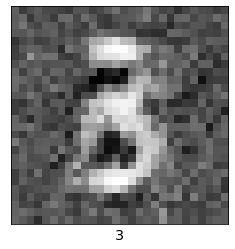

Epoch 23: Batch 700 Discrim loss 0.04881233721971512, Generator loss 0.47942468523979187


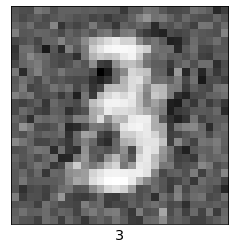

Epoch 23: Batch 800 Discrim loss 0.039865974336862564, Generator loss 0.668730616569519


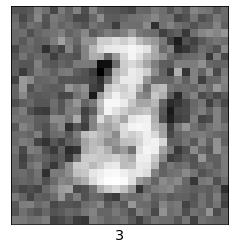

Epoch 23: Batch 900 Discrim loss 0.01123388484120369, Generator loss 1.4121642112731934


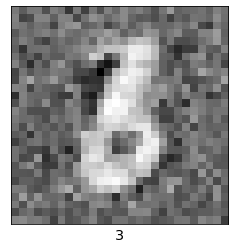

Epoch 23: Batch 1000 Discrim loss 0.015150623396039009, Generator loss 1.170022964477539


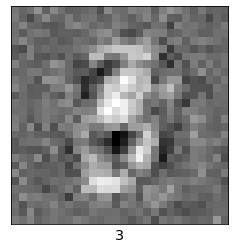

Epoch 23: Batch 1100 Discrim loss 0.090830497443676, Generator loss 1.1991188526153564


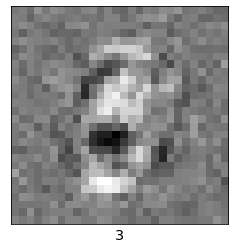

Epoch 23: Batch 1200 Discrim loss 0.19654551148414612, Generator loss 1.0237129926681519


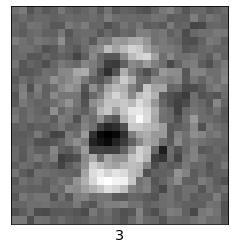

Epoch 23: Batch 1300 Discrim loss 0.17793573439121246, Generator loss 1.878941535949707


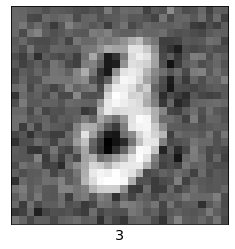

Epoch 23: Batch 1400 Discrim loss 0.016248879954218864, Generator loss 1.7327983379364014


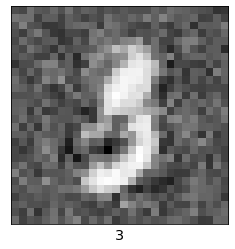

Epoch 23: Batch 1500 Discrim loss 0.004724332597106695, Generator loss 0.7938412427902222


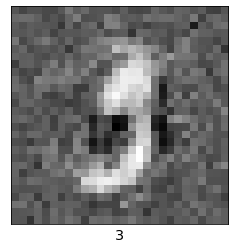

Epoch 23: Batch 1600 Discrim loss 0.013327822089195251, Generator loss 0.7547413110733032


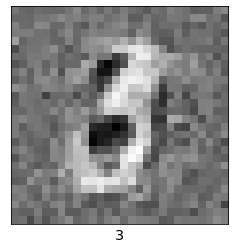

Epoch 23: Batch 1700 Discrim loss 0.014690961688756943, Generator loss 0.5735267996788025


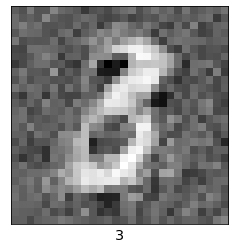

Epoch 23: Batch 1800 Discrim loss 0.04320206493139267, Generator loss 0.9576116800308228


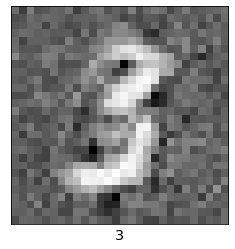

Epoch 24: Batch 0 Discrim loss 0.003956064581871033, Generator loss 0.8060648441314697


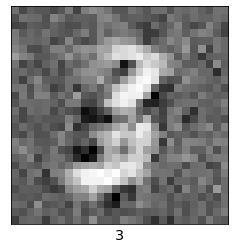

Epoch 24: Batch 100 Discrim loss 0.013668223284184933, Generator loss 1.0984725952148438


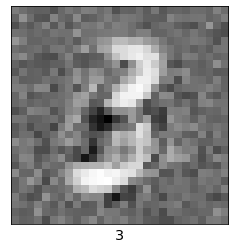

Epoch 24: Batch 200 Discrim loss 0.005942066665738821, Generator loss 2.18296217918396


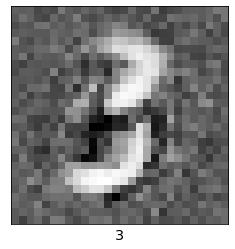

Epoch 24: Batch 300 Discrim loss 0.012079751119017601, Generator loss 1.5823652744293213


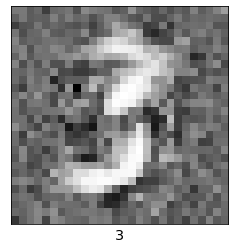

Epoch 24: Batch 400 Discrim loss 0.0746069848537445, Generator loss 0.6842758655548096


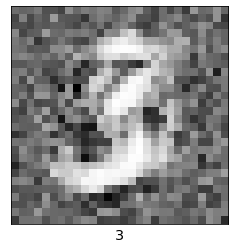

Epoch 24: Batch 500 Discrim loss 0.04970752075314522, Generator loss 2.021723508834839


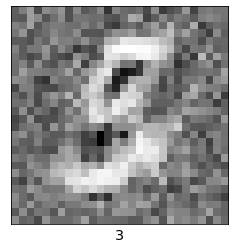

Epoch 24: Batch 600 Discrim loss 0.029897429049015045, Generator loss 0.7588472962379456


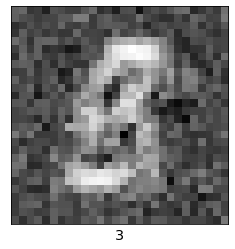

Epoch 24: Batch 700 Discrim loss 0.006834391970187426, Generator loss 1.4051260948181152


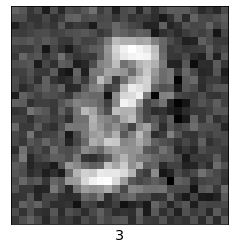

Epoch 24: Batch 800 Discrim loss 0.009125088341534138, Generator loss 0.6408970952033997


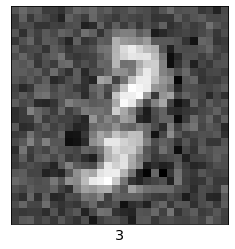

Epoch 24: Batch 900 Discrim loss 0.007981622591614723, Generator loss 0.7144618630409241


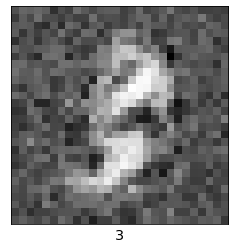

Epoch 24: Batch 1000 Discrim loss 0.030024293810129166, Generator loss 0.6764132976531982


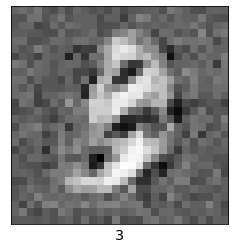

Epoch 24: Batch 1100 Discrim loss 0.0021295587066560984, Generator loss 0.5489854216575623


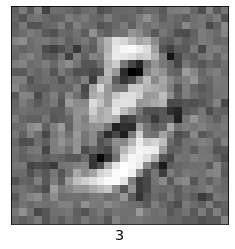

Epoch 24: Batch 1200 Discrim loss 0.039302535355091095, Generator loss 0.6972948312759399


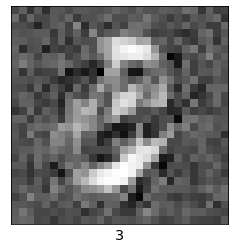

Epoch 24: Batch 1300 Discrim loss 0.028905345126986504, Generator loss 0.5945025086402893


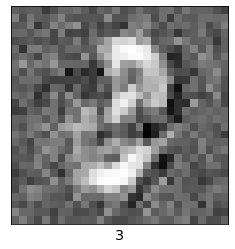

Epoch 24: Batch 1400 Discrim loss 0.15740439295768738, Generator loss 0.66328364610672


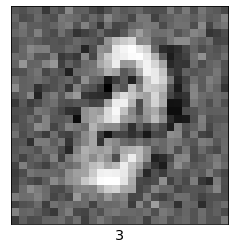

Epoch 24: Batch 1500 Discrim loss 0.01620727963745594, Generator loss 0.8652138710021973


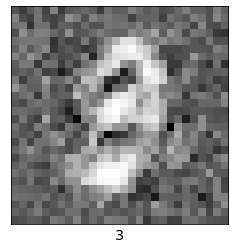

Epoch 24: Batch 1600 Discrim loss 0.022440852597355843, Generator loss 1.4651813507080078


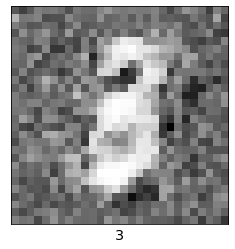

Epoch 24: Batch 1700 Discrim loss 0.011689282953739166, Generator loss 1.5591869354248047


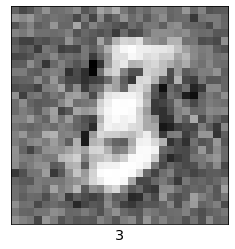

Epoch 24: Batch 1800 Discrim loss 0.013818608596920967, Generator loss 0.7511672973632812


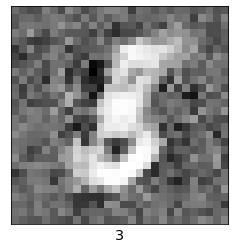

Epoch 25: Batch 0 Discrim loss 0.014226829633116722, Generator loss 1.0554399490356445


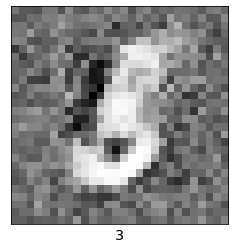

Epoch 25: Batch 100 Discrim loss 0.20442530512809753, Generator loss 2.050462007522583


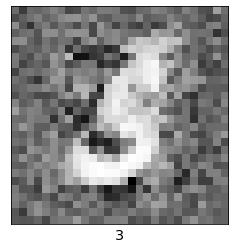

Epoch 25: Batch 200 Discrim loss 0.053775086998939514, Generator loss 1.2974194288253784


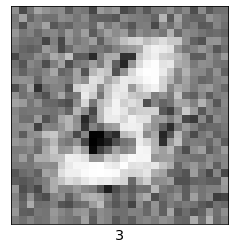

Epoch 25: Batch 300 Discrim loss 0.07492464035749435, Generator loss 1.7549619674682617


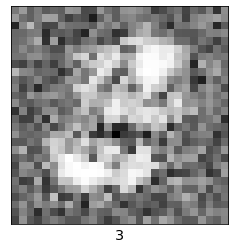

Epoch 25: Batch 400 Discrim loss 0.12122795730829239, Generator loss 1.1514369249343872


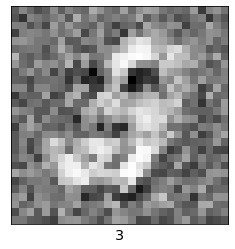

Epoch 25: Batch 500 Discrim loss 0.18311847746372223, Generator loss 1.0443683862686157


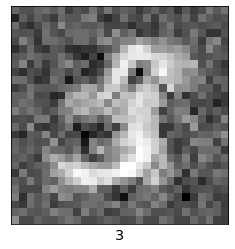

Epoch 25: Batch 600 Discrim loss 0.1585133671760559, Generator loss 0.8725173473358154


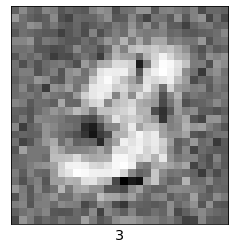

Epoch 25: Batch 700 Discrim loss 0.03518850356340408, Generator loss 2.066748857498169


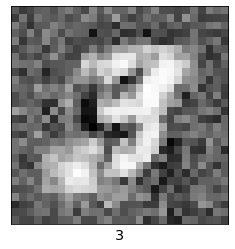

Epoch 25: Batch 800 Discrim loss 0.05772705376148224, Generator loss 1.0864933729171753


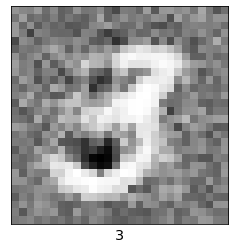

Epoch 25: Batch 900 Discrim loss 0.02022123709321022, Generator loss 2.0617575645446777


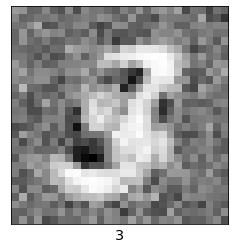

Epoch 25: Batch 1000 Discrim loss 0.006414765026420355, Generator loss 1.0340512990951538


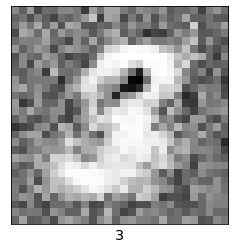

Epoch 25: Batch 1100 Discrim loss 0.012759609147906303, Generator loss 1.1782801151275635


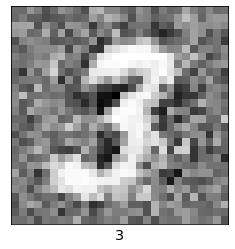

Epoch 25: Batch 1200 Discrim loss 0.04447774961590767, Generator loss 0.9377274513244629


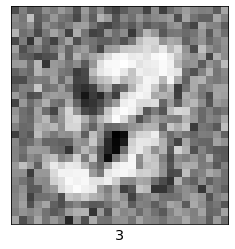

Epoch 25: Batch 1300 Discrim loss 0.02189549058675766, Generator loss 0.6218575835227966


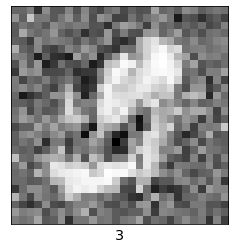

Epoch 25: Batch 1400 Discrim loss 0.12806883454322815, Generator loss 1.7437642812728882


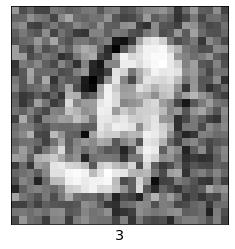

Epoch 25: Batch 1500 Discrim loss 0.03447200357913971, Generator loss 1.4471200704574585


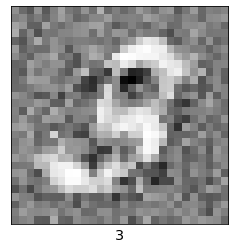

Epoch 25: Batch 1600 Discrim loss 0.32331645488739014, Generator loss 1.1398594379425049


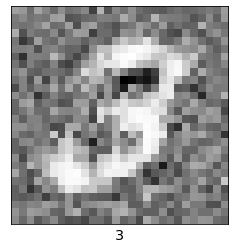

Epoch 25: Batch 1700 Discrim loss 0.09101570397615433, Generator loss 1.215289831161499


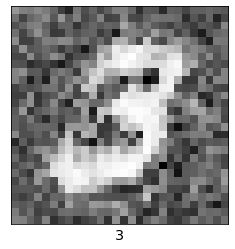

Epoch 25: Batch 1800 Discrim loss 0.045852407813072205, Generator loss 1.176842451095581


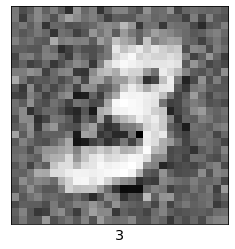

Epoch 26: Batch 0 Discrim loss 0.052611470222473145, Generator loss 2.6960113048553467


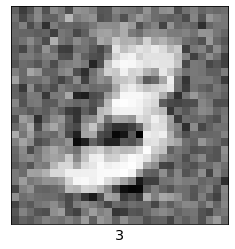

Epoch 26: Batch 100 Discrim loss 0.013847961090505123, Generator loss 1.2096359729766846


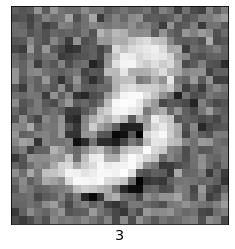

Epoch 26: Batch 200 Discrim loss 0.009607228450477123, Generator loss 1.659497857093811


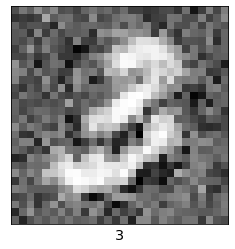

Epoch 26: Batch 300 Discrim loss 0.02107657492160797, Generator loss 1.0403317213058472


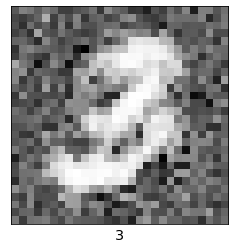

Epoch 26: Batch 400 Discrim loss 0.021136760711669922, Generator loss 1.8384182453155518


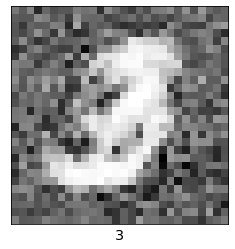

Epoch 26: Batch 500 Discrim loss 0.024317482486367226, Generator loss 0.8643935322761536


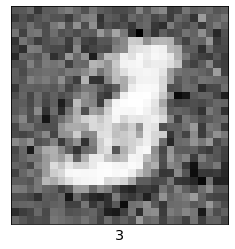

Epoch 26: Batch 600 Discrim loss 0.08526306599378586, Generator loss 0.96151202917099


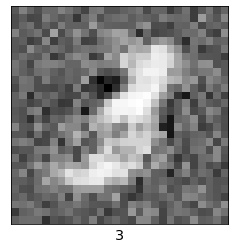

Epoch 26: Batch 700 Discrim loss 0.007589658256620169, Generator loss 1.1272262334823608


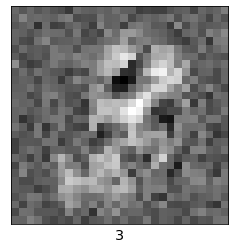

Epoch 26: Batch 800 Discrim loss 0.006151354871690273, Generator loss 0.8012662529945374


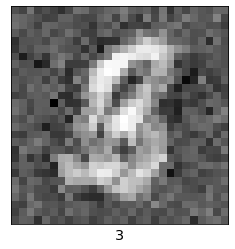

Epoch 26: Batch 900 Discrim loss 0.014250529929995537, Generator loss 3.5944442749023438


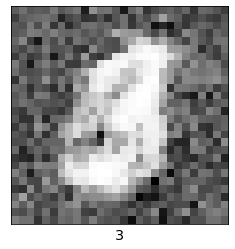

Epoch 26: Batch 1000 Discrim loss 0.16220395267009735, Generator loss 2.1538407802581787


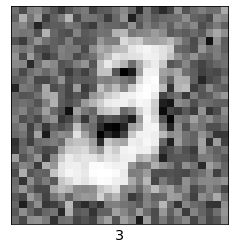

Epoch 26: Batch 1100 Discrim loss 0.09981198608875275, Generator loss 1.9335376024246216


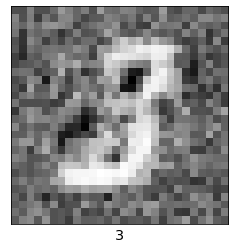

Epoch 26: Batch 1200 Discrim loss 0.0274411141872406, Generator loss 1.447165608406067


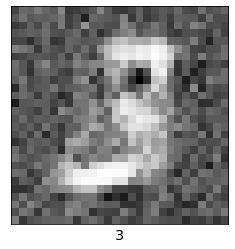

Epoch 26: Batch 1300 Discrim loss 0.012868426740169525, Generator loss 0.8451509475708008


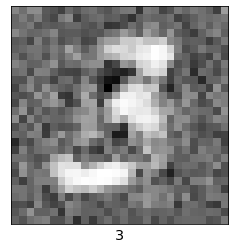

Epoch 26: Batch 1400 Discrim loss 0.0392594039440155, Generator loss 1.0621583461761475


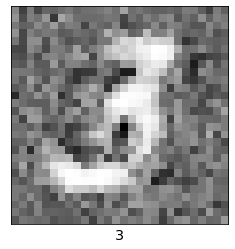

Epoch 26: Batch 1500 Discrim loss 0.29928091168403625, Generator loss 1.2793004512786865


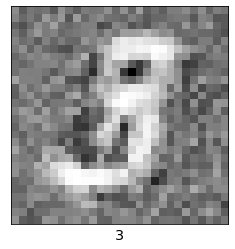

Epoch 26: Batch 1600 Discrim loss 0.028828183189034462, Generator loss 1.21173894405365


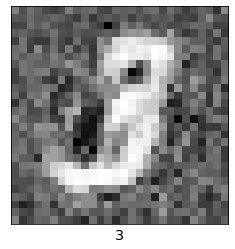

Epoch 26: Batch 1700 Discrim loss 0.06504858285188675, Generator loss 1.116621732711792


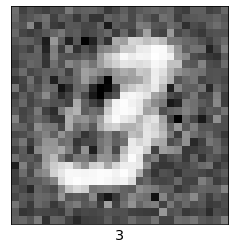

Epoch 26: Batch 1800 Discrim loss 0.006052790675312281, Generator loss 1.1157734394073486


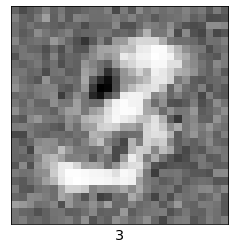

Epoch 27: Batch 0 Discrim loss 0.005191108677536249, Generator loss 1.5284059047698975


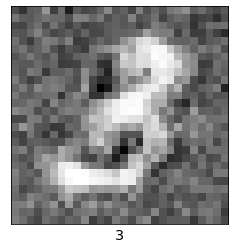

Epoch 27: Batch 100 Discrim loss 0.21026842296123505, Generator loss 1.4036335945129395


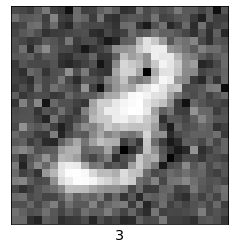

Epoch 27: Batch 200 Discrim loss 0.017962731420993805, Generator loss 2.050947666168213


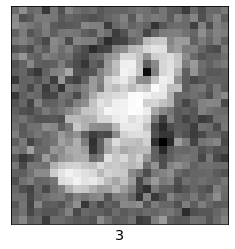

Epoch 27: Batch 300 Discrim loss 0.014586621895432472, Generator loss 1.7398014068603516


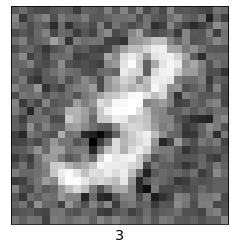

Epoch 27: Batch 400 Discrim loss 0.14265801012516022, Generator loss 1.4253511428833008


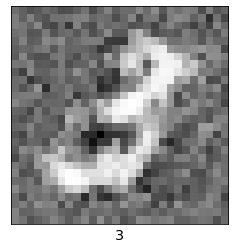

Epoch 27: Batch 500 Discrim loss 0.12271586060523987, Generator loss 1.0033836364746094


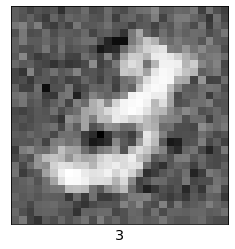

Epoch 27: Batch 600 Discrim loss 0.009172537364065647, Generator loss 1.1518625020980835


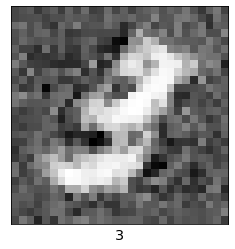

Epoch 27: Batch 700 Discrim loss 0.025507410988211632, Generator loss 0.8040010929107666


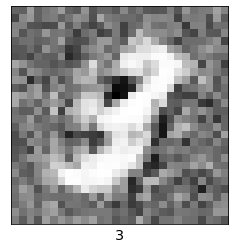

Epoch 27: Batch 800 Discrim loss 0.014489986002445221, Generator loss 2.534304141998291


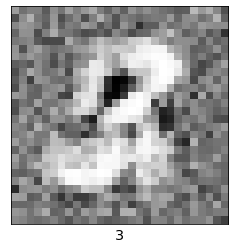

Epoch 27: Batch 900 Discrim loss 0.06393028795719147, Generator loss 1.7256155014038086


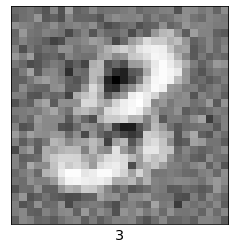

Epoch 27: Batch 1000 Discrim loss 0.023262958973646164, Generator loss 1.1798990964889526


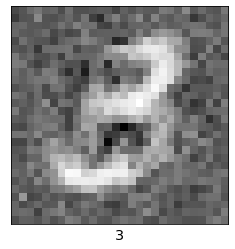

Epoch 27: Batch 1100 Discrim loss 0.01702195778489113, Generator loss 1.5147138833999634


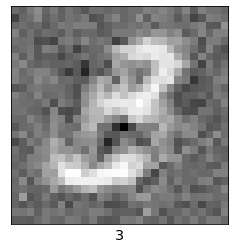

Epoch 27: Batch 1200 Discrim loss 0.013027067296206951, Generator loss 1.3978468179702759


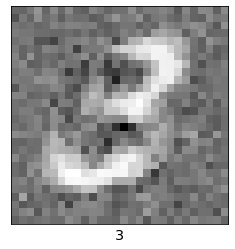

Epoch 27: Batch 1300 Discrim loss 0.015071726404130459, Generator loss 3.030484676361084


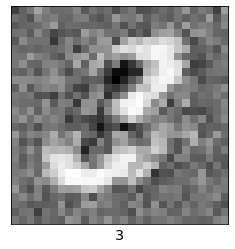

Epoch 27: Batch 1400 Discrim loss 0.2792246639728546, Generator loss 1.330244541168213


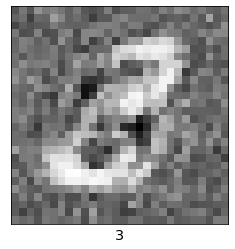

Epoch 27: Batch 1500 Discrim loss 0.03405233845114708, Generator loss 1.4583933353424072


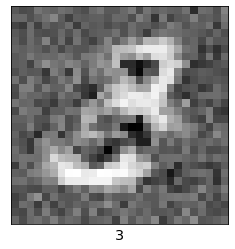

Epoch 27: Batch 1600 Discrim loss 0.03803796321153641, Generator loss 1.0500733852386475


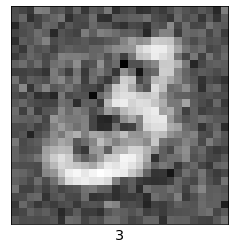

Epoch 27: Batch 1700 Discrim loss 0.033776089549064636, Generator loss 1.411421298980713


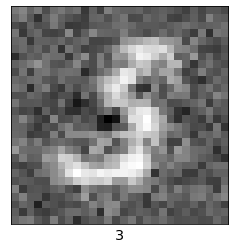

Epoch 27: Batch 1800 Discrim loss 0.006935558281838894, Generator loss 1.9608310461044312


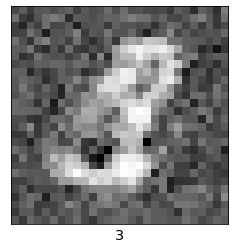

Epoch 28: Batch 0 Discrim loss 0.4002315104007721, Generator loss 1.7169520854949951


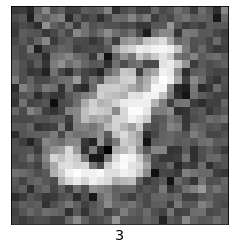

Epoch 28: Batch 100 Discrim loss 0.21030712127685547, Generator loss 1.2158126831054688


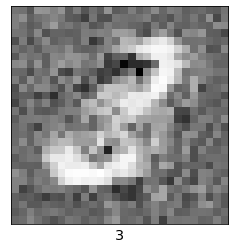

Epoch 28: Batch 200 Discrim loss 0.008491972461342812, Generator loss 1.1055622100830078


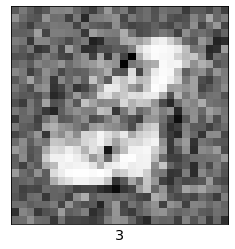

Epoch 28: Batch 300 Discrim loss 0.017715884372591972, Generator loss 1.54545259475708


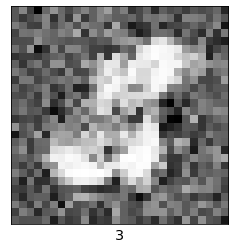

Epoch 28: Batch 400 Discrim loss 0.0517573282122612, Generator loss 0.8072497248649597


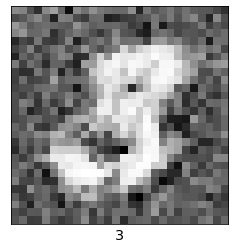

Epoch 28: Batch 500 Discrim loss 0.03651012107729912, Generator loss 1.1779977083206177


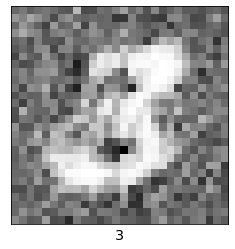

Epoch 28: Batch 600 Discrim loss 0.027710042893886566, Generator loss 0.4699954092502594


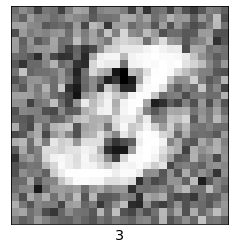

Epoch 28: Batch 700 Discrim loss 0.3231714069843292, Generator loss 1.6203190088272095


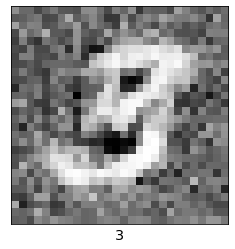

Epoch 28: Batch 800 Discrim loss 0.09688150882720947, Generator loss 1.0368527173995972


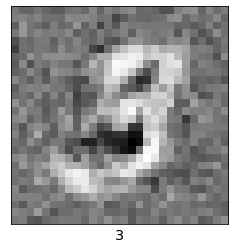

Epoch 28: Batch 900 Discrim loss 0.03945810720324516, Generator loss 2.069990634918213


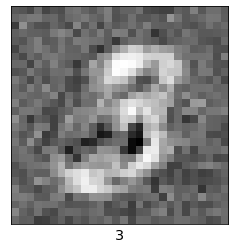

Epoch 28: Batch 1000 Discrim loss 0.10416392982006073, Generator loss 1.058691143989563


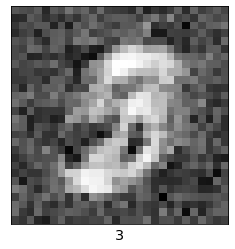

Epoch 28: Batch 1100 Discrim loss 0.036191605031490326, Generator loss 0.9863470196723938


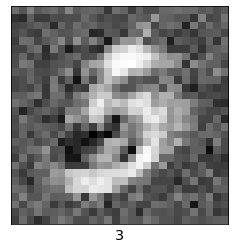

Epoch 28: Batch 1200 Discrim loss 0.03946339339017868, Generator loss 1.4811458587646484


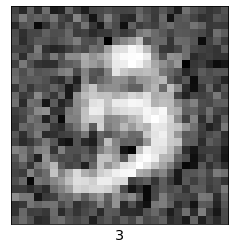

Epoch 28: Batch 1300 Discrim loss 0.057401686906814575, Generator loss 0.796481192111969


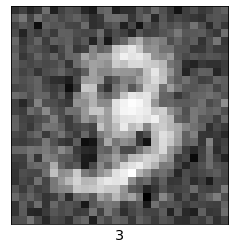

Epoch 28: Batch 1400 Discrim loss 0.09464018046855927, Generator loss 1.4766954183578491


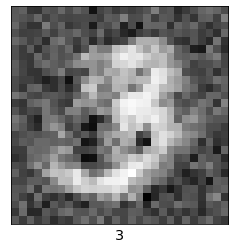

Epoch 28: Batch 1500 Discrim loss 0.004045491572469473, Generator loss 1.9635438919067383


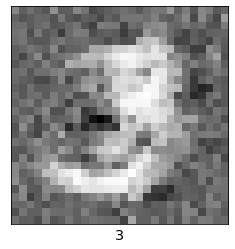

Epoch 28: Batch 1600 Discrim loss 0.04824216291308403, Generator loss 1.1096264123916626


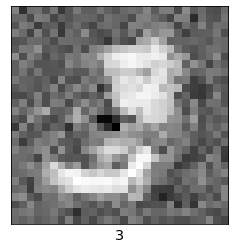

Epoch 28: Batch 1700 Discrim loss 0.004837479442358017, Generator loss 1.172607660293579


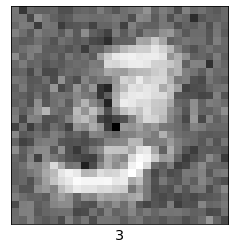

Epoch 28: Batch 1800 Discrim loss 0.04682115465402603, Generator loss 1.997826099395752


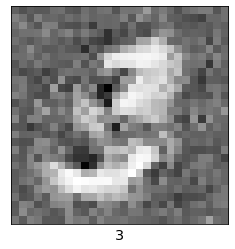

Epoch 29: Batch 0 Discrim loss 0.11452598869800568, Generator loss 1.1191092729568481


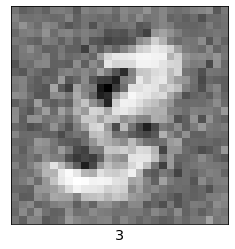

Epoch 29: Batch 100 Discrim loss 0.18111102283000946, Generator loss 0.6540353298187256


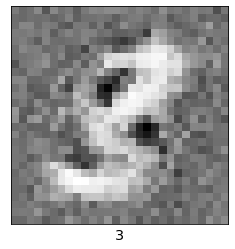

Epoch 29: Batch 200 Discrim loss 0.03425784409046173, Generator loss 1.7699434757232666


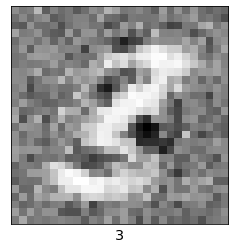

Epoch 29: Batch 300 Discrim loss 0.1630432903766632, Generator loss 1.4679229259490967


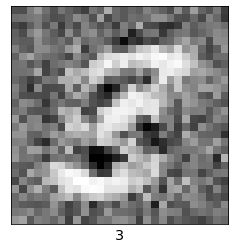

Epoch 29: Batch 400 Discrim loss 0.037827081978321075, Generator loss 1.1601359844207764


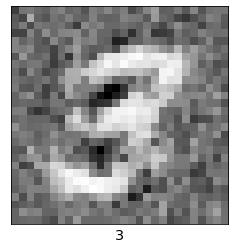

Epoch 29: Batch 500 Discrim loss 0.022171085700392723, Generator loss 1.320595383644104


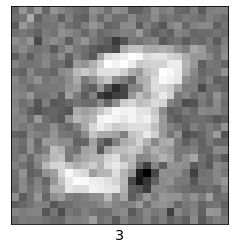

Epoch 29: Batch 600 Discrim loss 0.11046601831912994, Generator loss 0.9950804114341736


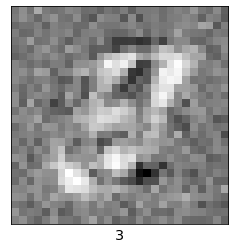

Epoch 29: Batch 700 Discrim loss 0.019080467522144318, Generator loss 1.7771213054656982


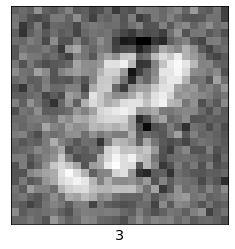

Epoch 29: Batch 800 Discrim loss 0.03134085610508919, Generator loss 0.8090292811393738


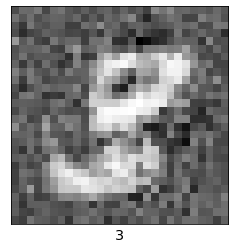

Epoch 29: Batch 900 Discrim loss 0.21304842829704285, Generator loss 0.5441979765892029


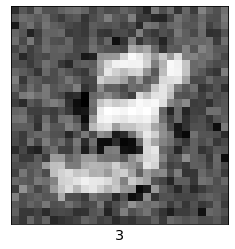

Epoch 29: Batch 1000 Discrim loss 0.009532690979540348, Generator loss 1.1118093729019165


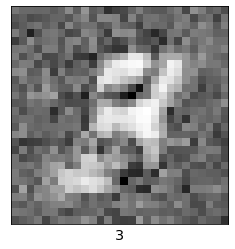

Epoch 29: Batch 1100 Discrim loss 0.08062392473220825, Generator loss 0.6442871689796448


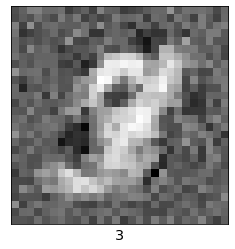

Epoch 29: Batch 1200 Discrim loss 0.16428017616271973, Generator loss 0.8966839909553528


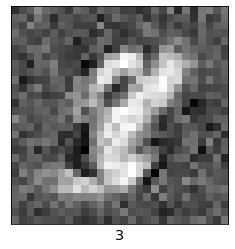

Epoch 29: Batch 1300 Discrim loss 0.019649919122457504, Generator loss 1.3337421417236328


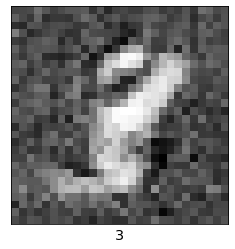

Epoch 29: Batch 1400 Discrim loss 0.02235983870923519, Generator loss 1.7427774667739868


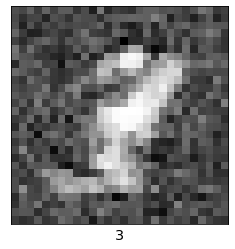

Epoch 29: Batch 1500 Discrim loss 0.01868443377315998, Generator loss 1.2781895399093628


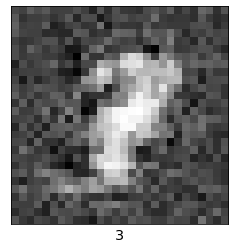

Epoch 29: Batch 1600 Discrim loss 0.009078821167349815, Generator loss 0.5100077390670776


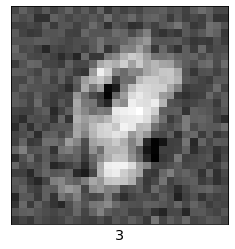

Epoch 29: Batch 1700 Discrim loss 0.19870874285697937, Generator loss 1.1788511276245117


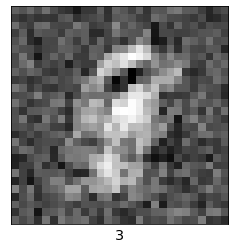

Epoch 29: Batch 1800 Discrim loss 0.12210116535425186, Generator loss 0.7193762063980103


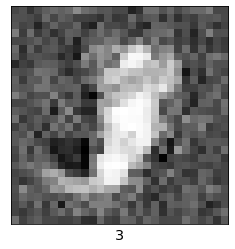

Epoch 30: Batch 0 Discrim loss 0.19571085274219513, Generator loss 1.7883429527282715


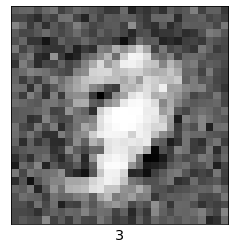

Epoch 30: Batch 100 Discrim loss 0.015435152687132359, Generator loss 0.7419396042823792


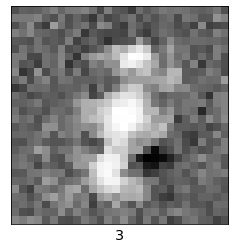

Epoch 30: Batch 200 Discrim loss 0.02942032739520073, Generator loss 0.818894624710083


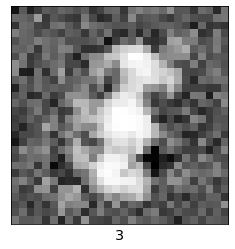

Epoch 30: Batch 300 Discrim loss 0.004625910893082619, Generator loss 1.6532540321350098


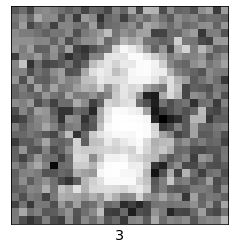

Epoch 30: Batch 400 Discrim loss 0.012524869292974472, Generator loss 2.3193438053131104


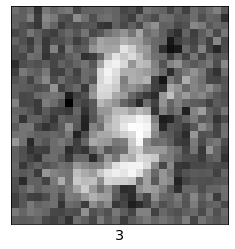

Epoch 30: Batch 500 Discrim loss 0.038850389420986176, Generator loss 2.0715320110321045


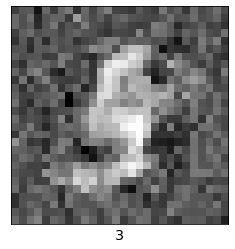

Epoch 30: Batch 600 Discrim loss 0.011922807432711124, Generator loss 1.142748475074768


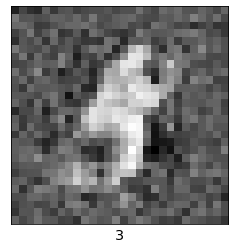

Epoch 30: Batch 700 Discrim loss 0.00581735372543335, Generator loss 1.7658635377883911


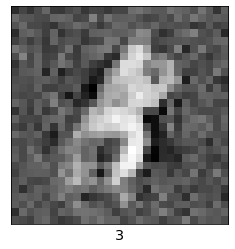

Epoch 30: Batch 800 Discrim loss 0.009580197744071484, Generator loss 1.1921067237854004


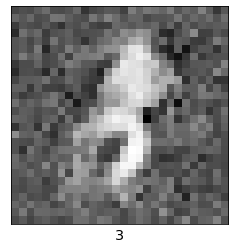

Epoch 30: Batch 900 Discrim loss 0.08241095393896103, Generator loss 0.8776845335960388


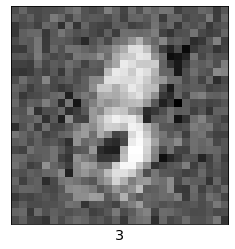

Epoch 30: Batch 1000 Discrim loss 0.0034231990575790405, Generator loss 0.3194652795791626


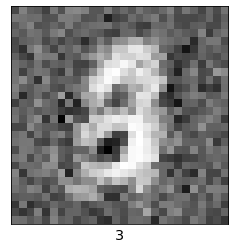

Epoch 30: Batch 1100 Discrim loss 0.16209745407104492, Generator loss 2.1804025173187256


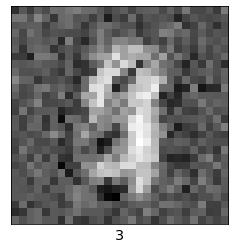

Epoch 30: Batch 1200 Discrim loss 0.06040980666875839, Generator loss 1.7166882753372192


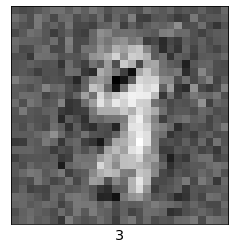

Epoch 30: Batch 1300 Discrim loss 0.00795738585293293, Generator loss 1.2049305438995361


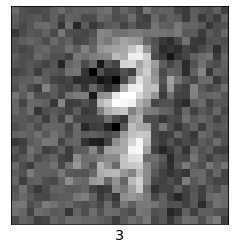

Epoch 30: Batch 1400 Discrim loss 0.21456500887870789, Generator loss 1.7992615699768066


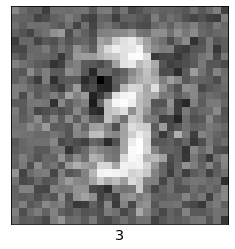

Epoch 30: Batch 1500 Discrim loss 0.04302838444709778, Generator loss 0.28395047783851624


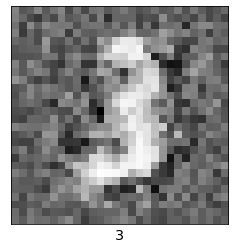

Epoch 30: Batch 1600 Discrim loss 0.03034093976020813, Generator loss 0.8726934790611267


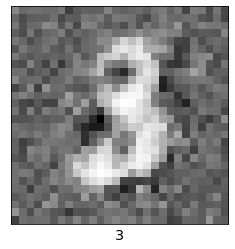

Epoch 30: Batch 1700 Discrim loss 0.25897079706192017, Generator loss 1.1391297578811646


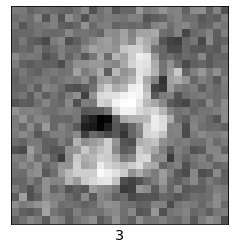

Epoch 30: Batch 1800 Discrim loss 0.07479987293481827, Generator loss 1.5284358263015747


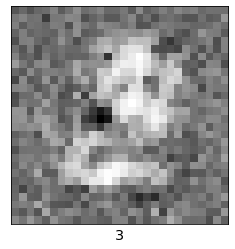

Epoch 31: Batch 0 Discrim loss 0.014022834599018097, Generator loss 1.186181902885437


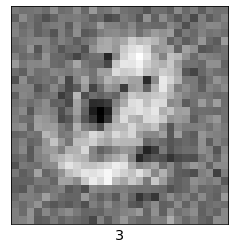

Epoch 31: Batch 100 Discrim loss 0.011461722664535046, Generator loss 0.6109223961830139


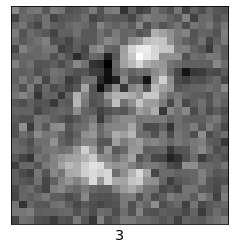

Epoch 31: Batch 200 Discrim loss 0.051102858036756516, Generator loss 1.171257495880127


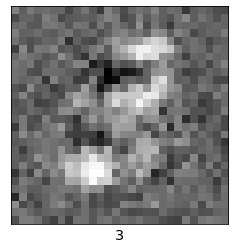

Epoch 31: Batch 300 Discrim loss 0.5515328049659729, Generator loss 1.3810150623321533


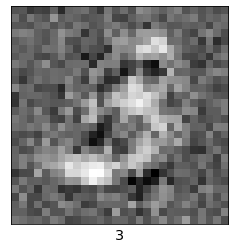

Epoch 31: Batch 400 Discrim loss 0.01119676697999239, Generator loss 0.24118787050247192


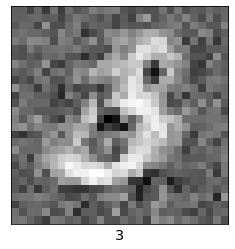

Epoch 31: Batch 500 Discrim loss 0.017101828008890152, Generator loss 1.6904467344284058


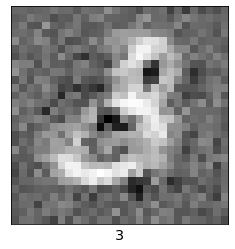

Epoch 31: Batch 600 Discrim loss 0.34090685844421387, Generator loss 1.6152456998825073


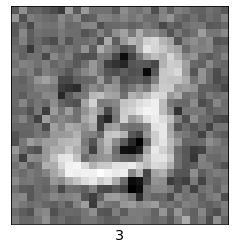

Epoch 31: Batch 700 Discrim loss 0.19470927119255066, Generator loss 3.1499695777893066


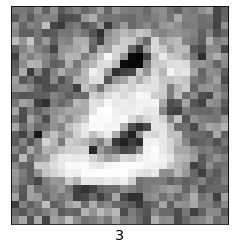

Epoch 31: Batch 800 Discrim loss 0.023871641606092453, Generator loss 1.1307095289230347


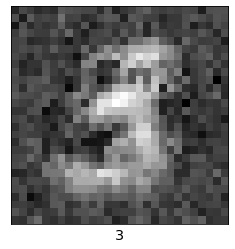

Epoch 31: Batch 900 Discrim loss 0.023349110037088394, Generator loss 1.9995815753936768


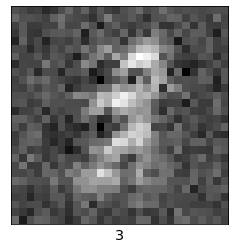

Epoch 31: Batch 1000 Discrim loss 0.03949702903628349, Generator loss 1.032390832901001


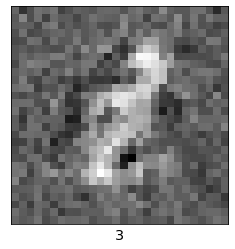

Epoch 31: Batch 1100 Discrim loss 0.03272083029150963, Generator loss 0.8335393071174622


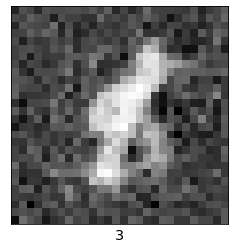

Epoch 31: Batch 1200 Discrim loss 0.02535002864897251, Generator loss 1.238269329071045


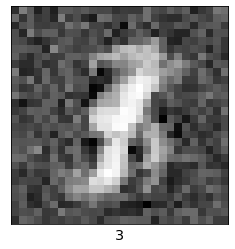

Epoch 31: Batch 1300 Discrim loss 0.0024222717620432377, Generator loss 1.497388482093811


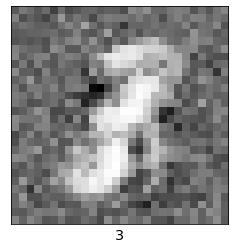

Epoch 31: Batch 1400 Discrim loss 0.009255321696400642, Generator loss 0.6384568214416504


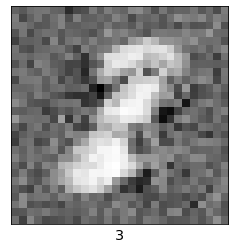

Epoch 31: Batch 1500 Discrim loss 0.24159033596515656, Generator loss 1.2651357650756836


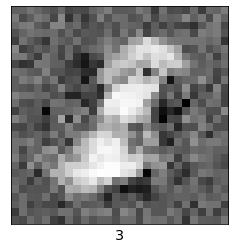

Epoch 31: Batch 1600 Discrim loss 0.007357979193329811, Generator loss 0.38547155261039734


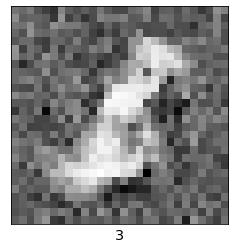

Epoch 31: Batch 1700 Discrim loss 0.0036928055342286825, Generator loss 1.730268955230713


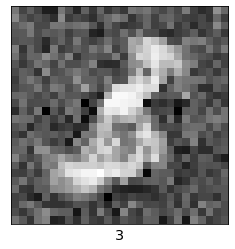

Epoch 31: Batch 1800 Discrim loss 0.036724165081977844, Generator loss 1.227137565612793


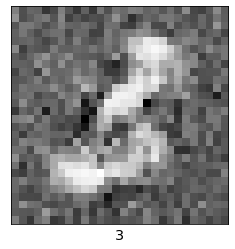

Epoch 32: Batch 0 Discrim loss 0.01221135538071394, Generator loss 1.9727425575256348


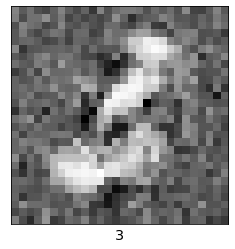

Epoch 32: Batch 100 Discrim loss 0.3060191869735718, Generator loss 0.7316886782646179


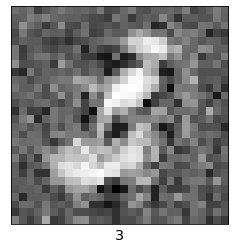

Epoch 32: Batch 200 Discrim loss 0.04144887998700142, Generator loss 0.42740917205810547


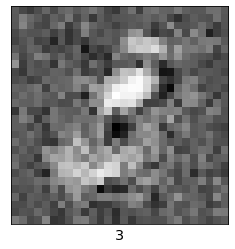

Epoch 32: Batch 300 Discrim loss 0.021046631038188934, Generator loss 1.9342719316482544


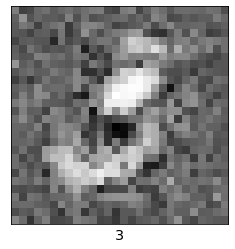

Epoch 32: Batch 400 Discrim loss 0.004929762799292803, Generator loss 1.4578546285629272


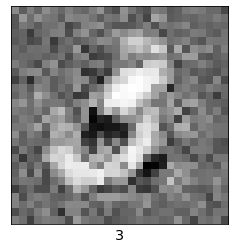

Epoch 32: Batch 500 Discrim loss 0.005246696062386036, Generator loss 0.2284083068370819


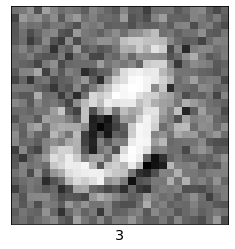

Epoch 32: Batch 600 Discrim loss 0.009886019863188267, Generator loss 0.6135490536689758


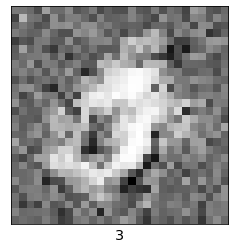

Epoch 32: Batch 700 Discrim loss 0.00590983871370554, Generator loss 1.5690879821777344


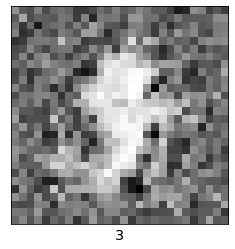

Epoch 32: Batch 800 Discrim loss 0.13343212008476257, Generator loss 2.4113216400146484


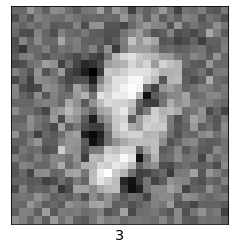

Epoch 32: Batch 900 Discrim loss 0.07948127388954163, Generator loss 1.7112517356872559


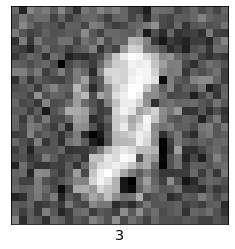

Epoch 32: Batch 1000 Discrim loss 0.05550951510667801, Generator loss 0.7404372692108154


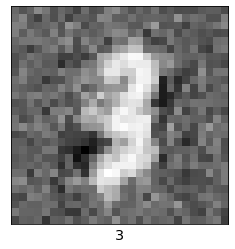

Epoch 32: Batch 1100 Discrim loss 0.06818927824497223, Generator loss 1.3177796602249146


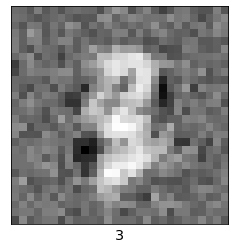

Epoch 32: Batch 1200 Discrim loss 0.012784301303327084, Generator loss 1.1391713619232178


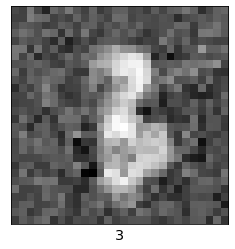

Epoch 32: Batch 1300 Discrim loss 0.07583118230104446, Generator loss 1.0979712009429932


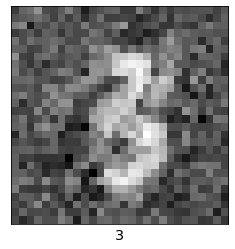

Epoch 32: Batch 1400 Discrim loss 0.049256663769483566, Generator loss 2.3485989570617676


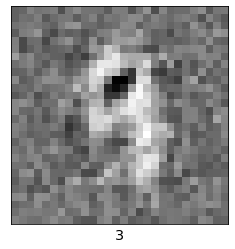

Epoch 32: Batch 1500 Discrim loss 0.039678849279880524, Generator loss 1.0626628398895264


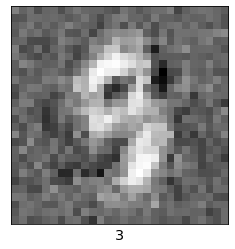

Epoch 32: Batch 1600 Discrim loss 0.04020171985030174, Generator loss 0.3933563232421875


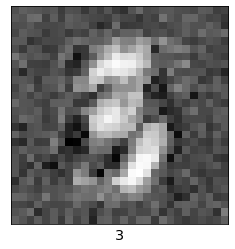

Epoch 32: Batch 1700 Discrim loss 0.056735776364803314, Generator loss 1.0840227603912354


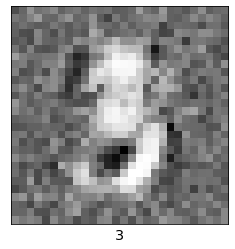

Epoch 32: Batch 1800 Discrim loss 0.23945985734462738, Generator loss 1.6029928922653198


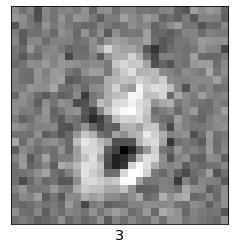

Epoch 33: Batch 0 Discrim loss 0.004932999145239592, Generator loss 1.340138554573059


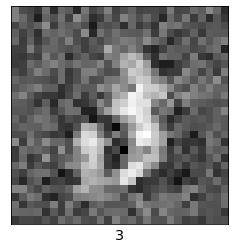

Epoch 33: Batch 100 Discrim loss 0.08458477258682251, Generator loss 1.031875729560852


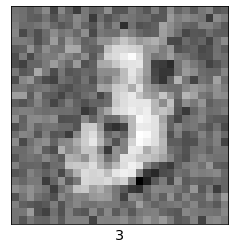

Epoch 33: Batch 200 Discrim loss 0.01950792223215103, Generator loss 0.9870951175689697


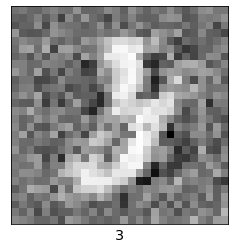

Epoch 33: Batch 300 Discrim loss 0.027462167665362358, Generator loss 0.9313265681266785


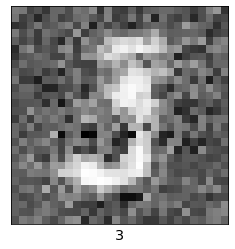

Epoch 33: Batch 400 Discrim loss 0.01953122206032276, Generator loss 0.889790415763855


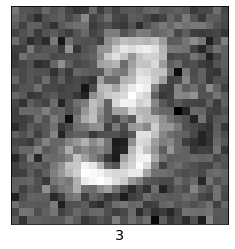

Epoch 33: Batch 500 Discrim loss 0.008529704995453358, Generator loss 0.6160691976547241


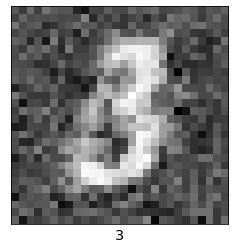

Epoch 33: Batch 600 Discrim loss 0.2745184302330017, Generator loss 0.8288415670394897


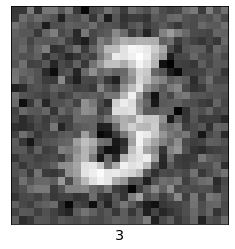

Epoch 33: Batch 700 Discrim loss 0.010265232995152473, Generator loss 1.9017908573150635


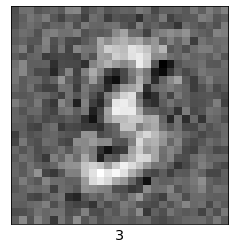

Epoch 33: Batch 800 Discrim loss 0.017307614907622337, Generator loss 1.2835414409637451


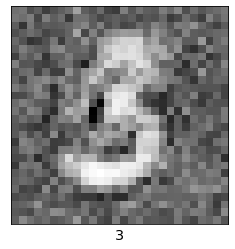

Epoch 33: Batch 900 Discrim loss 0.012871085666120052, Generator loss 1.015188217163086


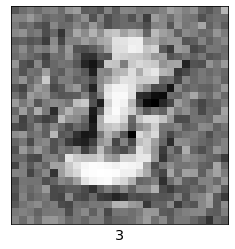

Epoch 33: Batch 1000 Discrim loss 0.013031808659434319, Generator loss 1.7549115419387817


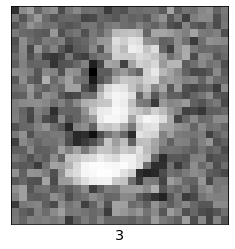

Epoch 33: Batch 1100 Discrim loss 0.0032552056945860386, Generator loss 1.7359869480133057


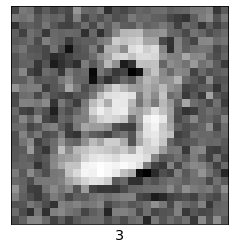

Epoch 33: Batch 1200 Discrim loss 0.032467857003211975, Generator loss 1.738918662071228


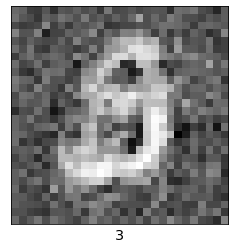

Epoch 33: Batch 1300 Discrim loss 0.04024292528629303, Generator loss 1.6611790657043457


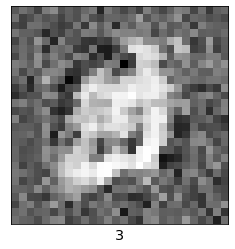

Epoch 33: Batch 1400 Discrim loss 0.006581505294889212, Generator loss 1.1700654029846191


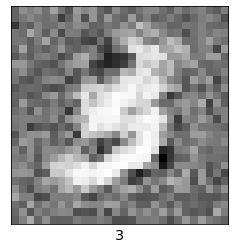

Epoch 33: Batch 1500 Discrim loss 0.007325736805796623, Generator loss 0.8322330713272095


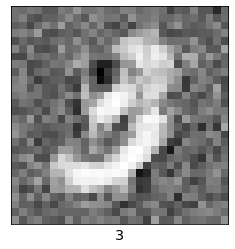

Epoch 33: Batch 1600 Discrim loss 0.13893471658229828, Generator loss 1.1186630725860596


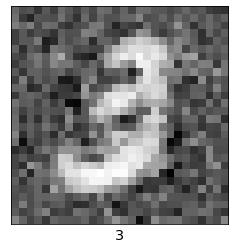

Epoch 33: Batch 1700 Discrim loss 0.008280669339001179, Generator loss 1.9124113321304321


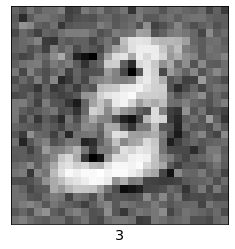

Epoch 33: Batch 1800 Discrim loss 0.005755279678851366, Generator loss 0.7406049966812134


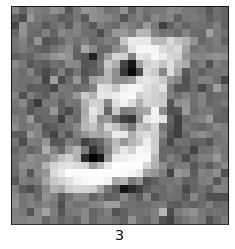

Epoch 34: Batch 0 Discrim loss 0.07469333708286285, Generator loss 1.0378228425979614


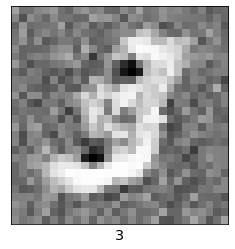

Epoch 34: Batch 100 Discrim loss 0.020926721394062042, Generator loss 2.1736879348754883


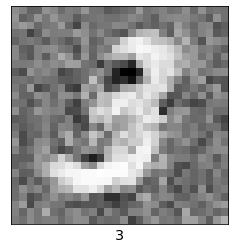

Epoch 34: Batch 200 Discrim loss 0.01960625872015953, Generator loss 1.6711084842681885


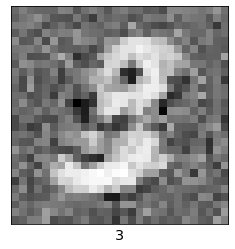

Epoch 34: Batch 300 Discrim loss 0.012068542651832104, Generator loss 0.46711230278015137


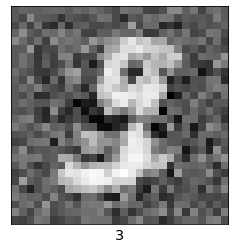

Epoch 34: Batch 400 Discrim loss 0.08447283506393433, Generator loss 0.6602505445480347


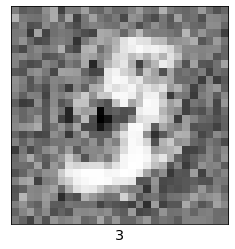

Epoch 34: Batch 500 Discrim loss 0.1847754418849945, Generator loss 1.5549814701080322


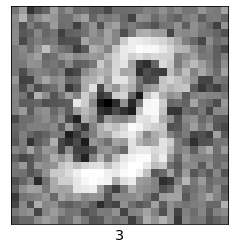

Epoch 34: Batch 600 Discrim loss 0.009660000912845135, Generator loss 1.0063025951385498


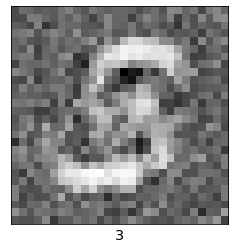

Epoch 34: Batch 700 Discrim loss 0.09496600925922394, Generator loss 0.5282279253005981


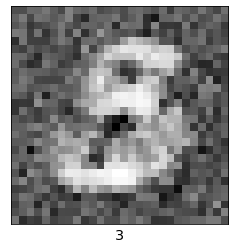

Epoch 34: Batch 800 Discrim loss 0.052059877663850784, Generator loss 2.710780382156372


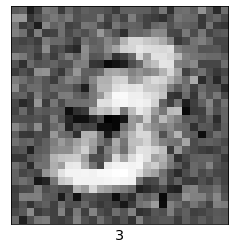

Epoch 34: Batch 900 Discrim loss 0.001011541811749339, Generator loss 1.188677430152893


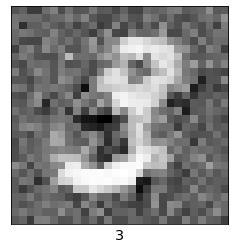

Epoch 34: Batch 1000 Discrim loss 0.024259747937321663, Generator loss 1.2216570377349854


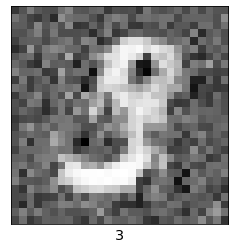

Epoch 34: Batch 1100 Discrim loss 0.01767577975988388, Generator loss 0.8675072193145752


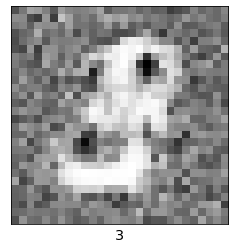

Epoch 34: Batch 1200 Discrim loss 0.016551213338971138, Generator loss 1.3836748600006104


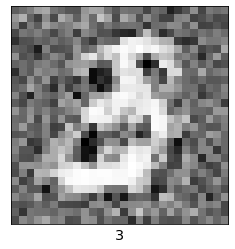

Epoch 34: Batch 1300 Discrim loss 0.07791756838560104, Generator loss 1.939867615699768


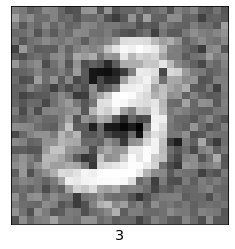

Epoch 34: Batch 1400 Discrim loss 0.14234226942062378, Generator loss 1.051100730895996


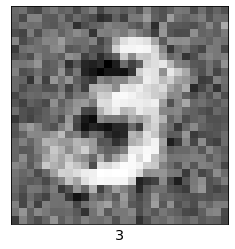

Epoch 34: Batch 1500 Discrim loss 0.2309054434299469, Generator loss 1.1769005060195923


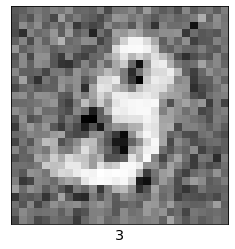

Epoch 34: Batch 1600 Discrim loss 0.017425233498215675, Generator loss 0.18177899718284607


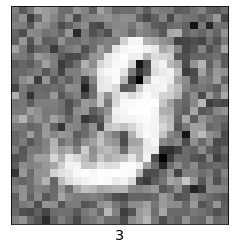

Epoch 34: Batch 1700 Discrim loss 0.0045598591677844524, Generator loss 0.7116159200668335


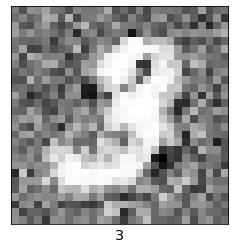

Epoch 34: Batch 1800 Discrim loss 0.028642727062106133, Generator loss 1.8433520793914795


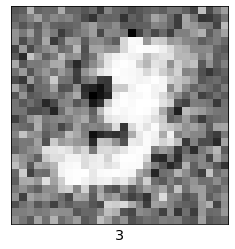

Epoch 35: Batch 0 Discrim loss 0.025166954845190048, Generator loss 2.503512382507324


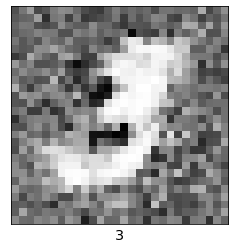

Epoch 35: Batch 100 Discrim loss 0.09645277261734009, Generator loss 0.6920065879821777


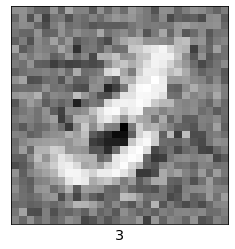

Epoch 35: Batch 200 Discrim loss 0.04850448668003082, Generator loss 0.9612376689910889


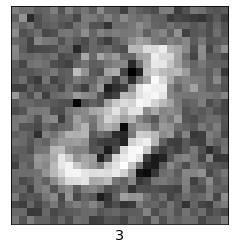

Epoch 35: Batch 300 Discrim loss 0.007789179217070341, Generator loss 1.3067429065704346


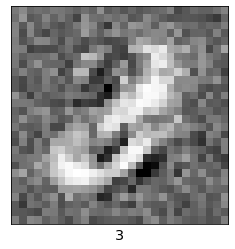

Epoch 35: Batch 400 Discrim loss 0.012027861550450325, Generator loss 1.0302355289459229


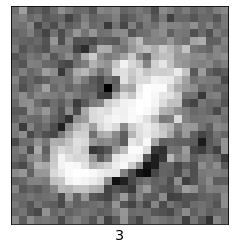

Epoch 35: Batch 500 Discrim loss 0.06495936959981918, Generator loss 1.185366153717041


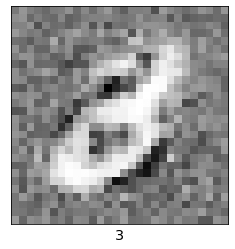

Epoch 35: Batch 600 Discrim loss 0.007889430969953537, Generator loss 1.0379540920257568


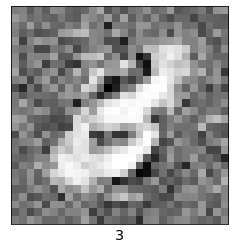

Epoch 35: Batch 700 Discrim loss 0.19348065555095673, Generator loss 1.6206611394882202


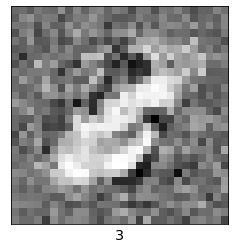

Epoch 35: Batch 800 Discrim loss 0.08664161711931229, Generator loss 0.9705204963684082


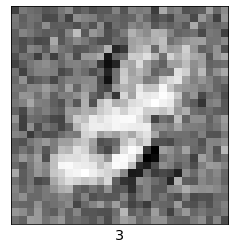

Epoch 35: Batch 900 Discrim loss 0.05561772733926773, Generator loss 2.7591300010681152


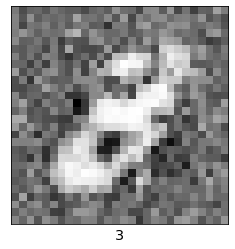

Epoch 35: Batch 1000 Discrim loss 0.3691543936729431, Generator loss 1.7060506343841553


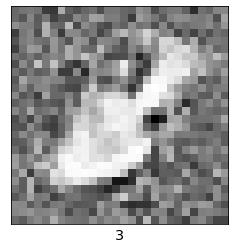

Epoch 35: Batch 1100 Discrim loss 0.02818775735795498, Generator loss 1.3445106744766235


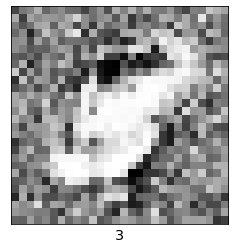

Epoch 35: Batch 1200 Discrim loss 0.07670195400714874, Generator loss 1.31572687625885


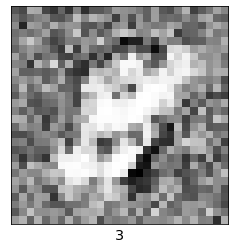

Epoch 35: Batch 1300 Discrim loss 0.424721896648407, Generator loss 1.500931739807129


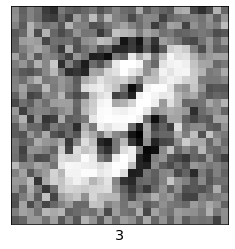

Epoch 35: Batch 1400 Discrim loss 0.026612624526023865, Generator loss 0.9925844669342041


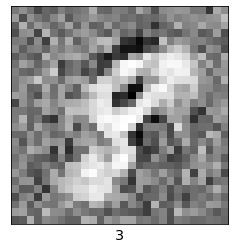

Epoch 35: Batch 1500 Discrim loss 0.1771874576807022, Generator loss 1.09474515914917


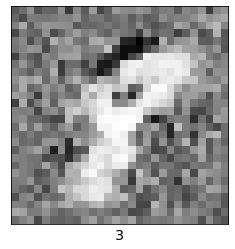

Epoch 35: Batch 1600 Discrim loss 0.006250718142837286, Generator loss 1.273982048034668


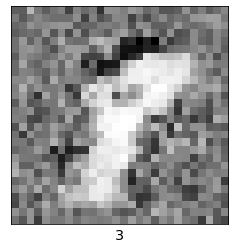

Epoch 35: Batch 1700 Discrim loss 0.003134525613859296, Generator loss 1.21147882938385


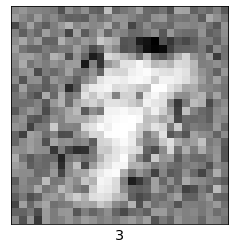

Epoch 35: Batch 1800 Discrim loss 0.1725635826587677, Generator loss 1.4890382289886475


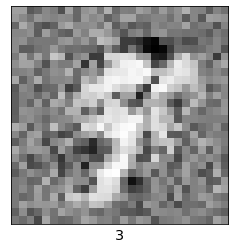

Epoch 36: Batch 0 Discrim loss 0.10246996581554413, Generator loss 0.9540728330612183


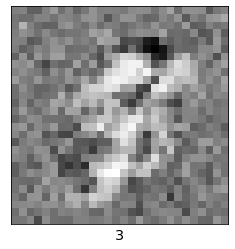

Epoch 36: Batch 100 Discrim loss 0.07868465781211853, Generator loss 0.7615018486976624


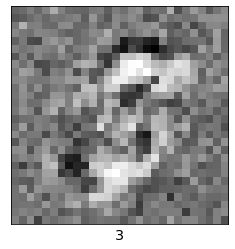

Epoch 36: Batch 200 Discrim loss 0.017950059846043587, Generator loss 1.2181626558303833


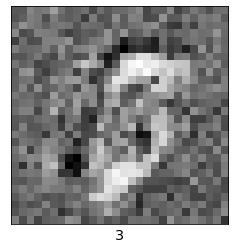

Epoch 36: Batch 300 Discrim loss 0.08499057590961456, Generator loss 0.7986506223678589


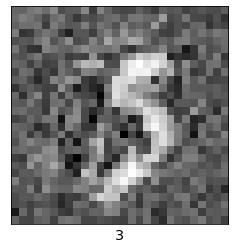

Epoch 36: Batch 400 Discrim loss 0.403119295835495, Generator loss 0.794639527797699


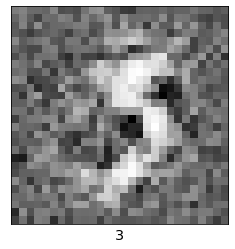

Epoch 36: Batch 500 Discrim loss 0.006372624076902866, Generator loss 1.7899470329284668


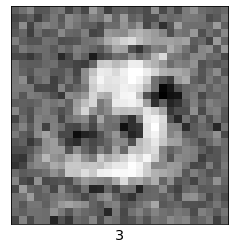

Epoch 36: Batch 600 Discrim loss 0.03555633872747421, Generator loss 0.8203060626983643


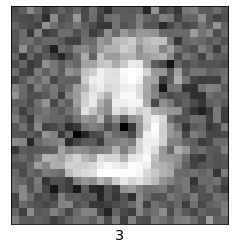

Epoch 36: Batch 700 Discrim loss 0.017194189131259918, Generator loss 1.2619168758392334


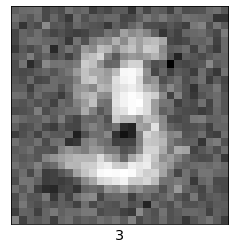

Epoch 36: Batch 800 Discrim loss 0.07316439598798752, Generator loss 0.8662914037704468


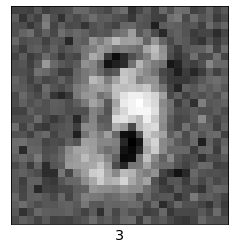

Epoch 36: Batch 900 Discrim loss 0.07809028774499893, Generator loss 1.517996907234192


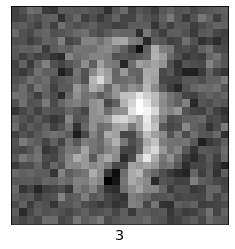

Epoch 36: Batch 1000 Discrim loss 0.018969876691699028, Generator loss 1.1243793964385986


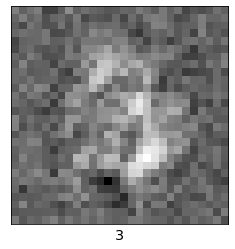

Epoch 36: Batch 1100 Discrim loss 0.027415180578827858, Generator loss 0.6430995464324951


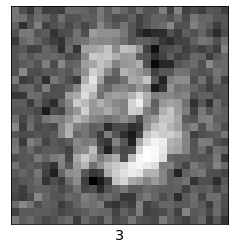

Epoch 36: Batch 1200 Discrim loss 0.1002911627292633, Generator loss 2.2487168312072754


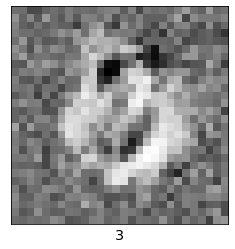

Epoch 36: Batch 1300 Discrim loss 0.10216058790683746, Generator loss 1.6188676357269287


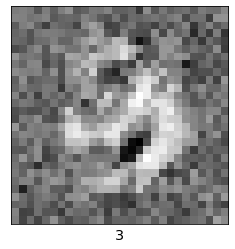

Epoch 36: Batch 1400 Discrim loss 0.05544948950409889, Generator loss 0.5517816543579102


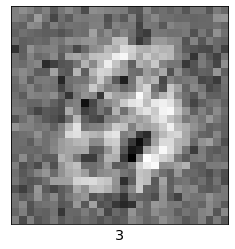

Epoch 36: Batch 1500 Discrim loss 0.01602376252412796, Generator loss 1.0571603775024414


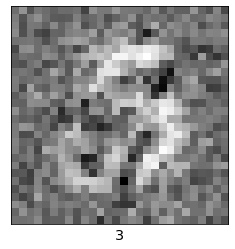

Epoch 36: Batch 1600 Discrim loss 0.00421728054061532, Generator loss 1.5675251483917236


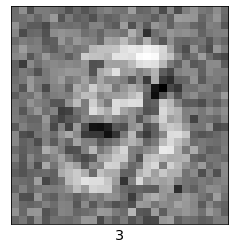

Epoch 36: Batch 1700 Discrim loss 0.007360036019235849, Generator loss 1.3610265254974365


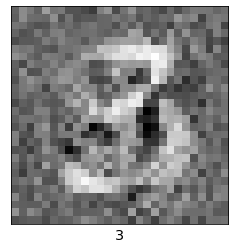

Epoch 36: Batch 1800 Discrim loss 0.19615046679973602, Generator loss 1.1505070924758911


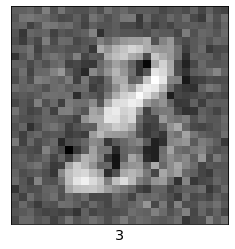

Epoch 37: Batch 0 Discrim loss 0.11105076968669891, Generator loss 1.2886934280395508


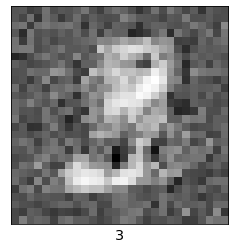

Epoch 37: Batch 100 Discrim loss 0.004413159564137459, Generator loss 1.5111215114593506


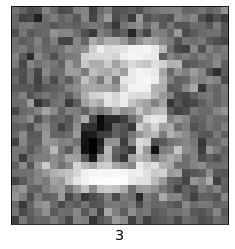

Epoch 37: Batch 200 Discrim loss 0.1112099289894104, Generator loss 0.6607638597488403


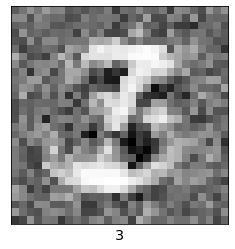

Epoch 37: Batch 300 Discrim loss 0.288875937461853, Generator loss 1.17402184009552


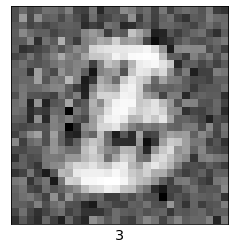

Epoch 37: Batch 400 Discrim loss 0.018655113875865936, Generator loss 0.941389799118042


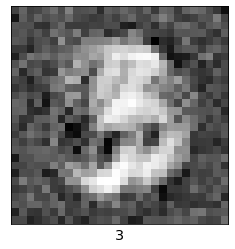

Epoch 37: Batch 500 Discrim loss 0.226485013961792, Generator loss 0.9439764022827148


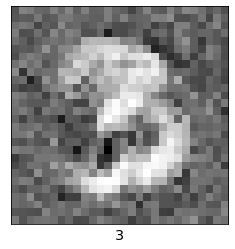

Epoch 37: Batch 600 Discrim loss 0.20357975363731384, Generator loss 1.5130716562271118


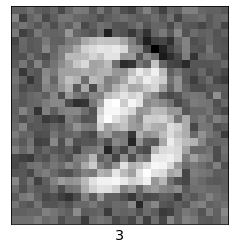

Epoch 37: Batch 700 Discrim loss 0.0225411094725132, Generator loss 1.5218394994735718


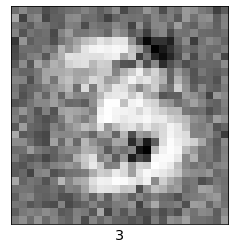

Epoch 37: Batch 800 Discrim loss 0.12777040898799896, Generator loss 1.4317585229873657


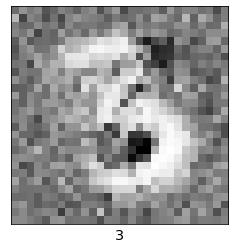

Epoch 37: Batch 900 Discrim loss 0.2089608758687973, Generator loss 0.3782466650009155


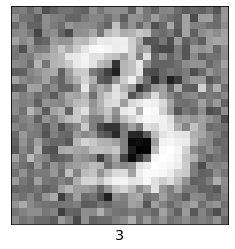

Epoch 37: Batch 1000 Discrim loss 0.17022676765918732, Generator loss 0.831087052822113


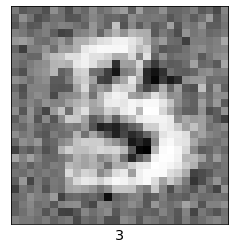

Epoch 37: Batch 1100 Discrim loss 0.05287402123212814, Generator loss 0.9275733828544617


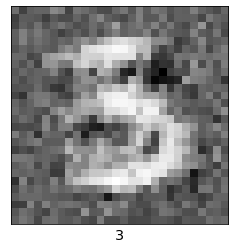

Epoch 37: Batch 1200 Discrim loss 0.052403293550014496, Generator loss 1.1214911937713623


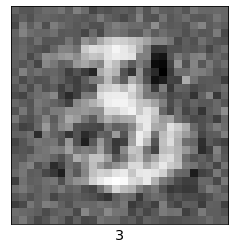

Epoch 37: Batch 1300 Discrim loss 0.011578728444874287, Generator loss 1.8623111248016357


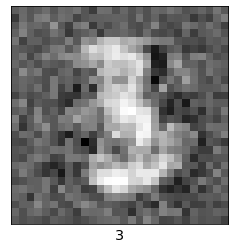

Epoch 37: Batch 1400 Discrim loss 0.05830322206020355, Generator loss 1.7322313785552979


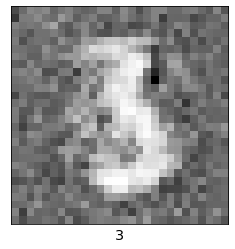

Epoch 37: Batch 1500 Discrim loss 0.12033046036958694, Generator loss 2.4605460166931152


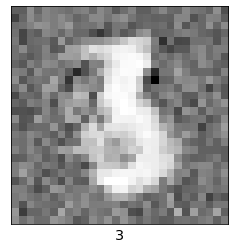

Epoch 37: Batch 1600 Discrim loss 0.008926359005272388, Generator loss 0.9649802446365356


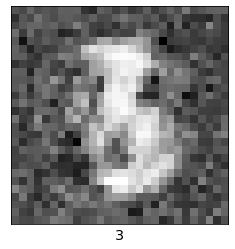

Epoch 37: Batch 1700 Discrim loss 0.25755807757377625, Generator loss 0.9152736663818359


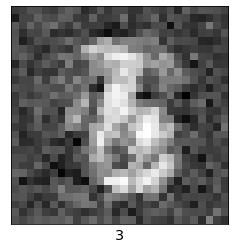

Epoch 37: Batch 1800 Discrim loss 0.0160810649394989, Generator loss 1.5114140510559082


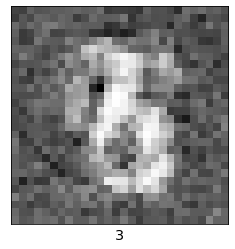

Epoch 38: Batch 0 Discrim loss 0.003263121470808983, Generator loss 1.941237449645996


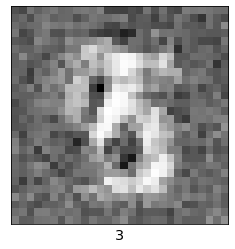

Epoch 38: Batch 100 Discrim loss 0.18783870339393616, Generator loss 1.5909004211425781


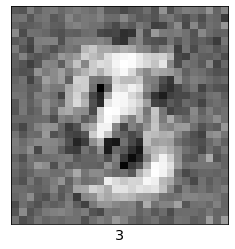

Epoch 38: Batch 200 Discrim loss 0.024776343256235123, Generator loss 1.4608968496322632


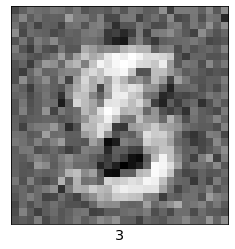

Epoch 38: Batch 300 Discrim loss 0.17018276453018188, Generator loss 1.0480618476867676


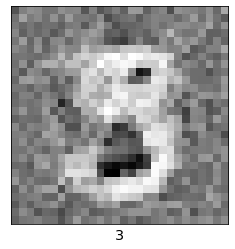

Epoch 38: Batch 400 Discrim loss 0.03647470846772194, Generator loss 1.6805806159973145


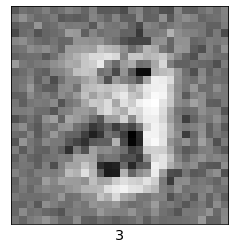

Epoch 38: Batch 500 Discrim loss 0.052092768251895905, Generator loss 2.580808162689209


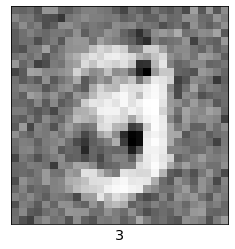

Epoch 38: Batch 600 Discrim loss 0.03349810093641281, Generator loss 1.3114721775054932


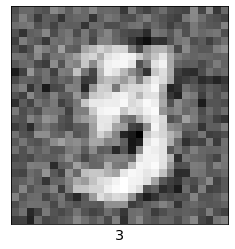

Epoch 38: Batch 700 Discrim loss 0.03623910993337631, Generator loss 0.9631352424621582


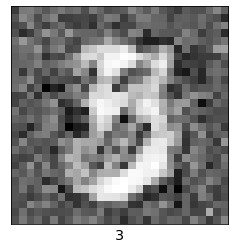

Epoch 38: Batch 800 Discrim loss 0.1778745949268341, Generator loss 1.585732340812683


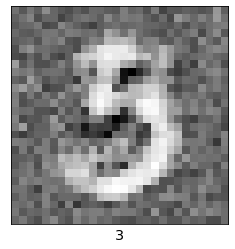

Epoch 38: Batch 900 Discrim loss 0.058902278542518616, Generator loss 1.5000791549682617


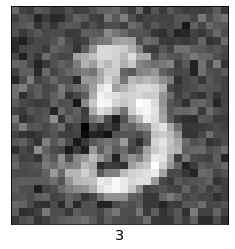

Epoch 38: Batch 1000 Discrim loss 0.013725785538554192, Generator loss 0.9873737096786499


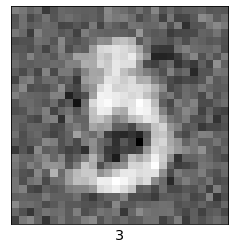

Epoch 38: Batch 1100 Discrim loss 0.022260820493102074, Generator loss 1.9732272624969482


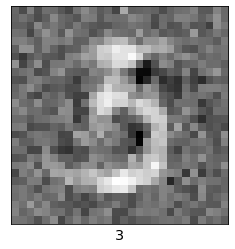

Epoch 38: Batch 1200 Discrim loss 0.011070184409618378, Generator loss 1.3689844608306885


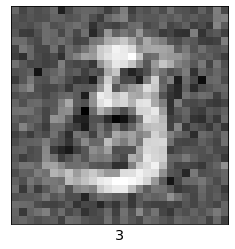

Epoch 38: Batch 1300 Discrim loss 0.006504451856017113, Generator loss 0.6127786636352539


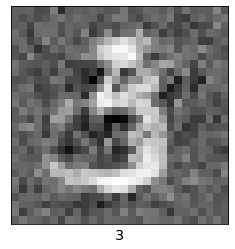

Epoch 38: Batch 1400 Discrim loss 0.020463835448026657, Generator loss 1.030314564704895


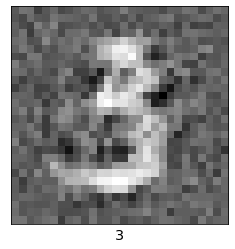

Epoch 38: Batch 1500 Discrim loss 0.03418587148189545, Generator loss 1.1207458972930908


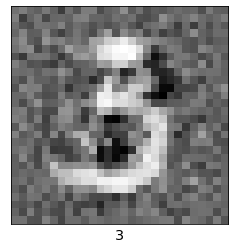

Epoch 38: Batch 1600 Discrim loss 0.02061145380139351, Generator loss 2.812835693359375


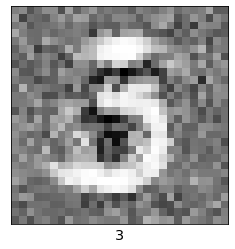

Epoch 38: Batch 1700 Discrim loss 0.027344942092895508, Generator loss 1.3158173561096191


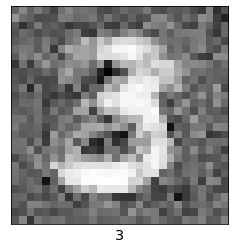

Epoch 38: Batch 1800 Discrim loss 0.26008909940719604, Generator loss 0.9404193162918091


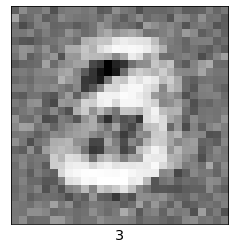

Epoch 39: Batch 0 Discrim loss 0.1242130845785141, Generator loss 1.247905969619751


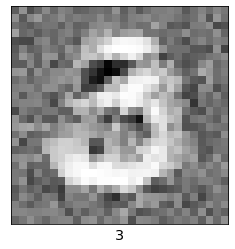

Epoch 39: Batch 100 Discrim loss 0.0212416909635067, Generator loss 0.948613703250885


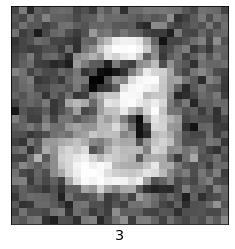

Epoch 39: Batch 200 Discrim loss 0.010786004364490509, Generator loss 1.9009456634521484


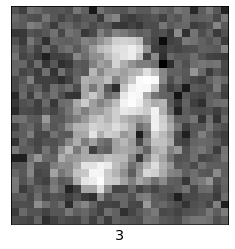

Epoch 39: Batch 300 Discrim loss 0.04000469297170639, Generator loss 1.522454023361206


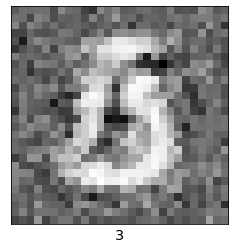

Epoch 39: Batch 400 Discrim loss 0.04659777134656906, Generator loss 1.3803067207336426


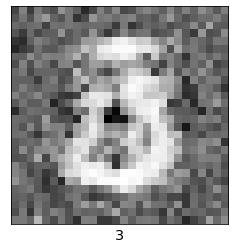

Epoch 39: Batch 500 Discrim loss 0.08795321732759476, Generator loss 2.3370604515075684


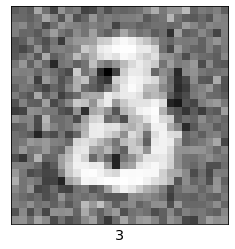

Epoch 39: Batch 600 Discrim loss 0.023765673860907555, Generator loss 0.45058953762054443


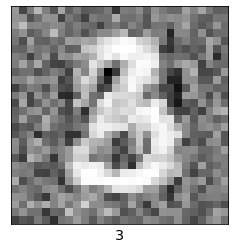

Epoch 39: Batch 700 Discrim loss 0.029119154438376427, Generator loss 0.8259812593460083


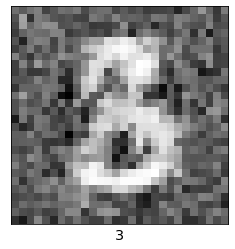

Epoch 39: Batch 800 Discrim loss 0.012646765448153019, Generator loss 1.8579682111740112


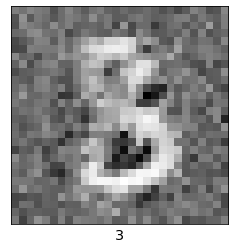

Epoch 39: Batch 900 Discrim loss 0.048508014529943466, Generator loss 1.1366550922393799


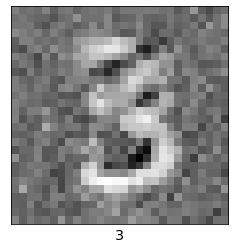

Epoch 39: Batch 1000 Discrim loss 0.03856092691421509, Generator loss 0.40635788440704346


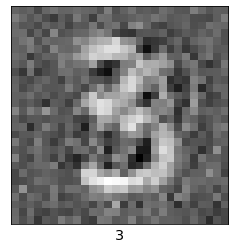

Epoch 39: Batch 1100 Discrim loss 0.031509339809417725, Generator loss 0.9218332767486572


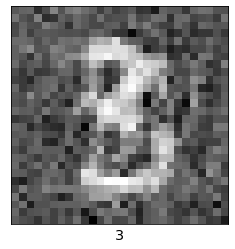

Epoch 39: Batch 1200 Discrim loss 0.04466249793767929, Generator loss 1.2957133054733276


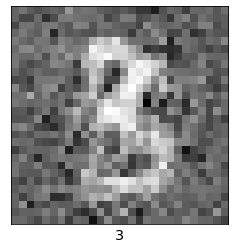

Epoch 39: Batch 1300 Discrim loss 0.03313246741890907, Generator loss 3.031259536743164


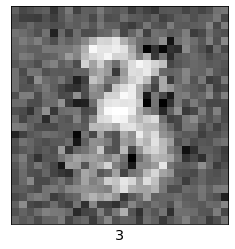

Epoch 39: Batch 1400 Discrim loss 0.06874598562717438, Generator loss 1.118225336074829


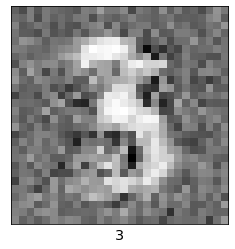

Epoch 39: Batch 1500 Discrim loss 0.030291948467493057, Generator loss 0.36059990525245667


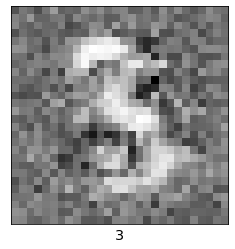

Epoch 39: Batch 1600 Discrim loss 0.12255513668060303, Generator loss 0.8500962853431702


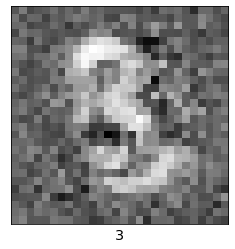

Epoch 39: Batch 1700 Discrim loss 0.07012300193309784, Generator loss 0.9556732177734375


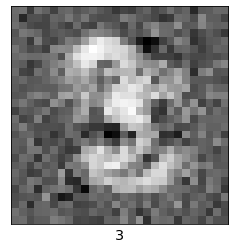

Epoch 39: Batch 1800 Discrim loss 0.027891412377357483, Generator loss 0.5747697353363037


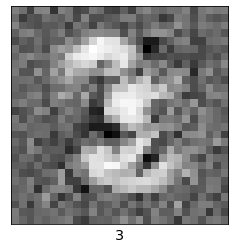

Epoch 40: Batch 0 Discrim loss 0.31601205468177795, Generator loss 0.8611607551574707


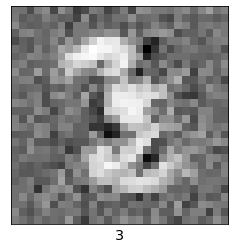

Epoch 40: Batch 100 Discrim loss 0.010735824704170227, Generator loss 0.7831103801727295


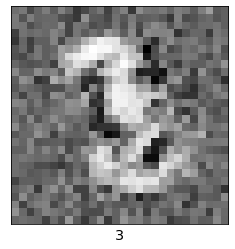

Epoch 40: Batch 200 Discrim loss 0.04325596243143082, Generator loss 0.6045833230018616


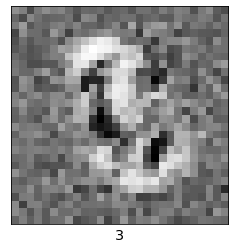

Epoch 40: Batch 300 Discrim loss 0.0037948705721646547, Generator loss 2.02412748336792


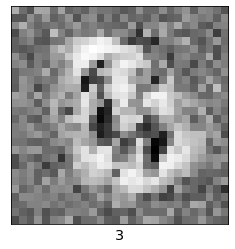

Epoch 40: Batch 400 Discrim loss 0.055486924946308136, Generator loss 1.474626898765564


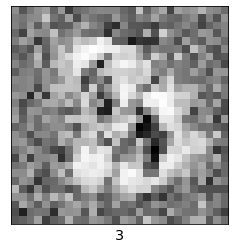

Epoch 40: Batch 500 Discrim loss 0.027697615325450897, Generator loss 1.0672800540924072


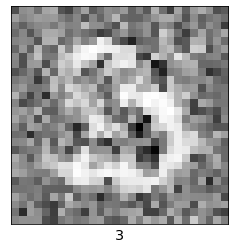

Epoch 40: Batch 600 Discrim loss 0.012012665160000324, Generator loss 1.422999620437622


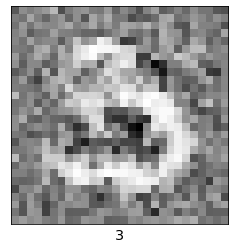

Epoch 40: Batch 700 Discrim loss 0.029653919860720634, Generator loss 1.437546730041504


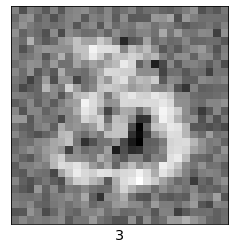

Epoch 40: Batch 800 Discrim loss 0.11069951951503754, Generator loss 1.8768608570098877


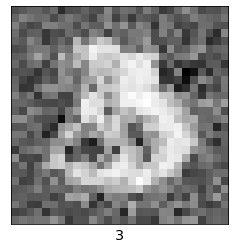

Epoch 40: Batch 900 Discrim loss 0.09211508184671402, Generator loss 1.4166021347045898


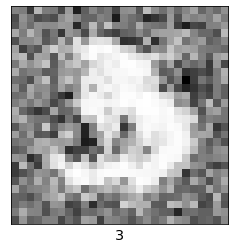

Epoch 40: Batch 1000 Discrim loss 0.013825129717588425, Generator loss 0.8903231620788574


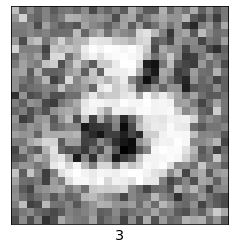

Epoch 40: Batch 1100 Discrim loss 0.028209343552589417, Generator loss 0.9230931997299194


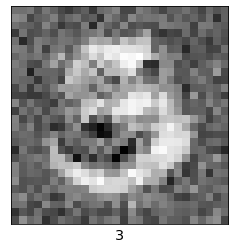

Epoch 40: Batch 1200 Discrim loss 0.11834781616926193, Generator loss 0.6939883232116699


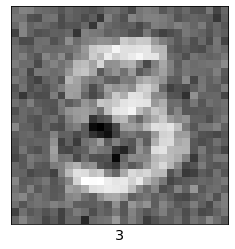

Epoch 40: Batch 1300 Discrim loss 0.018900109454989433, Generator loss 1.5129642486572266


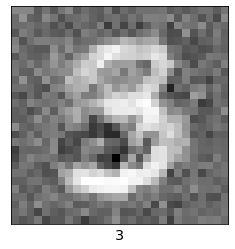

Epoch 40: Batch 1400 Discrim loss 0.03561309352517128, Generator loss 1.0106338262557983


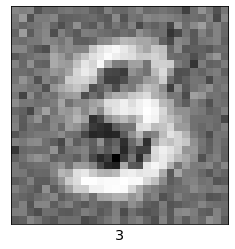

Epoch 40: Batch 1500 Discrim loss 0.05005929619073868, Generator loss 0.9164462089538574


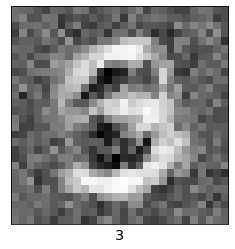

Epoch 40: Batch 1600 Discrim loss 0.022283295169472694, Generator loss 1.0646884441375732


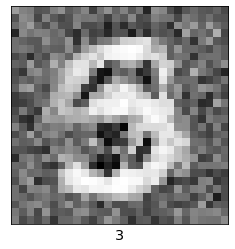

Epoch 40: Batch 1700 Discrim loss 0.04731546714901924, Generator loss 0.6025855541229248


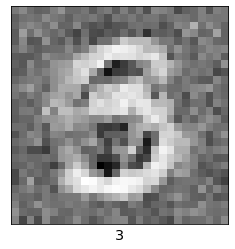

Epoch 40: Batch 1800 Discrim loss 0.13322679698467255, Generator loss 0.5913399457931519


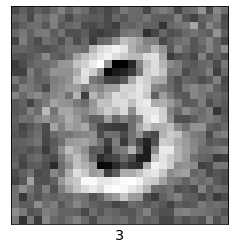

Epoch 41: Batch 0 Discrim loss 0.05003810301423073, Generator loss 0.5922956466674805


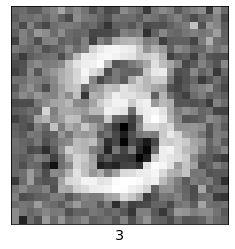

Epoch 41: Batch 100 Discrim loss 0.18579670786857605, Generator loss 0.7883353233337402


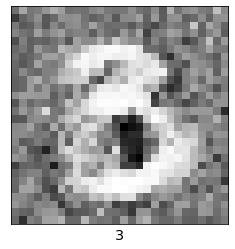

Epoch 41: Batch 200 Discrim loss 0.033521782606840134, Generator loss 2.6794002056121826


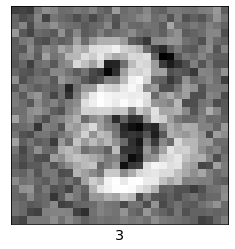

Epoch 41: Batch 300 Discrim loss 0.1315532922744751, Generator loss 0.8431963920593262


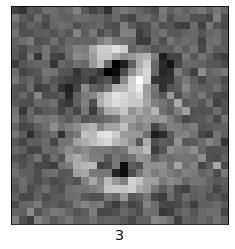

Epoch 41: Batch 400 Discrim loss 0.14173059165477753, Generator loss 0.6990024447441101


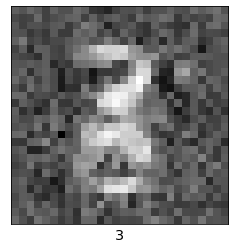

Epoch 41: Batch 500 Discrim loss 0.1212812215089798, Generator loss 1.5902395248413086


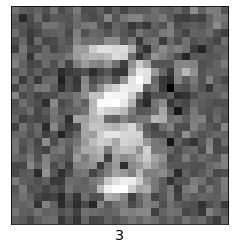

Epoch 41: Batch 600 Discrim loss 0.08233380317687988, Generator loss 1.027814507484436


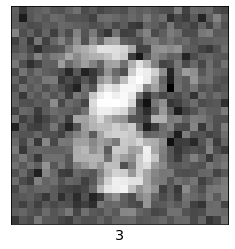

Epoch 41: Batch 700 Discrim loss 0.42575380206108093, Generator loss 1.1829158067703247


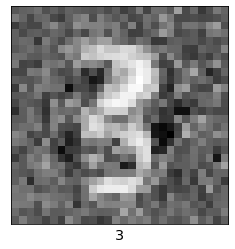

Epoch 41: Batch 800 Discrim loss 0.028986040502786636, Generator loss 0.9868911504745483


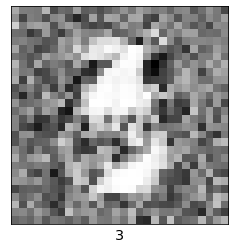

Epoch 41: Batch 900 Discrim loss 0.1609102338552475, Generator loss 1.552191138267517


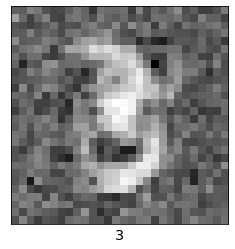

Epoch 41: Batch 1000 Discrim loss 0.09859749674797058, Generator loss 0.8113783597946167


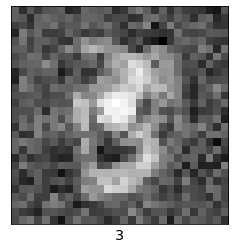

Epoch 41: Batch 1100 Discrim loss 0.04291829094290733, Generator loss 0.5842874050140381


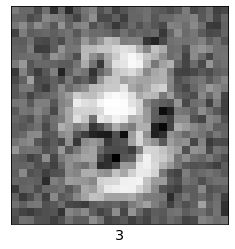

Epoch 41: Batch 1200 Discrim loss 0.07431872189044952, Generator loss 1.0884556770324707


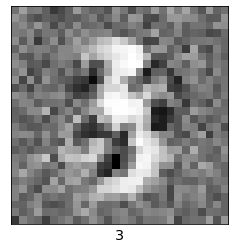

Epoch 41: Batch 1300 Discrim loss 0.025645142421126366, Generator loss 1.168920636177063


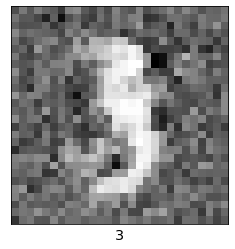

Epoch 41: Batch 1400 Discrim loss 0.01974436268210411, Generator loss 1.3770229816436768


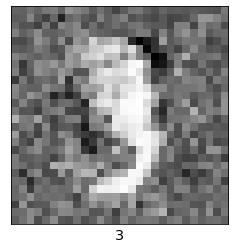

Epoch 41: Batch 1500 Discrim loss 0.04477968066930771, Generator loss 0.9644414782524109


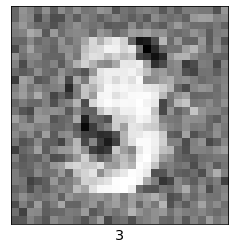

Epoch 41: Batch 1600 Discrim loss 0.06714849919080734, Generator loss 2.5185391902923584


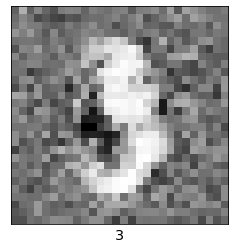

Epoch 41: Batch 1700 Discrim loss 0.06510414928197861, Generator loss 1.123703956604004


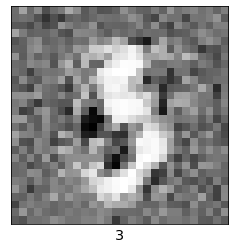

Epoch 41: Batch 1800 Discrim loss 0.09649716317653656, Generator loss 0.6551900506019592


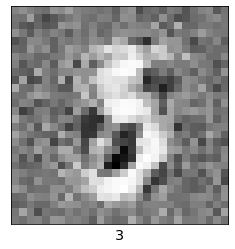

Epoch 42: Batch 0 Discrim loss 0.018849216401576996, Generator loss 1.4293380975723267


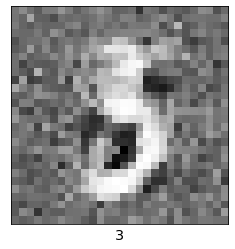

Epoch 42: Batch 100 Discrim loss 0.1314174234867096, Generator loss 0.7289603352546692


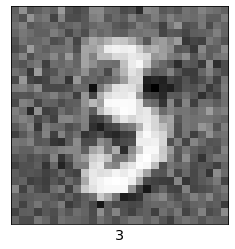

Epoch 42: Batch 200 Discrim loss 0.15063294768333435, Generator loss 1.9709064960479736


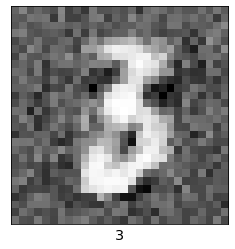

Epoch 42: Batch 300 Discrim loss 0.014994261786341667, Generator loss 1.1025283336639404


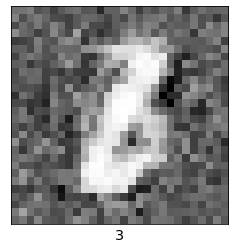

Epoch 42: Batch 400 Discrim loss 0.116309255361557, Generator loss 0.9156795740127563


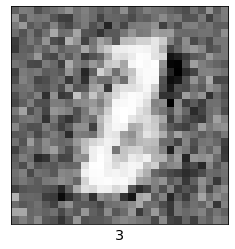

Epoch 42: Batch 500 Discrim loss 0.040694188326597214, Generator loss 1.3737788200378418


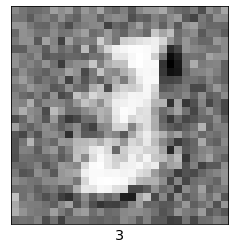

Epoch 42: Batch 600 Discrim loss 0.17741812765598297, Generator loss 1.0188966989517212


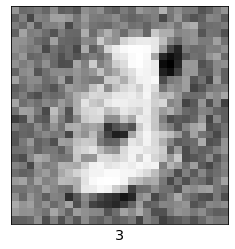

Epoch 42: Batch 700 Discrim loss 0.22329901158809662, Generator loss 0.7292906641960144


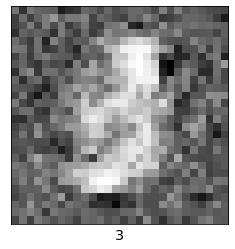

Epoch 42: Batch 800 Discrim loss 1.2526540756225586, Generator loss 1.7184092998504639


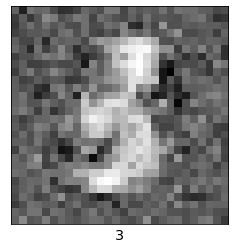

Epoch 42: Batch 900 Discrim loss 0.024799473583698273, Generator loss 1.234525203704834


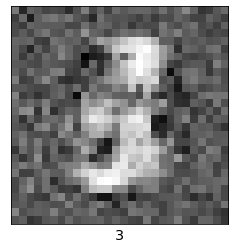

Epoch 42: Batch 1000 Discrim loss 0.01628408208489418, Generator loss 1.0160696506500244


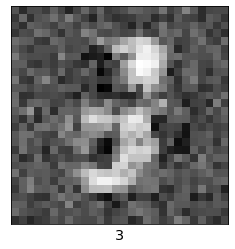

Epoch 42: Batch 1100 Discrim loss 0.017063193023204803, Generator loss 1.1886184215545654


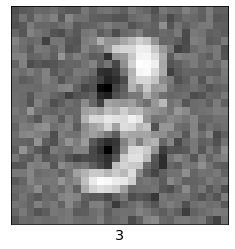

Epoch 42: Batch 1200 Discrim loss 0.12744006514549255, Generator loss 1.0931735038757324


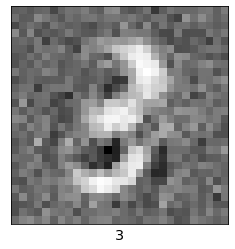

Epoch 42: Batch 1300 Discrim loss 0.09976226091384888, Generator loss 0.9460249543190002


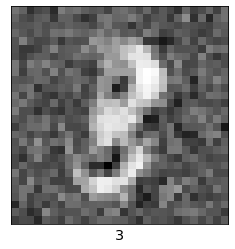

Epoch 42: Batch 1400 Discrim loss 0.02232779935002327, Generator loss 1.2933845520019531


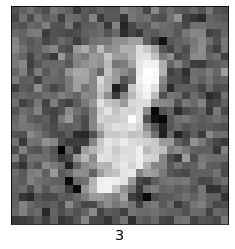

Epoch 42: Batch 1500 Discrim loss 0.04213247448205948, Generator loss 1.598923683166504


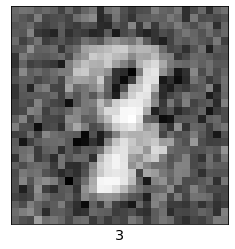

Epoch 42: Batch 1600 Discrim loss 0.35067519545555115, Generator loss 1.5888780355453491


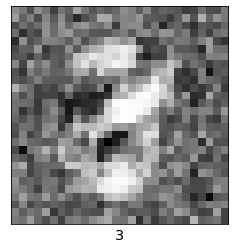

Epoch 42: Batch 1700 Discrim loss 0.11828938126564026, Generator loss 1.1719142198562622


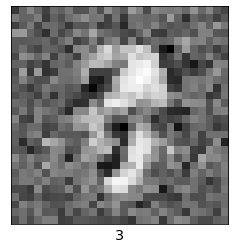

Epoch 42: Batch 1800 Discrim loss 0.10579439997673035, Generator loss 0.9607396125793457


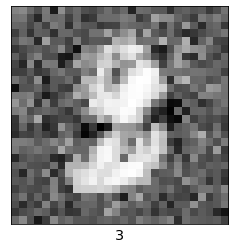

Epoch 43: Batch 0 Discrim loss 0.11001180857419968, Generator loss 1.5310636758804321


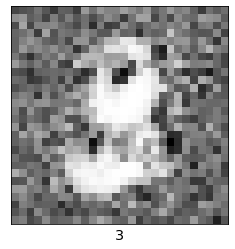

Epoch 43: Batch 100 Discrim loss 0.07758524268865585, Generator loss 3.105576992034912


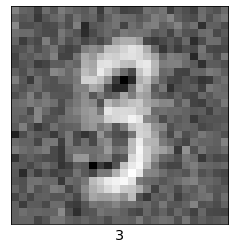

Epoch 43: Batch 200 Discrim loss 0.21583163738250732, Generator loss 1.6996219158172607


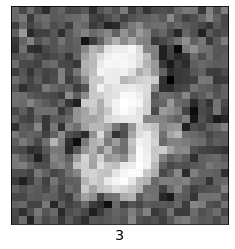

Epoch 43: Batch 300 Discrim loss 0.01808255724608898, Generator loss 0.9003654718399048


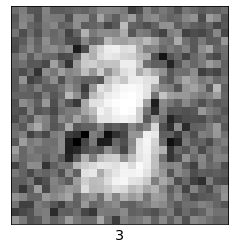

Epoch 43: Batch 400 Discrim loss 0.20090211927890778, Generator loss 1.3900737762451172


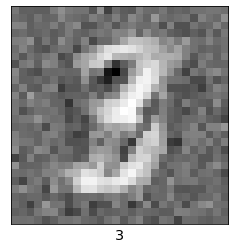

Epoch 43: Batch 500 Discrim loss 0.13199010491371155, Generator loss 1.1968910694122314


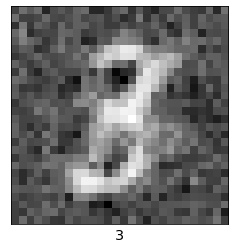

Epoch 43: Batch 600 Discrim loss 0.08352261781692505, Generator loss 1.0626821517944336


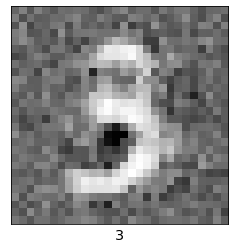

Epoch 43: Batch 700 Discrim loss 0.24052922427654266, Generator loss 1.3073604106903076


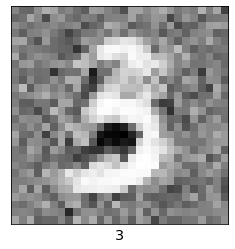

Epoch 43: Batch 800 Discrim loss 0.026069562882184982, Generator loss 1.236264944076538


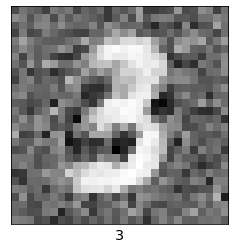

Epoch 43: Batch 900 Discrim loss 0.2516428232192993, Generator loss 0.7491737604141235


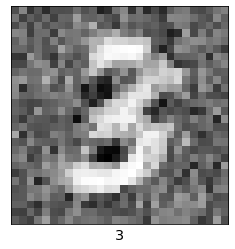

Epoch 43: Batch 1000 Discrim loss 0.08649905025959015, Generator loss 0.47627967596054077


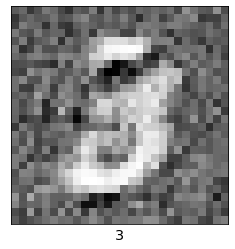

Epoch 43: Batch 1100 Discrim loss 0.017863599583506584, Generator loss 1.0241234302520752


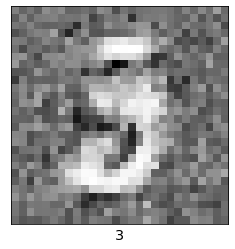

Epoch 43: Batch 1200 Discrim loss 0.2535897195339203, Generator loss 0.8469069004058838


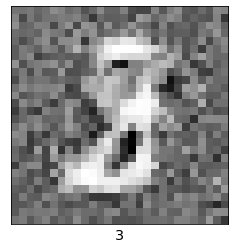

Epoch 43: Batch 1300 Discrim loss 0.08404842019081116, Generator loss 0.9443613290786743


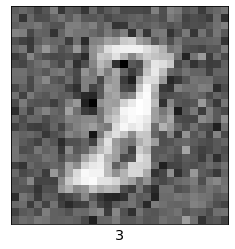

Epoch 43: Batch 1400 Discrim loss 0.03745036944746971, Generator loss 1.5229153633117676


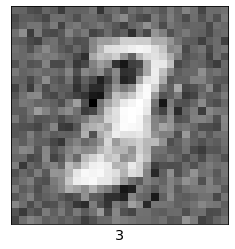

Epoch 43: Batch 1500 Discrim loss 0.04978620260953903, Generator loss 1.3886525630950928


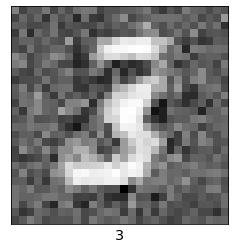

Epoch 43: Batch 1600 Discrim loss 0.27836155891418457, Generator loss 1.1264432668685913


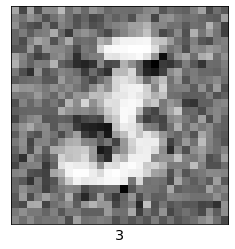

Epoch 43: Batch 1700 Discrim loss 0.1314086765050888, Generator loss 1.3903913497924805


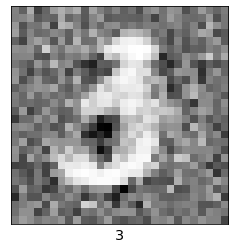

Epoch 43: Batch 1800 Discrim loss 0.02423064410686493, Generator loss 1.9323914051055908


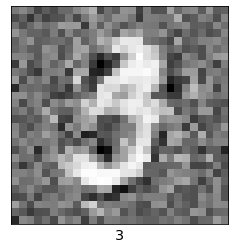

Epoch 44: Batch 0 Discrim loss 0.12049568444490433, Generator loss 0.6718077659606934


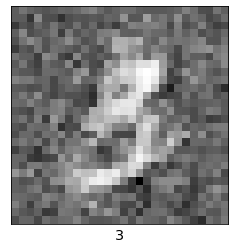

Epoch 44: Batch 100 Discrim loss 0.013901766389608383, Generator loss 1.5083842277526855


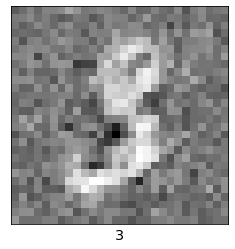

Epoch 44: Batch 200 Discrim loss 0.025832325220108032, Generator loss 1.5869059562683105


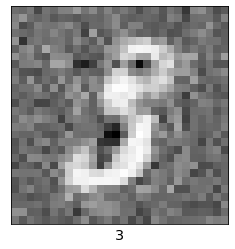

Epoch 44: Batch 300 Discrim loss 0.053845759481191635, Generator loss 1.1768180131912231


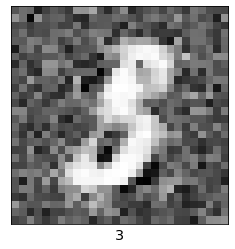

Epoch 44: Batch 400 Discrim loss 0.04926864802837372, Generator loss 1.2961622476577759


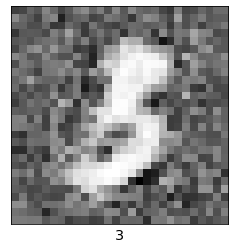

Epoch 44: Batch 500 Discrim loss 0.03134667128324509, Generator loss 1.230381727218628


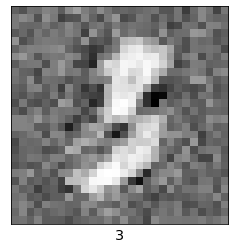

Epoch 44: Batch 600 Discrim loss 0.06633056700229645, Generator loss 1.2472789287567139


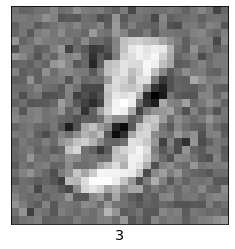

Epoch 44: Batch 700 Discrim loss 0.010276825167238712, Generator loss 0.7764979004859924


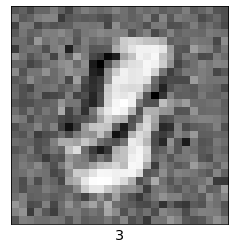

Epoch 44: Batch 800 Discrim loss 0.20130035281181335, Generator loss 1.3883728981018066


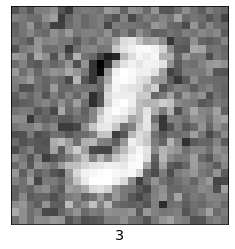

Epoch 44: Batch 900 Discrim loss 0.036050643771886826, Generator loss 0.6285146474838257


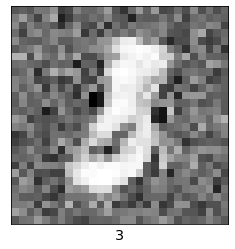

Epoch 44: Batch 1000 Discrim loss 0.10164795815944672, Generator loss 0.873170793056488


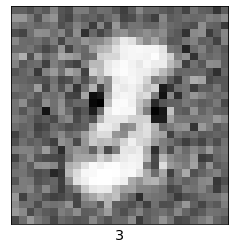

Epoch 44: Batch 1100 Discrim loss 0.07519582659006119, Generator loss 1.5176966190338135


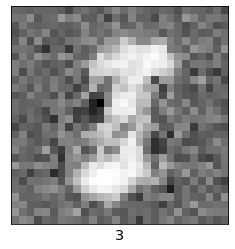

Epoch 44: Batch 1200 Discrim loss 0.02972455322742462, Generator loss 0.3927437663078308


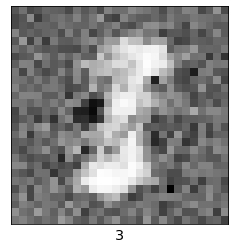

Epoch 44: Batch 1300 Discrim loss 0.10035636276006699, Generator loss 1.694849967956543


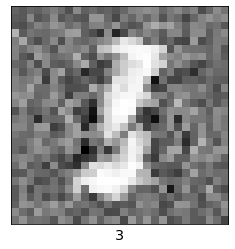

Epoch 44: Batch 1400 Discrim loss 0.20050884783267975, Generator loss 0.8628944754600525


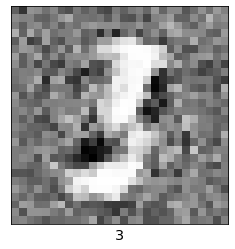

Epoch 44: Batch 1500 Discrim loss 0.223922461271286, Generator loss 1.0546077489852905


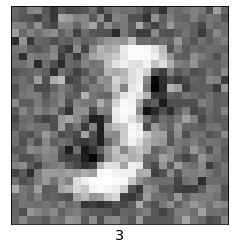

Epoch 44: Batch 1600 Discrim loss 0.19440867006778717, Generator loss 1.3373421430587769


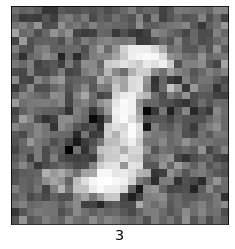

Epoch 44: Batch 1700 Discrim loss 0.02063341625034809, Generator loss 0.9120882153511047


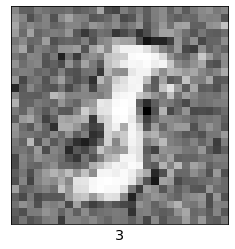

Epoch 44: Batch 1800 Discrim loss 0.049518294632434845, Generator loss 0.7101427316665649


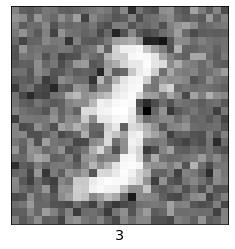

Epoch 45: Batch 0 Discrim loss 0.04686655104160309, Generator loss 0.9087294936180115


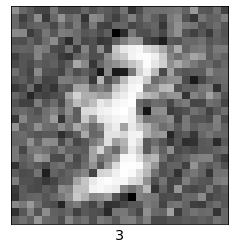

Epoch 45: Batch 100 Discrim loss 0.01371547020971775, Generator loss 0.8240675330162048


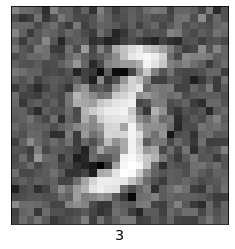

Epoch 45: Batch 200 Discrim loss 0.011811385862529278, Generator loss 0.4203149676322937


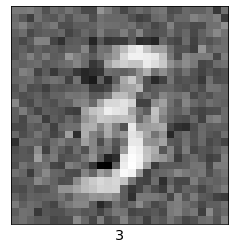

Epoch 45: Batch 300 Discrim loss 0.03793845325708389, Generator loss 0.5239555239677429


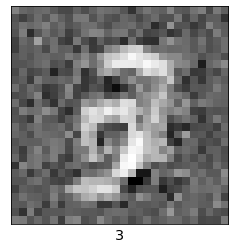

Epoch 45: Batch 400 Discrim loss 0.015111664310097694, Generator loss 0.8456467390060425


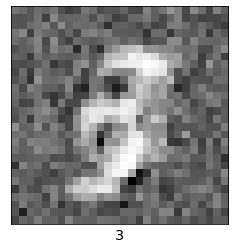

Epoch 45: Batch 500 Discrim loss 0.23090529441833496, Generator loss 1.305961012840271


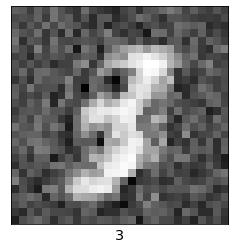

Epoch 45: Batch 600 Discrim loss 0.01026194728910923, Generator loss 0.6221075057983398


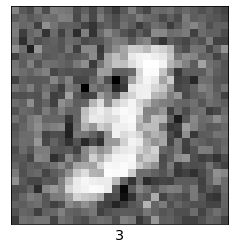

Epoch 45: Batch 700 Discrim loss 0.16845163702964783, Generator loss 1.5110406875610352


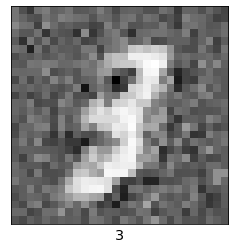

Epoch 45: Batch 800 Discrim loss 0.05733264237642288, Generator loss 0.7042966485023499


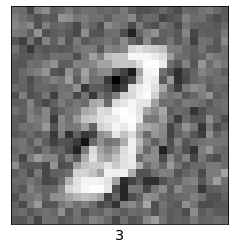

Epoch 45: Batch 900 Discrim loss 0.05109196528792381, Generator loss 0.8284736275672913


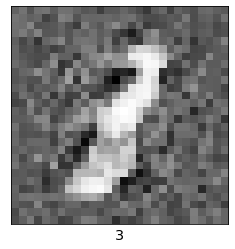

Epoch 45: Batch 1000 Discrim loss 0.11095445603132248, Generator loss 1.3855870962142944


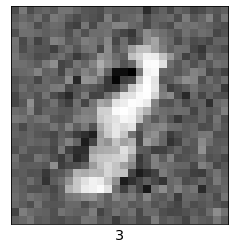

Epoch 45: Batch 1100 Discrim loss 0.04667147994041443, Generator loss 0.6056421399116516


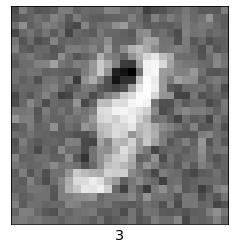

Epoch 45: Batch 1200 Discrim loss 0.012455714866518974, Generator loss 1.019558310508728


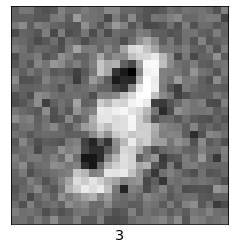

Epoch 45: Batch 1300 Discrim loss 0.04945604130625725, Generator loss 0.9441280364990234


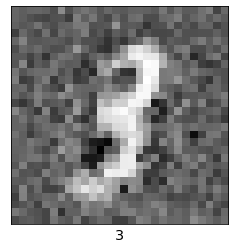

Epoch 45: Batch 1400 Discrim loss 0.011548580601811409, Generator loss 1.269810676574707


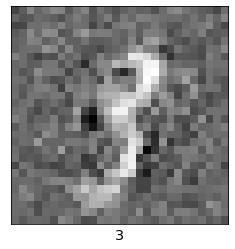

Epoch 45: Batch 1500 Discrim loss 0.01204410009086132, Generator loss 2.16262149810791


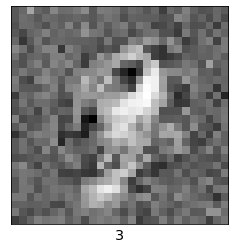

Epoch 45: Batch 1600 Discrim loss 0.08721151947975159, Generator loss 1.9201774597167969


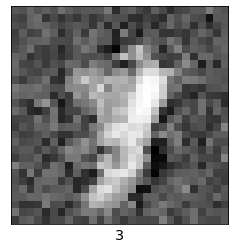

Epoch 45: Batch 1700 Discrim loss 0.04535003751516342, Generator loss 1.5789647102355957


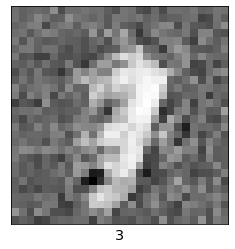

Epoch 45: Batch 1800 Discrim loss 0.016401831060647964, Generator loss 0.8384860754013062


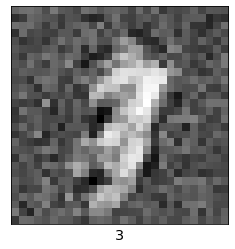

Epoch 46: Batch 0 Discrim loss 0.008445770479738712, Generator loss 0.7512807250022888


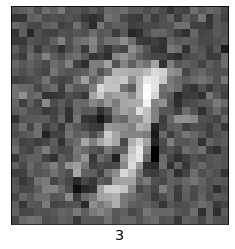

Epoch 46: Batch 100 Discrim loss 0.18849360942840576, Generator loss 0.9117220640182495


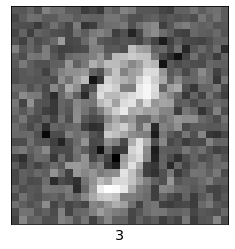

Epoch 46: Batch 200 Discrim loss 0.03899761289358139, Generator loss 0.7286450862884521


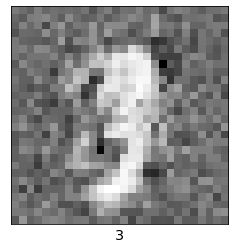

Epoch 46: Batch 300 Discrim loss 0.03753942251205444, Generator loss 0.7509832382202148


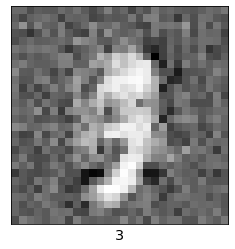

Epoch 46: Batch 400 Discrim loss 0.01080038771033287, Generator loss 0.9838022589683533


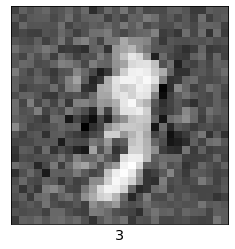

Epoch 46: Batch 500 Discrim loss 0.011706789024174213, Generator loss 1.4296441078186035


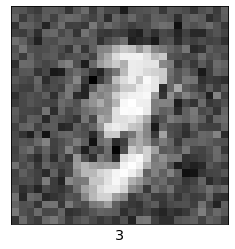

Epoch 46: Batch 600 Discrim loss 0.014532279223203659, Generator loss 1.1337308883666992


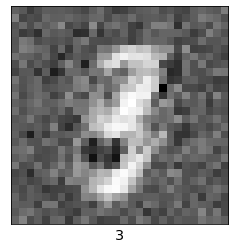

Epoch 46: Batch 700 Discrim loss 0.01772201433777809, Generator loss 0.7101421356201172


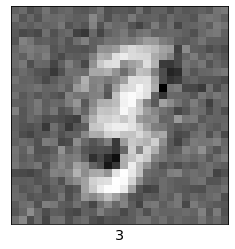

Epoch 46: Batch 800 Discrim loss 0.007083742879331112, Generator loss 1.480921983718872


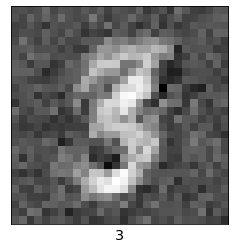

Epoch 46: Batch 900 Discrim loss 0.016835782676935196, Generator loss 0.49553894996643066


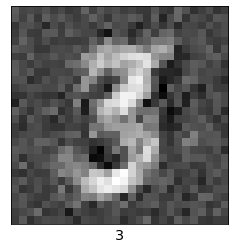

Epoch 46: Batch 1000 Discrim loss 0.019923610612750053, Generator loss 0.7800683975219727


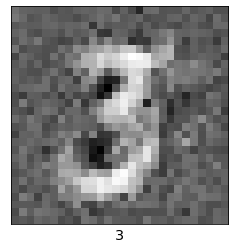

Epoch 46: Batch 1100 Discrim loss 0.002622077474370599, Generator loss 0.9939115643501282


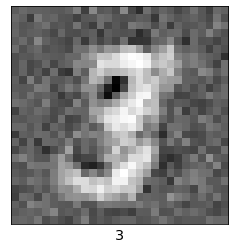

Epoch 46: Batch 1200 Discrim loss 0.021590856835246086, Generator loss 1.607172966003418


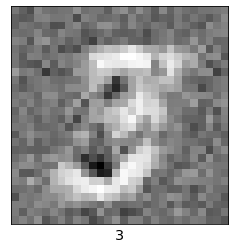

Epoch 46: Batch 1300 Discrim loss 0.05031438544392586, Generator loss 1.4524282217025757


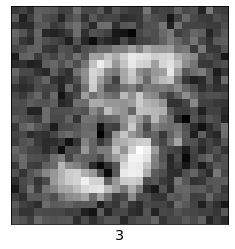

Epoch 46: Batch 1400 Discrim loss 0.06001162528991699, Generator loss 1.4981122016906738


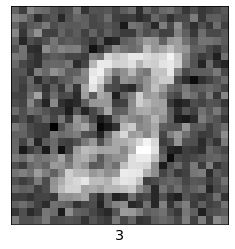

Epoch 46: Batch 1500 Discrim loss 0.06627465784549713, Generator loss 1.4825420379638672


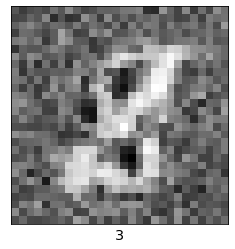

Epoch 46: Batch 1600 Discrim loss 0.014986184425652027, Generator loss 0.9060561656951904


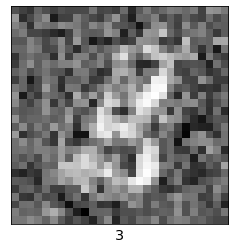

Epoch 46: Batch 1700 Discrim loss 0.19558170437812805, Generator loss 1.3568439483642578


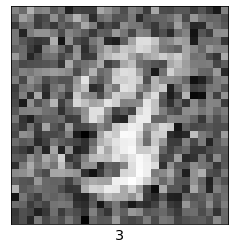

Epoch 46: Batch 1800 Discrim loss 0.10193035751581192, Generator loss 1.3129067420959473


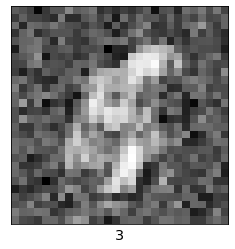

Epoch 47: Batch 0 Discrim loss 0.1726570576429367, Generator loss 1.7576630115509033


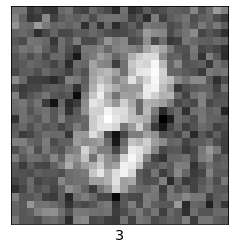

Epoch 47: Batch 100 Discrim loss 0.005995390936732292, Generator loss 1.542224407196045


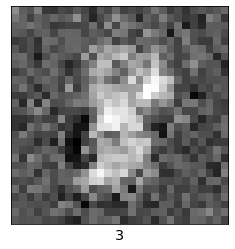

Epoch 47: Batch 200 Discrim loss 0.016704976558685303, Generator loss 2.4201760292053223


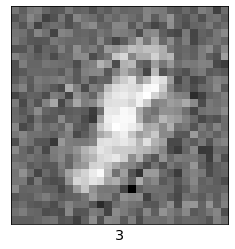

Epoch 47: Batch 300 Discrim loss 0.004693559370934963, Generator loss 1.5799787044525146


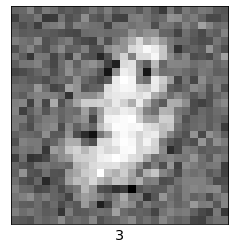

Epoch 47: Batch 400 Discrim loss 0.0736108347773552, Generator loss 1.1142306327819824


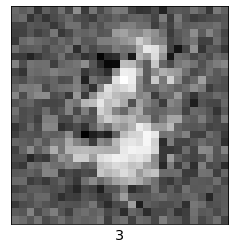

Epoch 47: Batch 500 Discrim loss 0.02375427633523941, Generator loss 0.9826030731201172


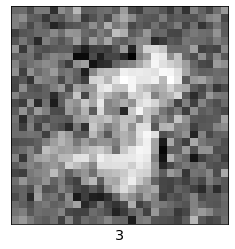

Epoch 47: Batch 600 Discrim loss 0.00568117992952466, Generator loss 1.0450791120529175


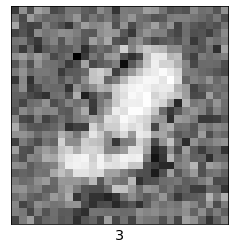

Epoch 47: Batch 700 Discrim loss 0.0020530784968286753, Generator loss 1.3350062370300293


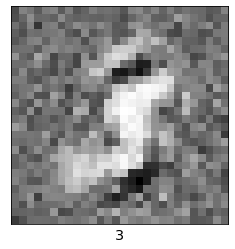

Epoch 47: Batch 800 Discrim loss 0.03320491313934326, Generator loss 1.9150201082229614


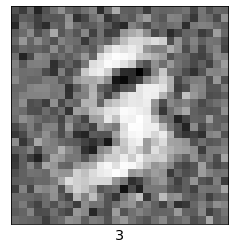

Epoch 47: Batch 900 Discrim loss 0.16089852154254913, Generator loss 0.5816083550453186


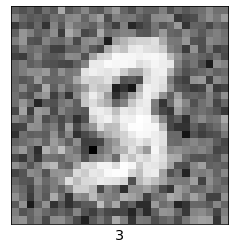

Epoch 47: Batch 1000 Discrim loss 0.039614975452423096, Generator loss 2.7340383529663086


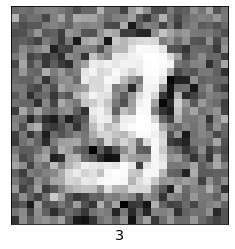

Epoch 47: Batch 1100 Discrim loss 0.05503267049789429, Generator loss 2.476133346557617


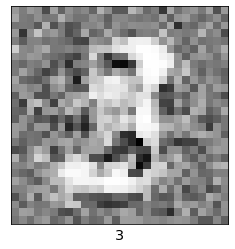

Epoch 47: Batch 1200 Discrim loss 0.23002998530864716, Generator loss 3.167832851409912


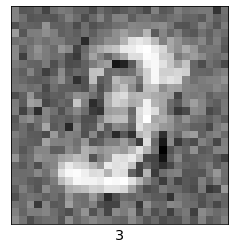

Epoch 47: Batch 1300 Discrim loss 0.01363456156104803, Generator loss 0.1717061996459961


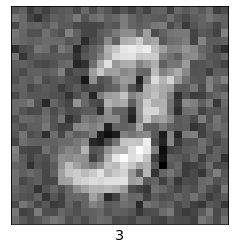

Epoch 47: Batch 1400 Discrim loss 0.010405809618532658, Generator loss 0.49664777517318726


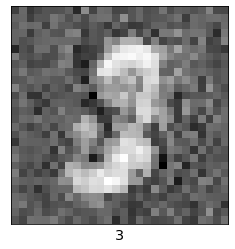

Epoch 47: Batch 1500 Discrim loss 0.0698854997754097, Generator loss 1.1092699766159058


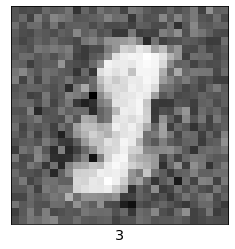

Epoch 47: Batch 1600 Discrim loss 0.04520802199840546, Generator loss 1.2584971189498901


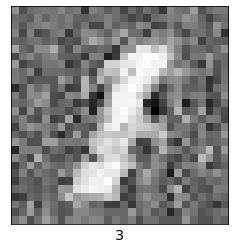

Epoch 47: Batch 1700 Discrim loss 0.004412648733705282, Generator loss 0.6977224349975586


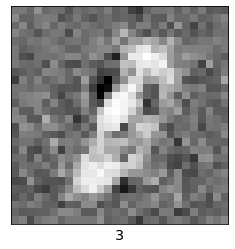

Epoch 47: Batch 1800 Discrim loss 0.005885513499379158, Generator loss 2.312870979309082


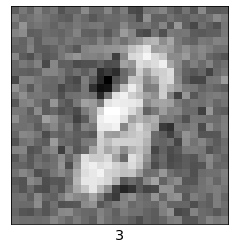

Epoch 48: Batch 0 Discrim loss 0.15671831369400024, Generator loss 3.0585780143737793


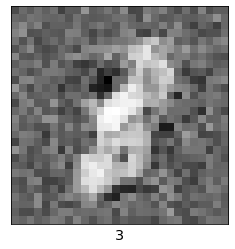

Epoch 48: Batch 100 Discrim loss 0.0034658208023756742, Generator loss 2.2856626510620117


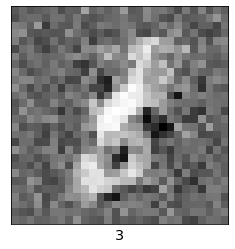

Epoch 48: Batch 200 Discrim loss 0.033859916031360626, Generator loss 2.5432722568511963


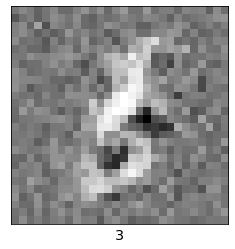

Epoch 48: Batch 300 Discrim loss 0.08959567546844482, Generator loss 1.1376453638076782


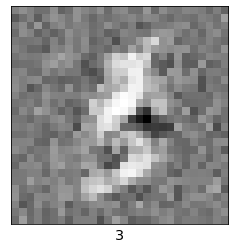

Epoch 48: Batch 400 Discrim loss 0.00436224602162838, Generator loss 0.6118281483650208


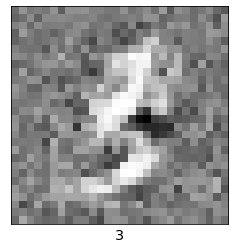

Epoch 48: Batch 500 Discrim loss 0.0070449067279696465, Generator loss 0.7025490999221802


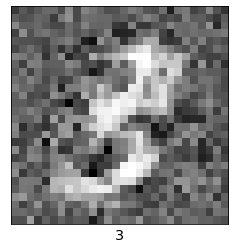

Epoch 48: Batch 600 Discrim loss 0.1566063016653061, Generator loss 1.4653007984161377


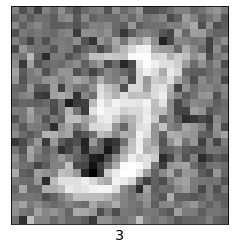

Epoch 48: Batch 700 Discrim loss 0.009877238422632217, Generator loss 0.9200952053070068


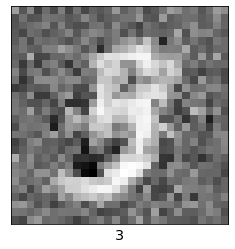

Epoch 48: Batch 800 Discrim loss 0.028674865141510963, Generator loss 0.5774809718132019


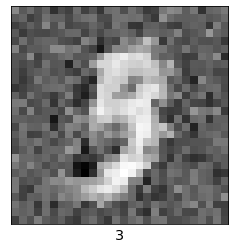

Epoch 48: Batch 900 Discrim loss 0.013042558915913105, Generator loss 1.7487707138061523


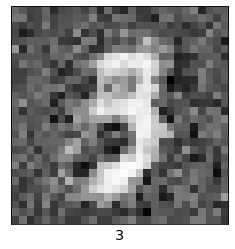

Epoch 48: Batch 1000 Discrim loss 0.010340564884245396, Generator loss 0.4225838780403137


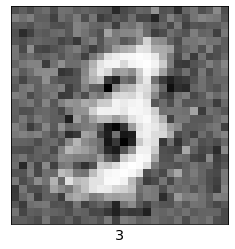

Epoch 48: Batch 1100 Discrim loss 0.040089935064315796, Generator loss 1.0312719345092773


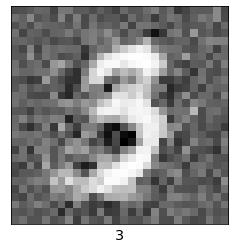

Epoch 48: Batch 1200 Discrim loss 0.007458118721842766, Generator loss 1.390053391456604


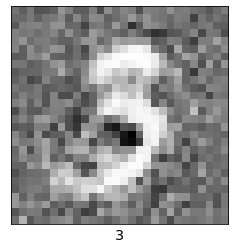

Epoch 48: Batch 1300 Discrim loss 0.003444757778197527, Generator loss 1.1852309703826904


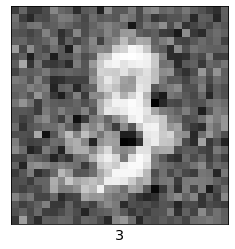

Epoch 48: Batch 1400 Discrim loss 0.013670037500560284, Generator loss 1.7311080694198608


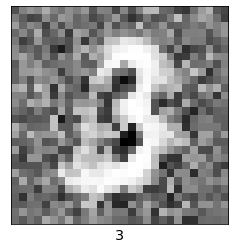

Epoch 48: Batch 1500 Discrim loss 0.004862585570663214, Generator loss 0.7147552967071533


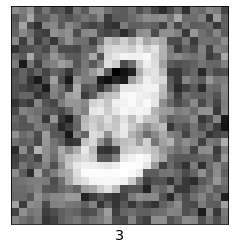

Epoch 48: Batch 1600 Discrim loss 0.013793736696243286, Generator loss 0.8250505924224854


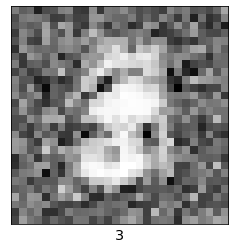

Epoch 48: Batch 1700 Discrim loss 0.031015796586871147, Generator loss 1.0597461462020874


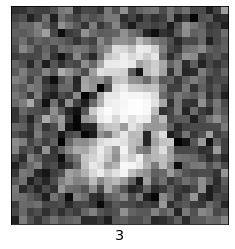

Epoch 48: Batch 1800 Discrim loss 0.01936602219939232, Generator loss 1.2950661182403564


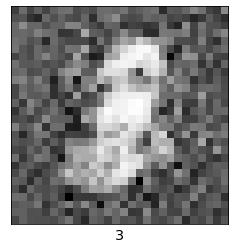

Epoch 49: Batch 0 Discrim loss 0.042322754859924316, Generator loss 0.8308797478675842


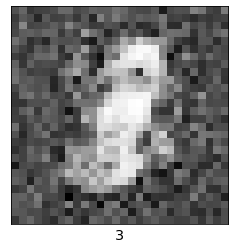

Epoch 49: Batch 100 Discrim loss 0.008829927071928978, Generator loss 0.972042441368103


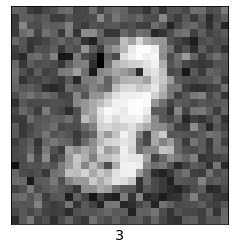

Epoch 49: Batch 200 Discrim loss 0.010191979818046093, Generator loss 0.6896518468856812


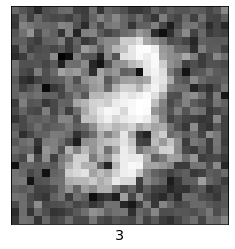

Epoch 49: Batch 300 Discrim loss 0.05981028079986572, Generator loss 1.3715652227401733


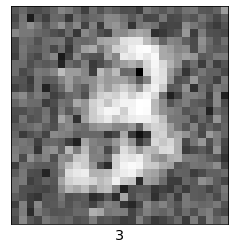

Epoch 49: Batch 400 Discrim loss 0.09006237238645554, Generator loss 1.9087073802947998


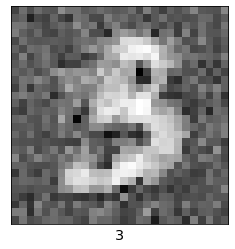

Epoch 49: Batch 500 Discrim loss 0.06593265384435654, Generator loss 1.1792751550674438


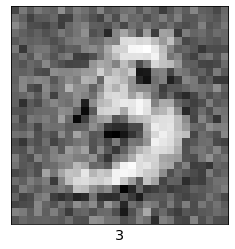

Epoch 49: Batch 600 Discrim loss 0.01218468602746725, Generator loss 1.5760304927825928


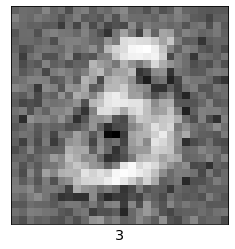

Epoch 49: Batch 700 Discrim loss 0.014317077584564686, Generator loss 0.9132014513015747


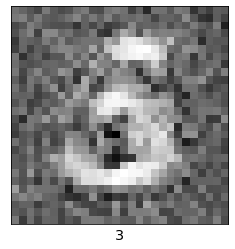

Epoch 49: Batch 800 Discrim loss 0.011235939338803291, Generator loss 1.621473789215088


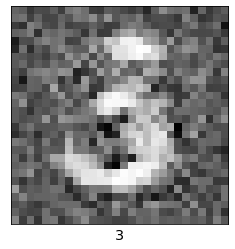

Epoch 49: Batch 900 Discrim loss 0.03152735158801079, Generator loss 0.7140506505966187


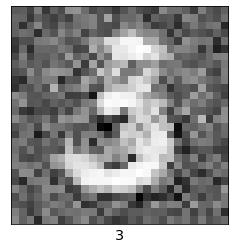

Epoch 49: Batch 1000 Discrim loss 0.044060882180929184, Generator loss 1.5989010334014893


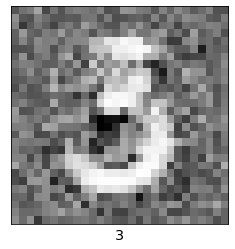

Epoch 49: Batch 1100 Discrim loss 0.08525441586971283, Generator loss 1.2100623846054077


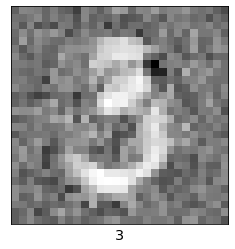

Epoch 49: Batch 1200 Discrim loss 0.014340555295348167, Generator loss 0.9767471551895142


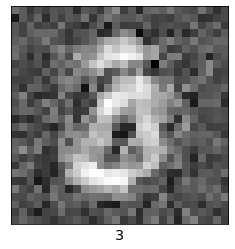

Epoch 49: Batch 1300 Discrim loss 0.16896381974220276, Generator loss 1.6696772575378418


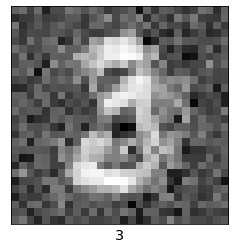

Epoch 49: Batch 1400 Discrim loss 0.041627708822488785, Generator loss 1.1635321378707886


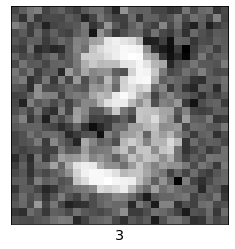

Epoch 49: Batch 1500 Discrim loss 0.07096534222364426, Generator loss 3.230135440826416


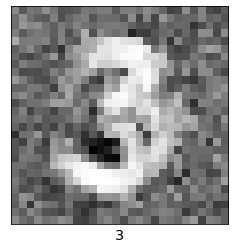

Epoch 49: Batch 1600 Discrim loss 0.04145132750272751, Generator loss 1.7413749694824219


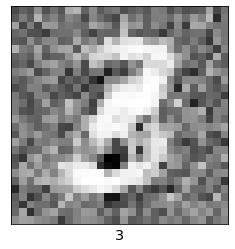

Epoch 49: Batch 1700 Discrim loss 0.06790332496166229, Generator loss 0.556739091873169


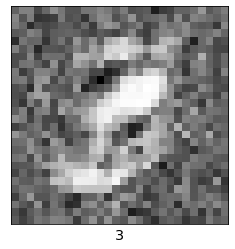

Epoch 49: Batch 1800 Discrim loss 0.018688086420297623, Generator loss 0.6158642768859863


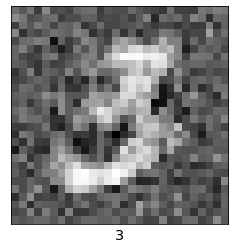

Epoch 50: Batch 0 Discrim loss 0.1179741621017456, Generator loss 1.4962079524993896


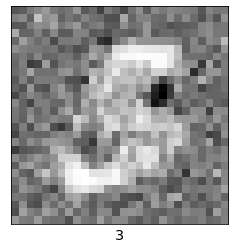

Epoch 50: Batch 100 Discrim loss 0.042066410183906555, Generator loss 1.5299489498138428


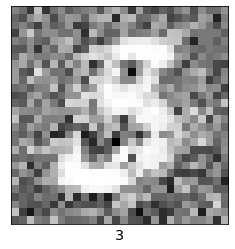

Epoch 50: Batch 200 Discrim loss 0.017222749069333076, Generator loss 1.8274598121643066


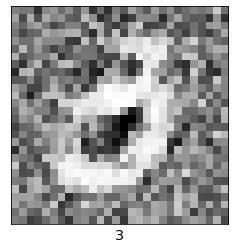

Epoch 50: Batch 300 Discrim loss 0.00732421176508069, Generator loss 1.3445242643356323


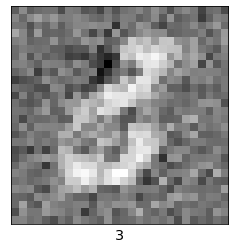

Epoch 50: Batch 400 Discrim loss 0.0075504663400352, Generator loss 1.8419662714004517


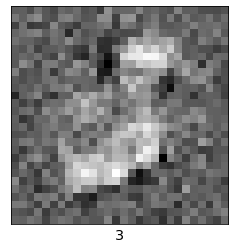

Epoch 50: Batch 500 Discrim loss 0.05602651834487915, Generator loss 0.6166650652885437


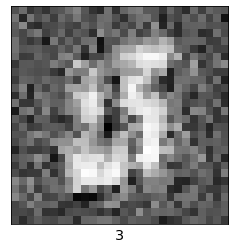

Epoch 50: Batch 600 Discrim loss 0.18178832530975342, Generator loss 0.5321130752563477


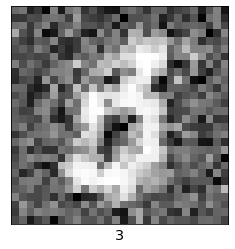

Epoch 50: Batch 700 Discrim loss 0.008669442497193813, Generator loss 1.1326665878295898


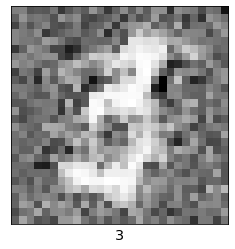

Epoch 50: Batch 800 Discrim loss 0.03803952783346176, Generator loss 1.967228651046753


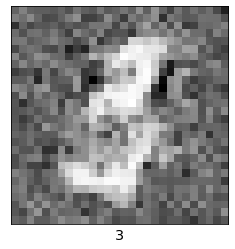

Epoch 50: Batch 900 Discrim loss 0.09783856570720673, Generator loss 2.828129529953003


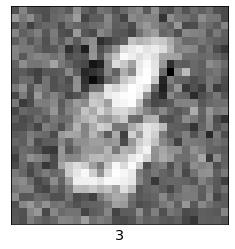

Epoch 50: Batch 1000 Discrim loss 0.01920868456363678, Generator loss 0.5726056694984436


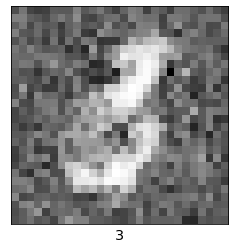

Epoch 50: Batch 1100 Discrim loss 0.042534541338682175, Generator loss 1.6999051570892334


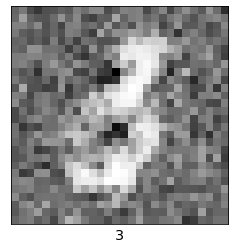

Epoch 50: Batch 1200 Discrim loss 0.13748851418495178, Generator loss 1.745762825012207


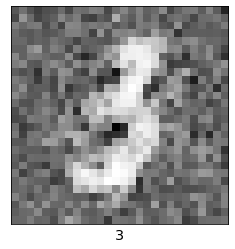

Epoch 50: Batch 1300 Discrim loss 0.0268184095621109, Generator loss 1.262978434562683


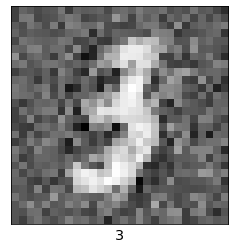

Epoch 50: Batch 1400 Discrim loss 0.047685205936431885, Generator loss 1.0644081830978394


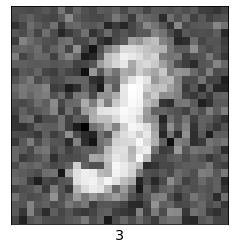

Epoch 50: Batch 1500 Discrim loss 0.019991904497146606, Generator loss 1.4040557146072388


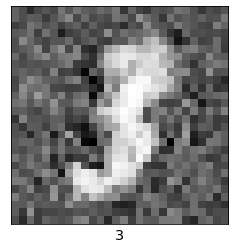

Epoch 50: Batch 1600 Discrim loss 0.039443232119083405, Generator loss 1.7704929113388062


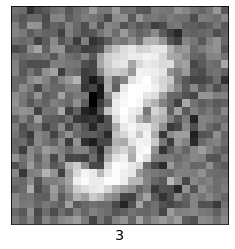

Epoch 50: Batch 1700 Discrim loss 0.013167766854166985, Generator loss 0.7783572673797607


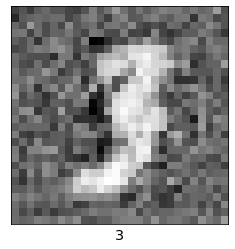

Epoch 50: Batch 1800 Discrim loss 0.00708859832957387, Generator loss 0.7571293115615845


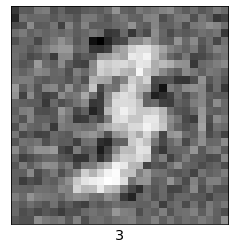

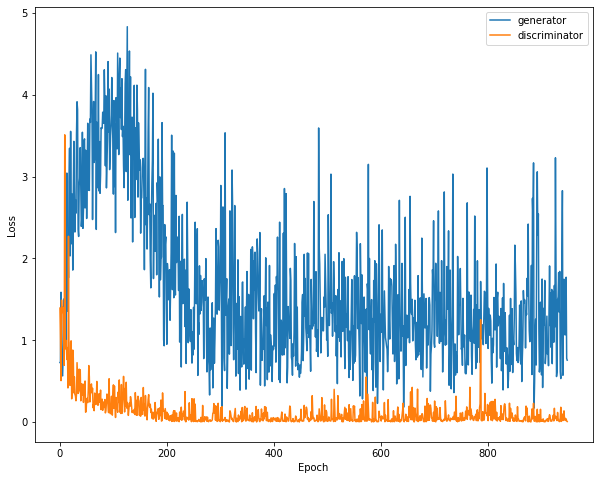

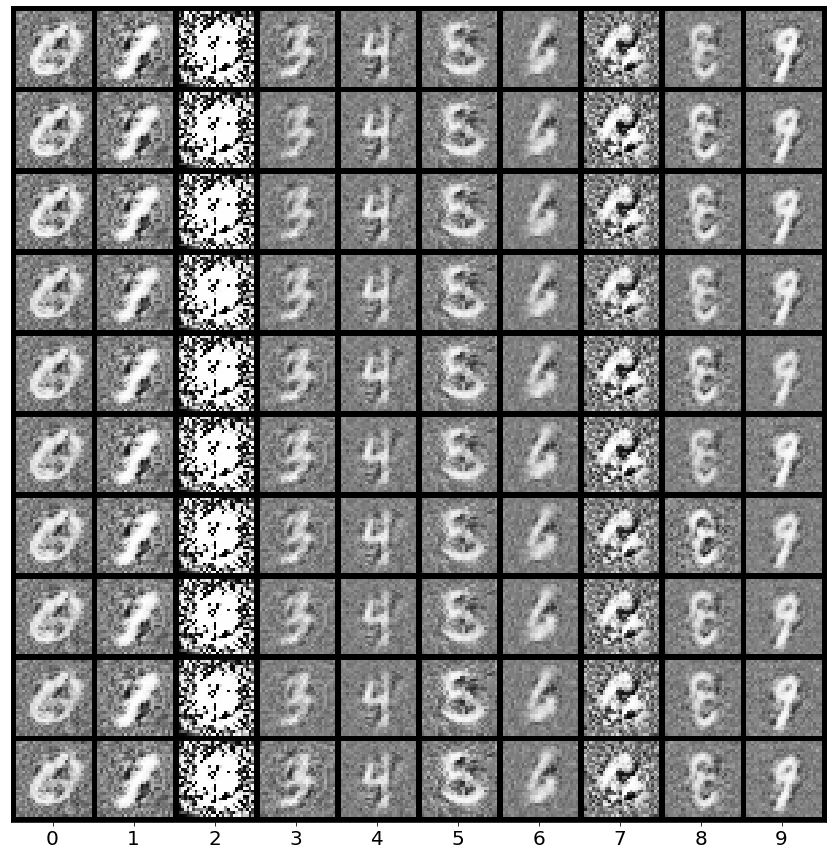

In [0]:
train_net(train_loader, gen_opt, dis_opt, hparams_gan['num_epochs'])

# testing results
noise_vector = create_noise(100)
labels = Variable(torch.LongTensor([i for _ in range(10) for i in range(10)])).cuda()
num_images = generator(noise_vector, labels).detach()
num_images = num_images.view(num_images.size(0), 1, 28, 28)
grid = utils.make_grid(num_images.cpu(), nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], fontsize=20)

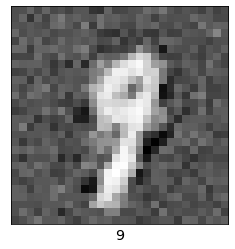

In [0]:
# select number to generate:
digit = 9
label = Variable(torch.LongTensor([digit])).cuda()
random_noise = create_noise(1)

out_image = generator(random_noise,label).detach()
out_image = out_image.view(out_image.size(0), 1, 28, 28)
plot_output_gen(out_image, digit)